# Advanced Machine Learning Based Surface Defect Detection Systems. -- Source Code.

# Runqi Su.

# Contents:

### I. Image Labeling.
### II. Data Balance.
### III. Data Preprocessing.
### IV. Training on the Original Dataset.
### V. Training on the Otsu Binary Only Dataset.
### VI. Training on the Wavelet Only Dataset.
### VII. Training on the Wavelet & Otsu Dataset.
### VIII. Training on the Otsu & Wavelet Dataset.
### IX. Grouped Bar Charts.

## I. Image Labeling.

### 1. Data Source:

#### This dataset is provided by the authors in the paper: Huang Y, Qiu C, Yuan K. Surface defect saliency of magnetic tile[J]. The Visual Computer, 2020, 36(1): 85-96.

### 2. Image Labeling:

#### All the images in the dataset were labeled manually by Runqi using Labelimg. The format of the label file is .txt. The label content is in YOLO format. Each file contains a number and a coordinate. The number represents the type of defect, and the coordinate represents the location of the defect. Manual labeling was originally used for training the YOLO model. Classic machine learning models cannot input coordinate data, and the label file will be modified later.

## II. Data Balance.

### 1. Histogram of each defect class in the original authors' dataset ( before balance ):

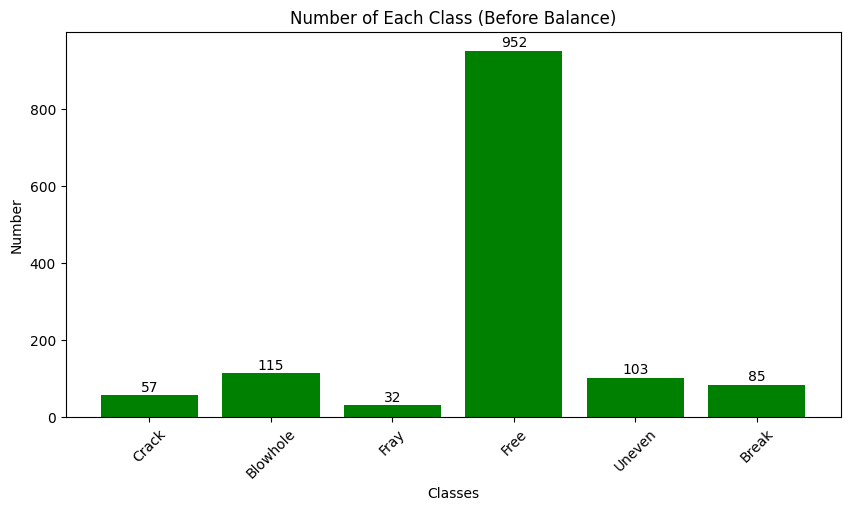

In [1]:
import os
import matplotlib.pyplot as plt

# Directory of images
root_dir = '/Users/surq/workspace/tile_defects/datasets/splited_datasets/original_dataset/images'

# Collecting the number of each classes
folder_names = []
image_counts = []

for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
        # Calculate the number of images in folder
        images = [img for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        folder_names.append(folder)
        image_counts.append(len(images))

# Drawing the histogram
plt.figure(figsize=(10, 5))
bars = plt.bar(folder_names, image_counts, color='green')
plt.xlabel('Classes')
plt.ylabel('Number')
plt.title('Number of Each Class (Before Balance)')
plt.xticks(rotation=45)

# Add information
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.show()

### 2. Data Expansion: 

#### The following code is used to expand the images in some classes. In the main function, you need to modify the paths of the input images and labels, as well as the paths of the output images and labels. The num_images parameter represents the number of images randomly selected from this dataset path. Each selected image will be expanded 5 times, with the expansion methods being horizontal flip, vertical flip, center crop, random brightness and random contrast. For the Crack and Fray classes, I expanded them to about 100 images. This code refers to the URL: https://github.com/fym202/DataAugYolo/blob/main/DataAugOnDetection.py.

In [ ]:
import torch
from PIL import Image
from PIL import ImageFile
from torchvision import transforms
import os
import numpy as np
import random

random.seed(0)
ImageFile.LOAD_TRUNCATED_IMAGES = True

class DataAugmentationOnDetection:
    def __init__(self):
        super(DataAugmentationOnDetection, self).__init__()

    def resize_keep_ratio(self, image, boxes, target_size):
        """
        Resize image while keeping the aspect ratio.
        """
        old_size = image.size[0:2]  # Original Image Size.
        ratio = min(float(target_size) / (old_size[i]) for i in range(len(old_size)))
        new_size = tuple([int(i * ratio) for i in old_size])
        return image.resize(new_size, Image.BILINEAR), boxes

    def random_flip_horizon(self, img, boxes, h_rate=1):
        """
        Random horizontal flip with a probability of h_rate.
        Flip all labels if multiple exist.
        """
        if np.random.random() < h_rate:
            transform = transforms.RandomHorizontalFlip(p=1)
            img = transform(img)

            # Process all labels
            if boxes.size(1) > 1 and boxes.size(0) > 0:
                x = 1 - boxes[:, 1]
                boxes[:, 1] = x
        return img, boxes

    def random_flip_vertical(self, img, boxes, v_rate=1):
        """
        Random vertical flip with a probability of v_rate.
        Flip all labels if multiple exist.
        """
        if np.random.random() < v_rate:
            transform = transforms.RandomVerticalFlip(p=1)
            img = transform(img)

            # Process all labels
            if boxes.size(1) > 1 and boxes.size(0) > 0:
                y = 1 - boxes[:, 2]
                boxes[:, 2] = y
        return img, boxes

    def center_crop(self, img, boxes, target_size=None):
        """
        Center crop the image and adjust bounding boxes accordingly.
        Crop all labels if multiple exist.
        """
        w, h = img.size
        size = min(w, h)
        
        # If the box has coordinate data
        if len(boxes) > 0 and boxes.size(1) > 1:
            label = boxes[:, 0].reshape([-1, 1])  # Handle all labels
            x_, y_, w_, h_ = boxes[:, 1], boxes[:, 2], boxes[:, 3], boxes[:, 4]
            x1 = (w * x_ - 0.5 * w * w_).reshape([-1, 1])
            y1 = (h * y_ - 0.5 * h * h_).reshape([-1, 1])
            x2 = (w * x_ + 0.5 * w * w_).reshape([-1, 1])
            y2 = (h * y_ + 0.5 * h * h_).reshape([-1, 1])
            boxes_xyxy = torch.cat([x1, y1, x2, y2], dim=1)

            if w > h:
                boxes_xyxy[:, [0, 2]] = boxes_xyxy[:, [0, 2]] - (w - h) / 2
            else:
                boxes_xyxy[:, [1, 3]] = boxes_xyxy[:, [1, 3]] - (h - w) / 2
            
            boxes_xyxy = boxes_xyxy.clamp(min=0, max=size).reshape([-1, 4])
            label = label
            x1, y1, x2, y2 = boxes_xyxy[:, 0], boxes_xyxy[:, 1], boxes_xyxy[:, 2], boxes_xyxy[:, 3]
            xc = ((x1 + x2) / (2 * size)).reshape([-1, 1])
            yc = ((y1 + y2) / (2 * size)).reshape([-1, 1])
            wc = ((x2 - x1) / size).reshape([-1, 1])
            hc = ((y2 - y1) / size).reshape([-1, 1])
            boxes = torch.cat([xc, yc, wc, hc], dim=1)
        
        # If there are no coordinates, process only the image
        transform = transforms.CenterCrop(size)
        img = transform(img)
        if target_size:
            img = img.resize((target_size, target_size), Image.BILINEAR)

        if len(boxes) > 0 and boxes.size(1) > 1:
            return img, torch.cat([label, boxes], dim=1)
        else:
            return img, boxes

    def random_bright(self, img, p=1):
        """
        Random brightness transformation.
        """
        if np.random.random() < p:
            brightness_factor = np.random.uniform(0.8, 1.2)
            enhancer = transforms.ColorJitter(brightness=brightness_factor)
            img = enhancer(img)
        return img

    def random_contrast(self, img, p=1):
        """
        Random contrast transformation.
        """
        if np.random.random() < p:
            contrast_factor = np.random.uniform(0.8, 1.2)
            enhancer = transforms.ColorJitter(contrast=contrast_factor)
            img = enhancer(img)
        return img

def get_image_list(image_path):
    """
    Get a list of all image files in the given path.
    """
    files_list = []
    for root, _, files in os.walk(image_path):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):  # Add image types as needed
                files_list.append(file)
    return files_list

def get_label_file(label_path, image_name):
    """
    Get corresponding label file for the given image.
    """
    fname = os.path.join(label_path, image_name.replace(".jpg", ".txt").replace(".png", ".txt"))
    data = []
    if os.path.exists(fname) and os.path.getsize(fname) > 0:
        with open(fname, 'r') as file:
            for line in file:
                data.append([float(i) for i in line.strip().split()])
    return data

def save_Yolo(img, boxes, save_img_path, save_label_path, prefix, image_name):
    """
    Save image and corresponding labels in YOLO format in separate folders.
    Ensure that the class label is saved as an integer.
    """
    if not os.path.exists(save_img_path):
        os.makedirs(save_img_path)
    if not os.path.exists(save_label_path):
        os.makedirs(save_label_path)

    # Save image
    img.save(os.path.join(save_img_path, f"{prefix}_{image_name}"))

    # Save label
    label_file = os.path.join(save_label_path, f"{prefix}_{image_name.replace('.jpg', '.txt').replace('.png', '.txt')}")
    with open(label_file, 'w') as file:
        for box in boxes:
            box_str = f"{int(box[0])}"  # Ensure the class label is an integer
            for coord in box[1:]:
                box_str += f" {coord:.6f}"  # Ensure the coordinates remain float with precision
            file.write(box_str + '\n')

def runAugmentation(image_list, image_path, label_path, save_img_path, save_label_path):
    """
    Run data augmentation on a selected set of images and labels.
    """
    DAD = DataAugmentationOnDetection()
    
    for image_name in image_list:
        img = Image.open(os.path.join(image_path, image_name))
        boxes = torch.tensor(get_label_file(label_path, image_name))

        # Horizontal flip
        t_img, t_boxes = DAD.random_flip_horizon(img, boxes.clone())
        save_Yolo(t_img, t_boxes, save_img_path, save_label_path, "hflip", image_name)

        # Vertical flip
        t_img, t_boxes = DAD.random_flip_vertical(img, boxes.clone())
        save_Yolo(t_img, t_boxes, save_img_path, save_label_path, "vflip", image_name)

        # Center crop
        t_img, t_boxes = DAD.center_crop(img, boxes.clone())
        save_Yolo(t_img, t_boxes, save_img_path, save_label_path, "crop", image_name)

        # Random brightness
        t_img = DAD.random_bright(img)
        save_Yolo(t_img, boxes, save_img_path, save_label_path, "bright", image_name)

        # Random contrast
        t_img = DAD.random_contrast(img)
        save_Yolo(t_img, boxes, save_img_path, save_label_path, "contrast", image_name)

def select_random_images(image_path, num_images):
    """
    Randomly select a specified number of images from a given directory.
    """
    image_list = get_image_list(image_path)
    selected_images = random.sample(image_list, min(num_images, len(image_list)))
    return selected_images

if __name__ == '__main__':
    # Paths for the image and label folders
    image_path = r"/Users/surq/workspace/tile_defects/datasets/splited_datasets/original_dataset_10per_free/images/Fray"
    label_path = r"/Users/surq/workspace/tile_defects/datasets/splited_datasets/original_dataset_10per_free/labels/Fray"
    save_img_path = r"/Users/surq/workspace/tile_defects/temp/images"
    save_label_path = r"/Users/surq/workspace/tile_defects/temp/labels"
    
    # Set the number of images to select for augmentation
    num_images = 15

    # Select a random set of images for augmentation
    selected_images = select_random_images(image_path, num_images)

    # Run augmentation on the selected images
    runAugmentation(selected_images, image_path, label_path, save_img_path, save_label_path)

### 3. Random Selection for Free Class:

#### For the Free class, I randomly selected one-tenth of them. The following is the code for the random selection.

In [ ]:
import os
import random
import shutil

# Paths to the original folders
images_folder = '/Users/surq/workspace/tile_defects/datasets/original_dataset/images/Free'
labels_folder = '/Users/surq/workspace/tile_defects/datasets/original_dataset/labels/labels_txt/Free'

# Paths to the new folders
new_images_folder = '/Users/surq/workspace/tile_defects/datasets/original_dataset/10per_free/images'
new_labels_folder = '/Users/surq/workspace/tile_defects/datasets/original_dataset/10per_free/labels'

# Create new folders if they don't exist
os.makedirs(new_images_folder, exist_ok=True)
os.makedirs(new_labels_folder, exist_ok=True)

# Get all image file names
image_files = [f for f in os.listdir(images_folder) if f.endswith('.jpg')]

# Randomly select 10% of the samples
sample_size = int(0.1 * len(image_files))
sample_files = random.sample(image_files, sample_size)

# Copy files to the new folders
for image_file in sample_files:
    # Image paths
    src_image_path = os.path.join(images_folder, image_file)
    dest_image_path = os.path.join(new_images_folder, image_file)
    
    # Label paths
    label_file = image_file.replace('.jpg', '.txt')
    src_label_path = os.path.join(labels_folder, label_file)
    dest_label_path = os.path.join(new_labels_folder, label_file)
    
    # Copy image and label
    shutil.copy(src_image_path, dest_image_path)
    shutil.copy(src_label_path, dest_label_path)

print(f'Selected {sample_size} samples and copied them to the new folders.')

### 4. Histogram ( After Balance ):

#### The Blowhole, Break and Uneven classes remained unchanged. In the end, the number of images in each class remained at about 100, and the total number remained at about 600. Here are the histogram of each class after data balance.

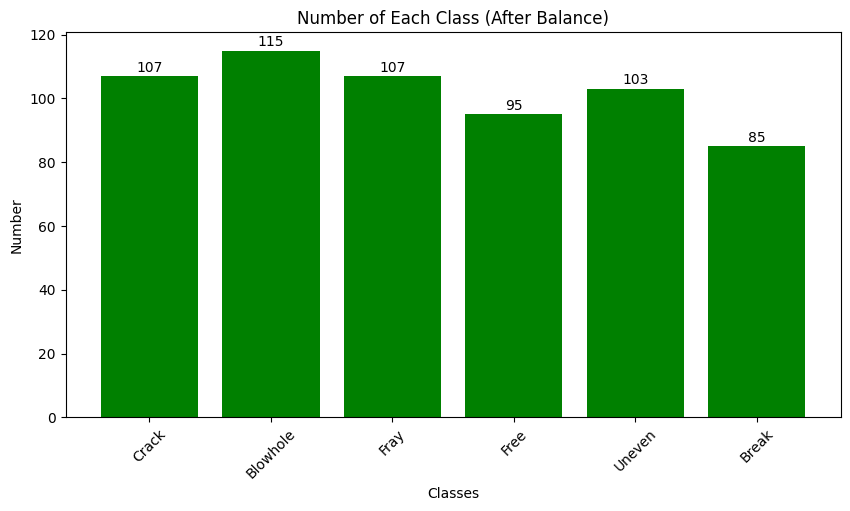

In [1]:
import os
import matplotlib.pyplot as plt

# Directory of images
root_dir = '/Users/surq/workspace/tile_defects/datasets/splited_datasets/original_balanced/images'

# Collecting the number of each classes
folder_names = []
image_counts = []

for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
        # Calculate the number of images in folder
        images = [img for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        folder_names.append(folder)
        image_counts.append(len(images))

# Drawing the histogram
plt.figure(figsize=(10, 5))
bars = plt.bar(folder_names, image_counts, color='green')
plt.xlabel('Classes')
plt.ylabel('Number')
plt.title('Number of Each Class (After Balance)')
plt.xticks(rotation=45)

# Add information
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.show()

## III. Data Preprocessing.

### 1. Create Empty Labels:

#### The Free class is the images without defect, so there is no label file. Because training the classic machine learning models require a label file for every image, the following code is used to create an empty .txt label file with the same name for each Free class image.

In [ ]:
import os

def create_empty_labels(image_folder, label_folder):
    # Ensure the label folder exists, create if it doesn't
    os.makedirs(label_folder, exist_ok=True)

    # List all files in the image folder
    file_list = os.listdir(image_folder)

    # Filter to include only jpg images
    jpg_files = [f for f in file_list if f.endswith('.png')]

    # Create empty txt files corresponding to each jpg file in the new label folder
    for jpg_file in jpg_files:
        # Construct the corresponding txt filename
        txt_filename = os.path.splitext(jpg_file)[0] + '.txt'
        
        # Create and close an empty txt file in the label folder
        with open(os.path.join(label_folder, txt_filename), 'w') as txt_file:
            pass  # The 'pass' statement means nothing happens, thus the file remains empty

    print(f"Created {len(jpg_files)} empty label files in {label_folder}.")

# Example usage:
# Replace 'path_to_your_image_folder' with the actual path to your image folder
# Replace 'path_to_your_label_folder' with the path where you want to store the labels
create_empty_labels('/Users/surq/workspace/train4models/dataset_gt_labeled/images/Free', '/Users/surq/workspace/train4models/dataset_gt_labeled/labels/Free')

### 2. Write Defect Number to Labels:

#### Every label file has one number which represents its defect type, 0 is Blowhole, 1 is Break, 2 is Crack, 3 is Fray, 4 is Uneven and 5 is Free. The following code is used to write defect number 5 in batches into the label file of the Free class.

In [ ]:
import os

# Define the path to the folder containing the label files
label_folder = '/Users/surq/workspace/tile_defects/datasets/splited_datasets/gt/labels/Free'

# Iterate through all files in the label folder
for label_file in os.listdir(label_folder):
    # Construct the full path of the label file
    label_path = os.path.join(label_folder, label_file)

    # Check if it is a file and ends with .txt
    if os.path.isfile(label_path) and label_file.endswith('.txt'):
        # Read the content of the label file
        with open(label_path, 'r') as file:
            content = file.read().strip()

        # Check if the file is empty or contains only whitespace
        if not content:
            # If the file is empty, write '5' to the same file
            with open(label_path, 'w') as file:
                file.write('5')

print("Label files processing complete!")

### 3. Image Scaling Down:

#### The following code is used to scale down the images to a uniform size of 64 x 64 pixels. Note that this code only involves processing the image, not the label, so the path only needs to fill in the input image path and the saved image path.

In [ ]:
import os
from PIL import Image

def process_and_save_image(input_image_path, output_image_path, size=(64, 64)):
    """
    Load an image, convert it to grayscale, resize it, and save it to a new location.

    Parameters:
    - input_image_path (str): The path to the input image file.
    - output_image_path (str): The path to save the processed image.
    - size (tuple): The target size to resize the image (width, height).
    """
    img = Image.open(input_image_path).convert('L')
    img = img.resize(size)
    img.save(output_image_path)

def process_folder(input_folder, output_folder, size=(64, 64)):
    """
    Process all images in subfolders of the input folder and save them to corresponding subfolders in the output folder.

    Parameters:
    - input_folder (str): The path to the main input folder containing subfolders of images.
    - output_folder (str): The path to the main output folder where processed images will be saved.
    - size (tuple): The target size to resize the images (width, height).
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for subdir, _, files in os.walk(input_folder):
        relative_path = os.path.relpath(subdir, input_folder)
        output_subdir = os.path.join(output_folder, relative_path)
        if not os.path.exists(output_subdir):
            os.makedirs(output_subdir)
        
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                input_image_path = os.path.join(subdir, file)
                output_image_path = os.path.join(output_subdir, file)
                process_and_save_image(input_image_path, output_image_path, size)

if __name__ == "__main__":
    # Example usage
    input_folder = '/Users/surq/workspace/train4models/datasets/raw_datasets/gt_dataset_labeled/images'
    output_folder = '/Users/surq/workspace/tile_defects/datasets/splited_datasets/gt/images'
    process_folder(input_folder, output_folder)
    print(f"Processed images saved to {output_folder}")

### 4. Delete Coordinate:

#### Coordinate data cannot be input when training classic machine learning models, so the following code is used to delete the coordinate data in all label files and only keep the defect number. Just write the main folder path of the label file, and the code will automatically traverse all subfolders to find and process the .txt label file.

In [ ]:
import os

def process_labels_in_folder(label_folder):
    # Recursively process all subfolders and files
    for root, dirs, files in os.walk(label_folder):
        for file in files:
            if file.endswith('.txt'):
                label_path = os.path.join(root, file)
                process_single_label(label_path)

def process_single_label(label_path):
    with open(label_path, 'r') as file:
        lines = file.readlines()

    # Check if there are lines in the file
    if lines:
        # Get the first line, split by space to extract the first element (category ID)
        first_line = lines[0].strip().split()
        if first_line:
            # Keep only the first category number (first element)
            new_label = first_line[0]
            
            # Write the new label to the same file, overwrite the original content
            with open(label_path, 'w') as file:
                file.write(new_label + '\n')
    else:
        print(f"Label file {label_path} is empty or has no coordinates.")

if __name__ == "__main__":
    label_folder = "/Users/surq/workspace/final_p/splited_data/otsu_binary/labels"  # Replace with your actual path
    process_labels_in_folder(label_folder)

### 5. Train-Test Split:

#### The images and labels in the dataset are stored in different subfolders according to different defect classes. The following code is used to extract the images and labels in all subfolders and divide them into training and test sets in a ratio of 75% and 25%. Note that in this code, when filling in the input path, you need to fill in the input image folder path and label folder path respectively. When outputting, you only need to fill in a main folder path.

In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Define paths
original_images_folder = '/Users/surq/workspace/final_p/splited_data/wavelet/wavelet_bior_l2/images'
original_labels_folder = '/Users/surq/workspace/final_p/splited_data/wavelet/wavelet_bior_l2/labels'
output_folder = '/Users/surq/workspace/final_p/train_data/wavelet/wavelet_bior_l2'

# Define output folder structure
output_images_folder = os.path.join(output_folder, 'images')
output_labels_folder = os.path.join(output_folder, 'labels')
output_images_train_folder = os.path.join(output_images_folder, 'train')
output_images_test_folder = os.path.join(output_images_folder, 'test')
output_labels_train_folder = os.path.join(output_labels_folder, 'train')
output_labels_test_folder = os.path.join(output_labels_folder, 'test')

# Create target folders
os.makedirs(output_images_train_folder, exist_ok=True)
os.makedirs(output_images_test_folder, exist_ok=True)
os.makedirs(output_labels_train_folder, exist_ok=True)
os.makedirs(output_labels_test_folder, exist_ok=True)

# Get all image and label paths
all_images = []
all_labels = []

for category in os.listdir(original_images_folder):
    category_images_folder = os.path.join(original_images_folder, category)
    category_labels_folder = os.path.join(original_labels_folder, category)
    
    # Ensure we are only working with directories, not files like .DS_Store
    if os.path.isdir(category_images_folder) and os.path.isdir(category_labels_folder):
        # Filter out non-image files like .DS_Store, only process .jpg, .jpeg, and .png files
        images = [os.path.join(category_images_folder, img) for img in os.listdir(category_images_folder) 
                  if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        # Filter out non-label files, only process .txt files
        labels = [os.path.join(category_labels_folder, lbl) for lbl in os.listdir(category_labels_folder) if lbl.endswith('.txt')]
        
        all_images.extend(images)
        all_labels.extend(labels)

# Ensure images and labels are sorted and match by name
all_images.sort()
all_labels.sort()

# Debugging: Print number of images and labels to ensure consistency
print(f"Number of images: {len(all_images)}")
print(f"Number of labels: {len(all_labels)}")

# Check if lists are empty
if len(all_images) == 0 or len(all_labels) == 0:
    raise ValueError("No images or labels found. Please check the folders and file types.")

# Split the dataset into 75% training and 25% testing sets
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.25, random_state=42)

# Function to copy files to the destination folder
def copy_files(file_list, dest_folder):
    for file in file_list:
        shutil.copy(file, dest_folder)

# Copy images and labels to new folders
copy_files(train_images, output_images_train_folder)
copy_files(test_images, output_images_test_folder)
copy_files(train_labels, output_labels_train_folder)
copy_files(test_labels, output_labels_test_folder)

print("Dataset splitting and copying completed!")

### 6. Data Preprocessing Completed:

#### The dataset provided by the paper's authors has become our new ORIGINAL DATASET after the above processing. All subsequent training and improvements are based on this original dataset.

## IV. Training on the Original Dataset.

### 1. Introduction:

#### Below is the code for training models, which are SVM, CNN and KNN. You only need to fill in the main folder path of the dataset in the code, and the code will automatically traverse and find the images and labels in it. Then you need to specify a path to save the model for subsequent generation of ROC graph and PR graph for all models. After the training is completed, all performance values, training time, confusion matrix and ROC graph and PR graph of a single model will be displayed.

### 2. SVM - Original Dataset:

Training Time: 0.37119 seconds
Model saved as /Users/surq/workspace/final_p/models/original/svm_model.pkl
Accuracy: 0.84314
Precision: 0.85032
Recall: 0.80568
F1 Score: 0.81025


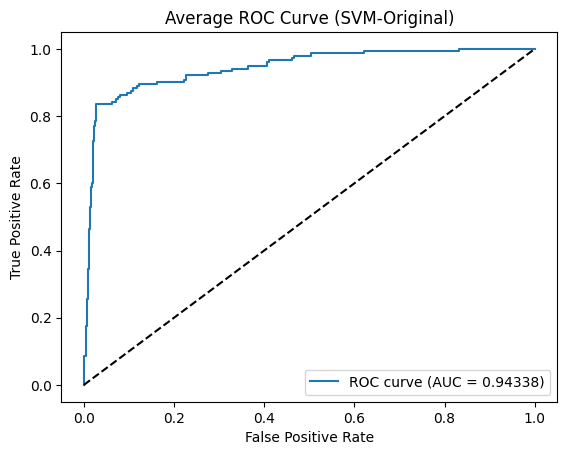

AUC (ROC): 0.94338


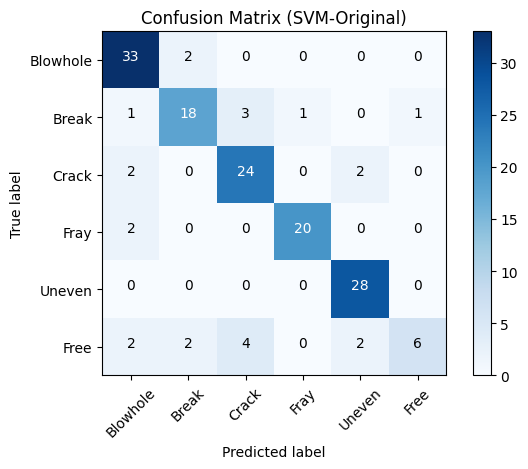

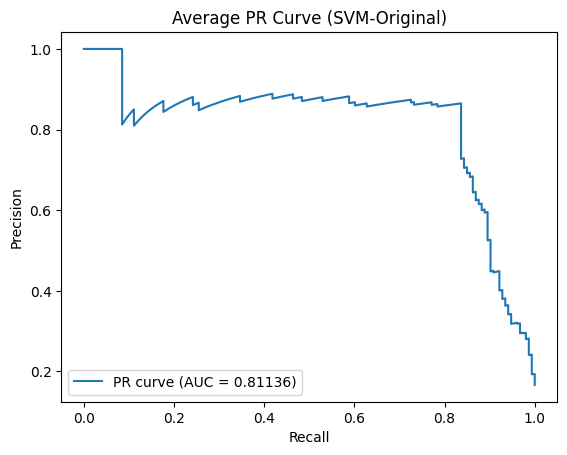

In [2]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (SVM-Original)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (SVM-Original)')
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (SVM-Original)')
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.decision_function(X)  # Get decision scores for each class
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/train_data/sd_64'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)  # Enable probability output for AUC calculation
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    svm_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/original/svm_model.pkl'  # Specify your desired path here
    
    # Save the trained model
    joblib.dump(svm_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(svm_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 3. CNN - Original Dataset:

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.1189 - loss: 1.7994 - val_accuracy: 0.1438 - val_loss: 1.7918 - learning_rate: 3.5000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.1976 - loss: 1.7893 - val_accuracy: 0.2353 - val_loss: 1.7929 - learning_rate: 3.5000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.2659 - loss: 1.7812 - val_accuracy: 0.1699 - val_loss: 1.7855 - learning_rate: 3.5000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.2904 - loss: 1.7689 - val_accuracy: 0.2876 - val_loss: 1.7269 - learning_rate: 3.5000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.2716 - loss: 1.7335 - val_accuracy: 0.4314 - val_loss: 1.6477 - learning_rate: 3.5000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.3635 - loss: 1.6390 - val_accuracy: 0.3856 - val_loss: 1.5773 - learning_rate: 3.5000e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 

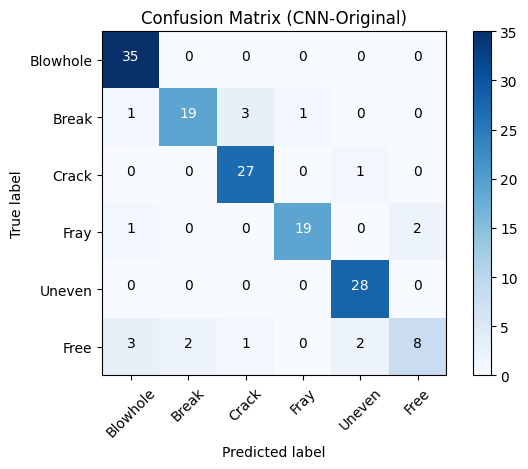

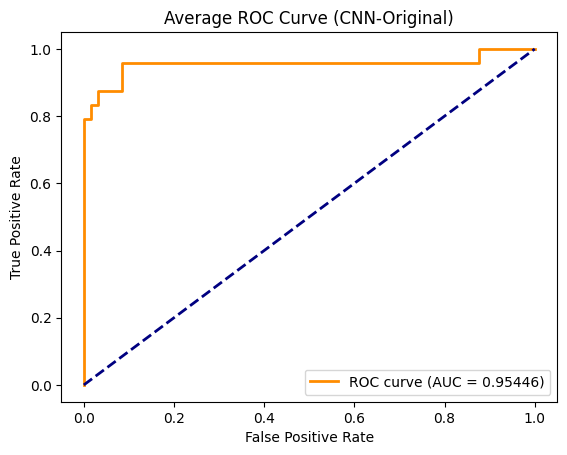

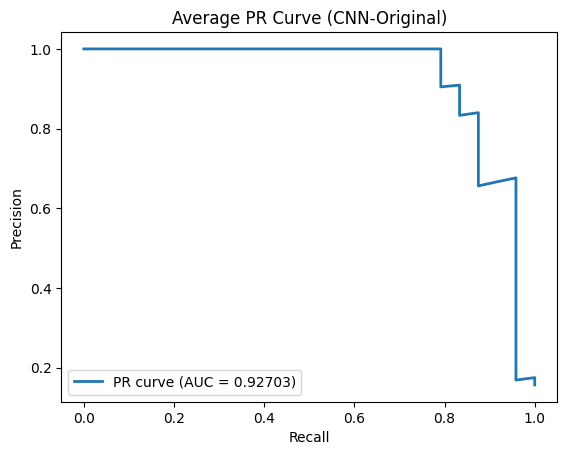


Model saved as /Users/surq/workspace/final_p/models/original/cnn_model.keras

Training time: 79.58292 seconds


In [4]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import itertools

# Function to load dataset
def load_dataset(main_folder_path):
    images_train, labels_train, images_test, labels_test = [], [], [], []
    
    # Define paths
    images_train_path = os.path.join(main_folder_path, 'images', 'train')
    labels_train_path = os.path.join(main_folder_path, 'labels', 'train')
    images_test_path = os.path.join(main_folder_path, 'images', 'test')
    labels_test_path = os.path.join(main_folder_path, 'labels', 'test')
    
    # Load training data
    for label_file in os.listdir(labels_train_path):
        label = int(open(os.path.join(labels_train_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(os.path.join(images_train_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_train_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_train.append(img.numpy())
        labels_train.append(label)
    
    # Load test data
    for label_file in os.listdir(labels_test_path):
        label = int(open(os.path.join(labels_test_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(os.path.join(images_test_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_test_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_test.append(img.numpy())
        labels_test.append(label)
    
    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)

# Define a CNN model
def create_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00035),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (CNN-Original)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Main program
if __name__ == '__main__':
    main_folder_path = '/Users/surq/workspace/final_p/train_data/sd_64'
    
    # Load dataset
    x_train, y_train, x_test, y_test = load_dataset(main_folder_path)
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # Create and train model
    model = create_cnn_model()
    start_time = time.time()
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[lr_scheduler])
    training_time = time.time() - start_time

    # Evaluate model
    y_pred_prob = model.predict(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Generate evaluation metrics
    overall_accuracy = accuracy_score(y_test, y_pred)
    overall_precision = precision_score(y_test, y_pred, average='weighted')
    overall_recall = recall_score(y_test, y_pred, average='weighted')
    overall_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\nOverall Accuracy: {overall_accuracy:.5f}")
    print(f"Overall Precision: {overall_precision:.5f}")
    print(f"Overall Recall: {overall_recall:.5f}")
    print(f"Overall F1 Score: {overall_f1:.5f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free'])

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (CNN-Original)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label='PR curve (AUC = {:.5f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (CNN-Original)')
    plt.legend(loc="lower left")
    plt.show()

    # Save model
    model_save_path = '/Users/surq/workspace/final_p/models/original/cnn_model.keras'  # Specify your desired path here
    model.save(model_save_path)
    print(f"\nModel saved as {model_save_path}")
    
    # Output training time
    print(f"\nTraining time: {training_time:.5f} seconds")

### 4. KNN - Original Dataset:

Accuracy: 0.40523
Precision: 0.43722
Recall: 0.41323
F1 Score: 0.38556
Training Time: 0.00246 seconds


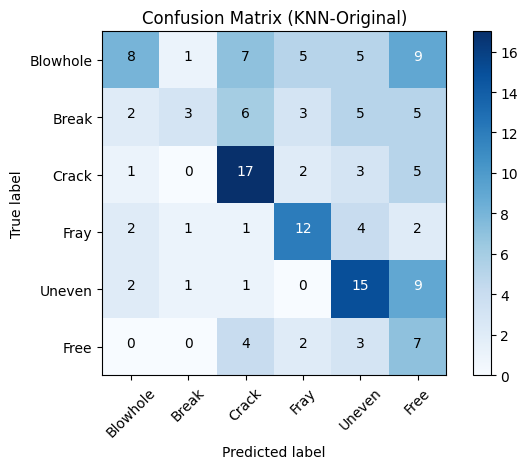

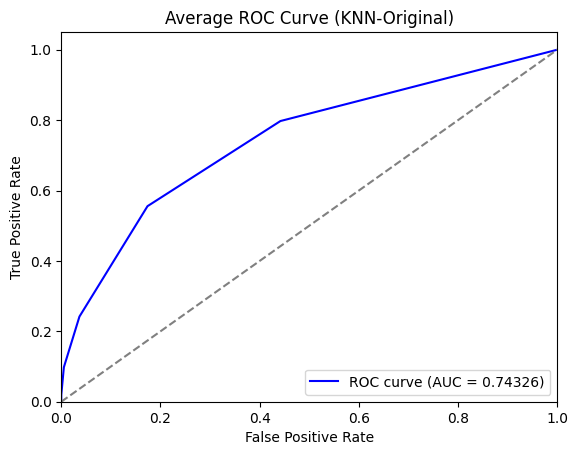

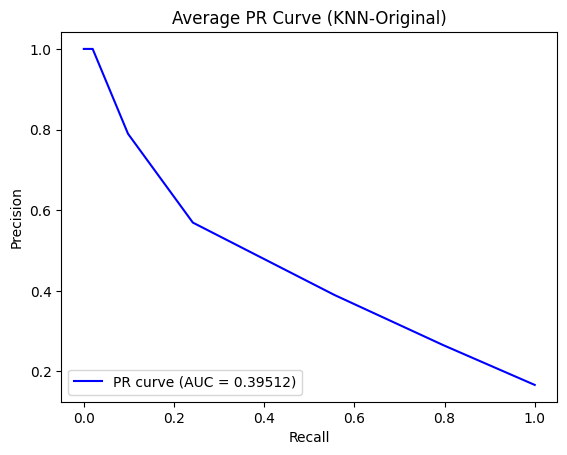

Model saved as /Users/surq/workspace/final_p/models/original/knn_model.pkl


In [5]:
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import time
import joblib  # For saving the model
import itertools

# Load dataset from the given main folder path
def load_dataset(main_folder):
    image_folder = os.path.join(main_folder, 'images')
    label_folder = os.path.join(main_folder, 'labels')

    images_train = []
    labels_train = []
    images_test = []
    labels_test = []

    # Load train images and labels
    train_image_folder = os.path.join(image_folder, 'train')
    train_label_folder = os.path.join(label_folder, 'train')
    for filename in os.listdir(train_image_folder):
        if filename.endswith(('.jpg', '.png')):
            base_name = os.path.splitext(filename)[0]
            label_path = os.path.join(train_label_folder, base_name + '.txt')
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as file:
                defect_type = int(file.readline().strip())

            img_path = os.path.join(train_image_folder, filename)
            img = np.array(Image.open(img_path).convert('L').resize((64, 64)))  # Load and resize image
            images_train.append(img.flatten())  # Flatten the image
            labels_train.append(defect_type)
    
    # Load test images and labels
    test_image_folder = os.path.join(image_folder, 'test')
    test_label_folder = os.path.join(label_folder, 'test')
    for filename in os.listdir(test_image_folder):
        if filename.endswith(('.jpg', '.png')):
            base_name = os.path.splitext(filename)[0]
            label_path = os.path.join(test_label_folder, base_name + '.txt')
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as file:
                defect_type = int(file.readline().strip())

            img_path = os.path.join(test_image_folder, filename)
            img = np.array(Image.open(img_path).convert('L').resize((64, 64)))  # Load and resize image
            images_test.append(img.flatten())  # Flatten the image
            labels_test.append(defect_type)

    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (KNN-Original)')
    plt.colorbar()  # Display color bar
    tick_marks = np.arange(len(classes))  # Tick marks for the labels
    plt.xticks(tick_marks, classes, rotation=45)  # Label x axis with classes
    plt.yticks(tick_marks, classes)  # Label y axis with classes
    
    fmt = 'd'  # Format the numbers in the matrix
    thresh = cm.max() / 2  # Define a threshold for coloring text
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),  # Format as integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")  # Choose text color based on threshold

    plt.ylabel('True label')  # Label y-axis
    plt.xlabel('Predicted label')  # Label x-axis
    plt.tight_layout()  # Adjust layout to avoid overlapping
    plt.show()  # Display the plot

# Train and evaluate KNN model
def train_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    # Start measuring the training time
    start_time = time.time()

    knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=n_neighbors))
    knn.fit(X_train, y_train)

    # End measuring the training time
    end_time = time.time()
    training_time = end_time - start_time
    
    # Predict on the test set
    y_pred = knn.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"F1 Score: {f1:.5f}")
    print(f"Training Time: {training_time:.5f} seconds")  # Show time with 5 decimal places

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free'])

    # ROC curve and AUC
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])  # Binarize the labels
    y_pred_prob = knn.predict_proba(X_test)  # Get probabilities for each class
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (KNN-Original)')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    pr_auc = average_precision_score(y_test_bin, y_pred_prob, average="macro")

    plt.figure()
    plt.plot(recall, precision, color='b', label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (KNN-Original)')
    plt.legend(loc='lower left')
    plt.show()

    # Save the model
    model_save_path = '/Users/surq/workspace/final_p/models/original/knn_model.pkl'  # Modify this to the desired path
    joblib.dump(knn, model_save_path)  # Save the trained model
    print(f"Model saved as {model_save_path}")

# Main function
def main():
    main_folder = '/Users/surq/workspace/final_p/train_data/sd_64'  # Modify this path if needed

    # Load dataset
    X_train, y_train, X_test, y_test = load_dataset(main_folder)

    # Train and evaluate KNN model
    train_knn(X_train, y_train, X_test, y_test)

if __name__ == "__main__":
    main()

### 5. Random Forest - Original Dataset:

Training Time: 0.83592 seconds
Model saved as /Users/surq/workspace/final_p/models/original/rf_model.pkl
Accuracy: 0.54902
Precision: 0.53239
Recall: 0.54150
F1 Score: 0.53426


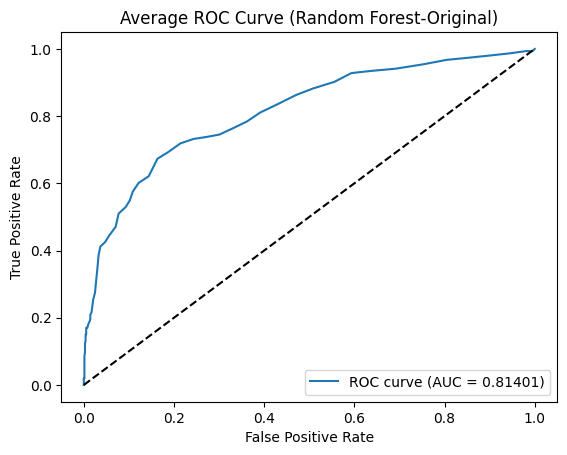

AUC (ROC): 0.81401


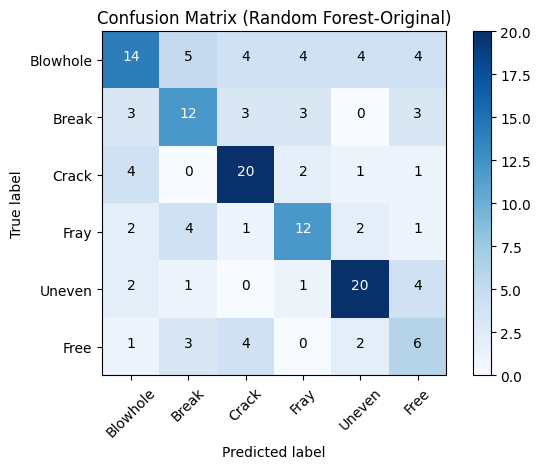

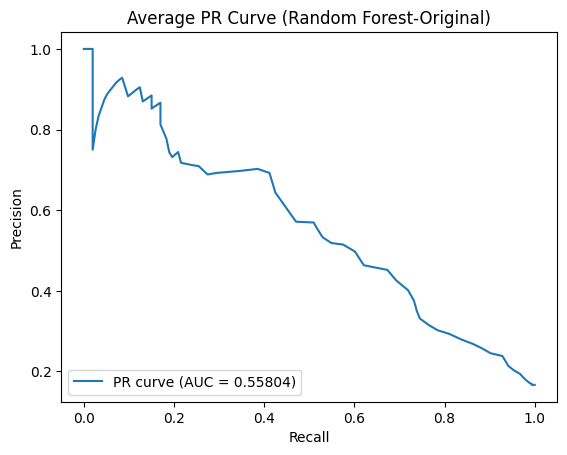

In [7]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Random Forest-Original)')  
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (Random Forest-Original)') 
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (Random Forest-Original)') 
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)  # Use the predict_proba to get probabilities.
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/train_data/sd_64'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    # Create a random forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/original/rf_model.pkl'
    
    # Save the trained model
    joblib.dump(rf_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(rf_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 6. Decision Tree - Original Dataset:

Training Time: 0.74024 seconds
Model saved as /Users/surq/workspace/final_p/models/original/dt_model.pkl
Accuracy: 0.35948
Precision: 0.34592
Recall: 0.35297
F1 Score: 0.34412


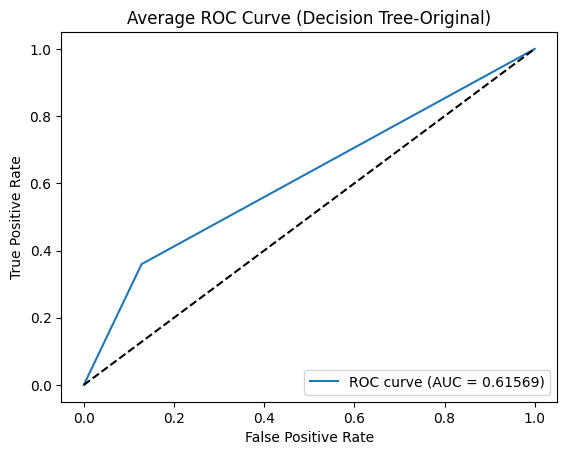

AUC (ROC): 0.61569


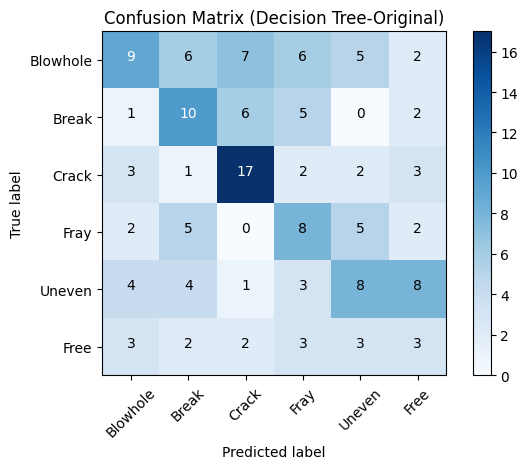

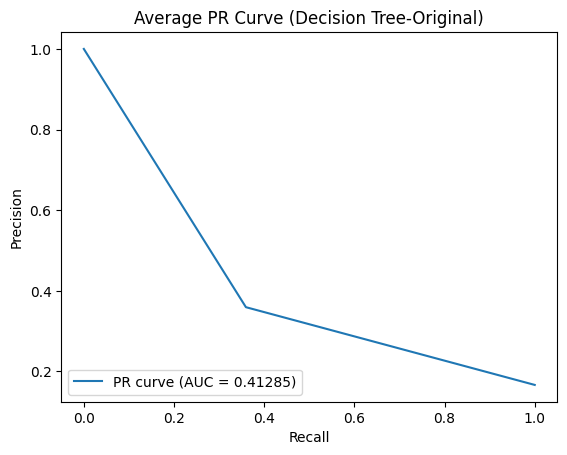

In [8]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Decision Tree-Original)')  
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (Decision Tree-Original)') 
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (Decision Tree-Original)') 
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)  # Use the predict_proba to get probabilities.
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/train_data/sd_64'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    # Create a decision tree model
    dt_model = DecisionTreeClassifier(random_state=42)  # Changed to DecisionTreeClassifier
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    dt_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/original/dt_model.pkl'  # Changed the model name to dt_model.pkl
    
    # Save the trained model
    joblib.dump(dt_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(dt_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 7. ROC Curve and P-R Curve of Original Dataset:

#### The following code is used to generate the ROC curve and P-R curve of the above 5 models for comparison. The path of the dataset still needs to be filled in the path of the main dataset folder, and then the code will automatically find the images and labels of the test set. The above 5 training codes all save the trained models. In the following code, you need to fill in the path of each saved model.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


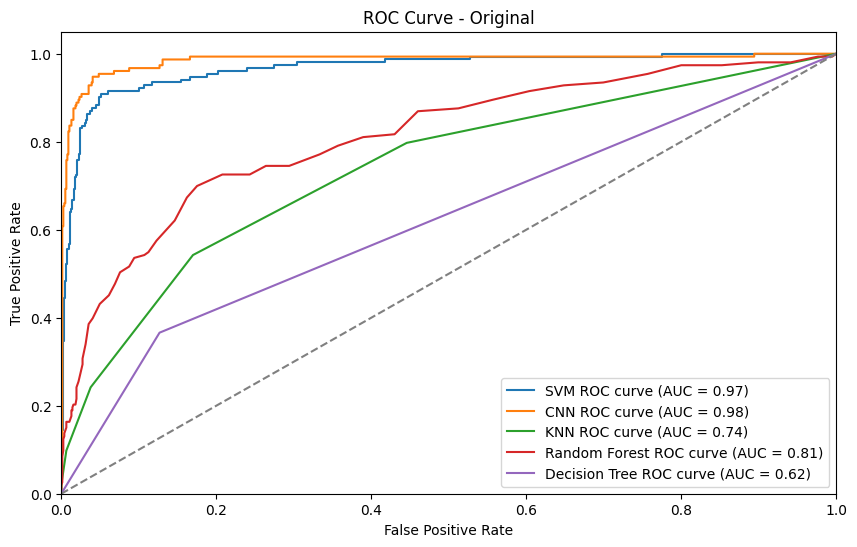

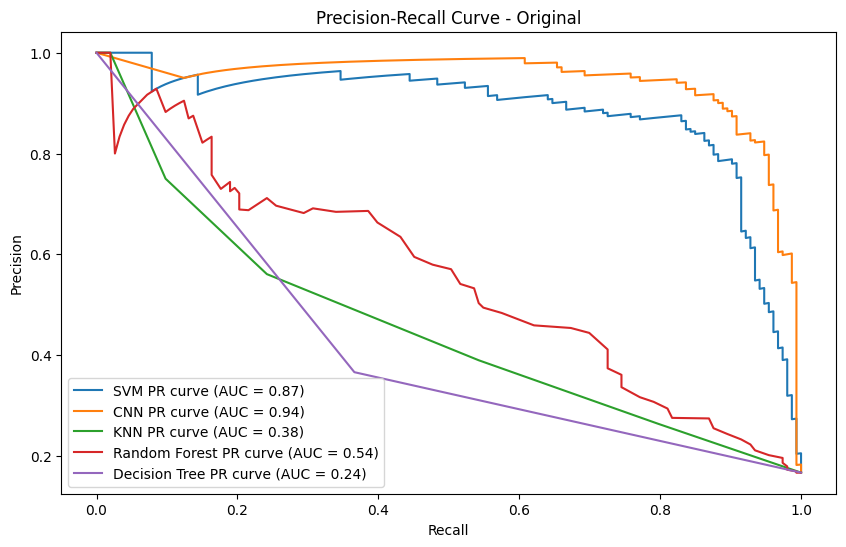

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import joblib
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import itertools


# Function to load dataset
def load_dataset(main_folder_path):
    images_train, labels_train, images_test, labels_test = [], [], [], []

    # Define paths
    images_train_path = os.path.join(main_folder_path, 'images', 'train')
    labels_train_path = os.path.join(main_folder_path, 'labels', 'train')
    images_test_path = os.path.join(main_folder_path, 'images', 'test')
    labels_test_path = os.path.join(main_folder_path, 'labels', 'test')

    # Load training data
    for label_file in os.listdir(labels_train_path):
        label = int(open(os.path.join(labels_train_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(
            os.path.join(images_train_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_train_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_train.append(img.numpy())
        labels_train.append(label)

    # Load test data
    for label_file in os.listdir(labels_test_path):
        label = int(open(os.path.join(labels_test_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(
            os.path.join(images_test_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_test_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_test.append(img.numpy())
        labels_test.append(label)

    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)


if __name__ == "__main__":
    main_folder_path = '/Users/surq/workspace/final_p/train_data/sd_64'

    # Load dataset
    x_train, y_train, x_test, y_test = load_dataset(main_folder_path)
    x_test_cnn = x_test / 255.0  # Normalize for CNN
    x_test_svm_knn = x_test.reshape(x_test.shape[0], -1)  # Flatten for SVM and KNN

    # Load models
    # SVM model
    svm_model_path = '/Users/surq/workspace/final_p/models/original/svm_model.pkl'
    svm_model = joblib.load(svm_model_path)

    # CNN model
    cnn_model_path = '/Users/surq/workspace/final_p/models/original/cnn_model.keras'
    cnn_model = tf.keras.models.load_model(cnn_model_path)

    # KNN model
    knn_model_path = '/Users/surq/workspace/final_p/models/original/knn_model.pkl'
    knn_model = joblib.load(knn_model_path)

    # Random Forest model
    rf_model_path = '/Users/surq/workspace/final_p/models/original/rf_model.pkl'
    rf_model = joblib.load(rf_model_path)

    # Decision Tree model
    dt_model_path = '/Users/surq/workspace/final_p/models/original/dt_model.pkl'
    dt_model = joblib.load(dt_model_path)

    # Binarize labels
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

    # Generate predictions and probabilities for each model
    # SVM
    svm_y_pred_prob = svm_model.predict_proba(x_test_svm_knn)

    # CNN
    cnn_y_pred_prob = cnn_model.predict(x_test_cnn)

    # KNN
    knn_y_pred_prob = knn_model.predict_proba(x_test_svm_knn)

    # Random Forest
    rf_y_pred_prob = rf_model.predict_proba(x_test_svm_knn)

    # Decision Tree
    dt_y_pred_prob = dt_model.predict_proba(x_test_svm_knn)

    # Calculate and plot ROC curves
    plt.figure(figsize=(10, 6))
    # SVM ROC
    svm_fpr, svm_tpr, _ = roc_curve(y_test_bin.ravel(), svm_y_pred_prob.ravel())
    svm_roc_auc = auc(svm_fpr, svm_tpr)
    plt.plot(svm_fpr, svm_tpr, label=f'SVM ROC curve (AUC = {svm_roc_auc:.2f})')

    # CNN ROC
    cnn_fpr, cnn_tpr, _ = roc_curve(y_test_bin.ravel(), cnn_y_pred_prob.ravel())
    cnn_roc_auc = auc(cnn_fpr, cnn_tpr)
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN ROC curve (AUC = {cnn_roc_auc:.2f})')

    # KNN ROC
    knn_fpr, knn_tpr, _ = roc_curve(y_test_bin.ravel(), knn_y_pred_prob.ravel())
    knn_roc_auc = auc(knn_fpr, knn_tpr)
    plt.plot(knn_fpr, knn_tpr, label=f'KNN ROC curve (AUC = {knn_roc_auc:.2f})')

    # Random Forest ROC
    rf_fpr, rf_tpr, _ = roc_curve(y_test_bin.ravel(), rf_y_pred_prob.ravel())
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    plt.plot(rf_fpr, rf_tpr, label=f'Random Forest ROC curve (AUC = {rf_roc_auc:.2f})')

    # Decision Tree ROC
    dt_fpr, dt_tpr, _ = roc_curve(y_test_bin.ravel(), dt_y_pred_prob.ravel())
    dt_roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree ROC curve (AUC = {dt_roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Original')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate and plot PR curves
    plt.figure(figsize=(10, 6))
    # SVM PR
    svm_precision, svm_recall, _ = precision_recall_curve(y_test_bin.ravel(), svm_y_pred_prob.ravel())
    svm_pr_auc = average_precision_score(y_test_bin, svm_y_pred_prob, average="macro")
    plt.plot(svm_recall, svm_precision, label=f'SVM PR curve (AUC = {svm_pr_auc:.2f})')

    # CNN PR
    cnn_precision, cnn_recall, _ = precision_recall_curve(y_test_bin.ravel(), cnn_y_pred_prob.ravel())
    cnn_pr_auc = average_precision_score(y_test_bin, cnn_y_pred_prob, average="macro")
    plt.plot(cnn_recall, cnn_precision, label=f'CNN PR curve (AUC = {cnn_pr_auc:.2f})')

    # KNN PR
    knn_precision, knn_recall, _ = precision_recall_curve(y_test_bin.ravel(), knn_y_pred_prob.ravel())
    knn_pr_auc = average_precision_score(y_test_bin, knn_y_pred_prob, average="macro")
    plt.plot(knn_recall, knn_precision, label=f'KNN PR curve (AUC = {knn_pr_auc:.2f})')

    # Random Forest PR
    rf_precision, rf_recall, _ = precision_recall_curve(y_test_bin.ravel(), rf_y_pred_prob.ravel())
    rf_pr_auc = average_precision_score(y_test_bin, rf_y_pred_prob, average="macro")
    plt.plot(rf_recall, rf_precision, label=f'Random Forest PR curve (AUC = {rf_pr_auc:.2f})')

    # Decision Tree PR
    dt_precision, dt_recall, _ = precision_recall_curve(y_test_bin.ravel(), dt_y_pred_prob.ravel())
    dt_pr_auc = average_precision_score(y_test_bin, dt_y_pred_prob, average="macro")
    plt.plot(dt_recall, dt_precision, label=f'Decision Tree PR curve (AUC = {dt_pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Original')
    plt.legend(loc='lower left')
    plt.show()

## V. Training on the Otsu Binary Only Dataset.

### 1. Introduction:

#### This section trains the original dataset binarized by Otsu's method. First, use the code in 2. to binarize the original dataset and display the binarization processing time. Then, each model is trained separately. When the performance values are entered into the table at the end, the binarization processing time is added to the training time of each model as the final training time. Note that you need to change the input path to the path of the binarized dataset in the training code of each model.

### 2. Otsu Binary:

#### The following code is used to binarize the image. When filling in the input and output paths, you need to fill in the paths of the image and label respectively. This code will also change the names of the image and label after the image is processed. For example, if the image in the original dataset is named "exp0_num_797.jpg", the name of the image after processing will be changed to "exp0_bin_797.jpg", and the same for the name of the label. This is to better distinguish different datasets and can be trained together with the original dataset. After processing, the code will generate the processing time of the binarization.

In [4]:
import cv2
import os
import numpy as np
import time

# Convert the entire image to binary using Otsu's thresholding
def convert_image_to_binary(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was successfully loaded
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return None

    # Apply Otsu's thresholding directly
    _, binary_image = cv2.threshold(
        image, 0, 255, 
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    return binary_image

# Traverse the directory, convert images to binary using Otsu's thresholding, and save them
# Also rename files by replacing 'num' with 'bin'
def process_images(image_dir, label_dir, output_image_dir, output_label_dir):
    # Record start time
    start_time = time.time()
    
    # Walk through all files in the image directory, including subdirectories
    for root, _, files in os.walk(image_dir):
        for file in files:
            # Process only common image formats
            if file.endswith(('.jpg', '.png', '.jpeg')):  
                # Build the full path to the input image file
                image_path = os.path.join(root, file)
                
                # Build the corresponding label file path based on the relative directory structure
                relative_path = os.path.relpath(root, image_dir)
                base_name = os.path.splitext(file)[0]
                label_path = os.path.join(label_dir, relative_path, base_name + '.txt')
                
                # Build output folder paths for images and labels (keeping the original directory structure)
                output_image_folder_path = os.path.join(output_image_dir, relative_path)
                output_label_folder_path = os.path.join(output_label_dir, relative_path)
                
                # Create output folders if they do not exist
                os.makedirs(output_image_folder_path, exist_ok=True)
                os.makedirs(output_label_folder_path, exist_ok=True)
                
                # Modify the file name by replacing 'num' with 'bin'
                modified_file_name = file.replace('num', 'bin')
                modified_base_name = base_name.replace('num', 'bin')

                # Build the full path for the output image and label files
                output_image_file_path = os.path.join(output_image_folder_path, modified_file_name)
                output_label_file_path = os.path.join(output_label_folder_path, modified_base_name + '.txt')
                
                # Check if the label file exists
                if os.path.exists(label_path):
                    # Read the label file to determine if this image is defect-free (class '5')
                    with open(label_path, 'r') as label_file:
                        label_content = label_file.read().strip()
                        
                        # Read the original image in grayscale to get its dimensions
                        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                        if image is None:
                            print(f"Skipping {image_path} due to read error.")
                            continue
                        
                        # If the label is '5', create an all-black image with the same dimensions
                        if label_content == '5':
                            height, width = image.shape
                            binary_image = np.zeros((height, width), dtype=np.uint8)
                        else:
                            # Convert the entire image to binary
                            binary_image = convert_image_to_binary(image_path)
                            if binary_image is None:  # Check if conversion was successful
                                print(f"Skipping {image_path} due to read error.")
                                continue
                else:
                    print(f"Skipping {image_path} due to missing label file.")
                    continue
                
                # Save the binary image
                cv2.imwrite(output_image_file_path, binary_image)
                print(f'Saved binary image: {output_image_file_path}')
                
                # Copy the original label file to the output label folder with the modified name
                with open(label_path, 'r') as label_file, open(output_label_file_path, 'w') as output_label_file:
                    output_label_file.write(label_file.read())
                    print(f'Saved label file: {output_label_file_path}')
    
    # Record end time and print the elapsed time
    end_time = time.time()
    print(f"Processing completed, total time: {end_time - start_time:.2f} seconds")

# Specify the input and output directory paths
image_directory = '/Users/surq/workspace/final_p/train_data/sd_64/images'
label_directory = '/Users/surq/workspace/final_p/train_data/sd_64/labels'
output_image_directory = '/Users/surq/workspace/final_p/otsu_dataset/images'
output_label_directory = '/Users/surq/workspace/final_p/otsu_dataset/labels'

# Call the function to process images using Otsu's thresholding
process_images(image_directory, label_directory, output_image_directory, output_label_directory)

Saved binary image: /Users/surq/workspace/final_p/otsu_dataset/images/test/exp4_bin_3554.jpg
Saved label file: /Users/surq/workspace/final_p/otsu_dataset/labels/test/exp4_bin_3554.txt
Saved binary image: /Users/surq/workspace/final_p/otsu_dataset/images/test/exp2_bin_129056.jpg
Saved label file: /Users/surq/workspace/final_p/otsu_dataset/labels/test/exp2_bin_129056.txt
Saved binary image: /Users/surq/workspace/final_p/otsu_dataset/images/test/exp1_bin_346311.jpg
Saved label file: /Users/surq/workspace/final_p/otsu_dataset/labels/test/exp1_bin_346311.txt
Saved binary image: /Users/surq/workspace/final_p/otsu_dataset/images/test/exp5_bin_242089.jpg
Saved label file: /Users/surq/workspace/final_p/otsu_dataset/labels/test/exp5_bin_242089.txt
Saved binary image: /Users/surq/workspace/final_p/otsu_dataset/images/test/bright_exp6_bin_972.jpg
Saved label file: /Users/surq/workspace/final_p/otsu_dataset/labels/test/bright_exp6_bin_972.txt
Saved binary image: /Users/surq/workspace/final_p/otsu_d

### 3. SVM - Ostu Binary Only:

Training Time: 0.24065 seconds
Model saved as /Users/surq/workspace/final_p/models/otsu/svm_model.pkl
Accuracy: 0.93464
Precision: 0.94940
Recall: 0.93310
F1 Score: 0.93610


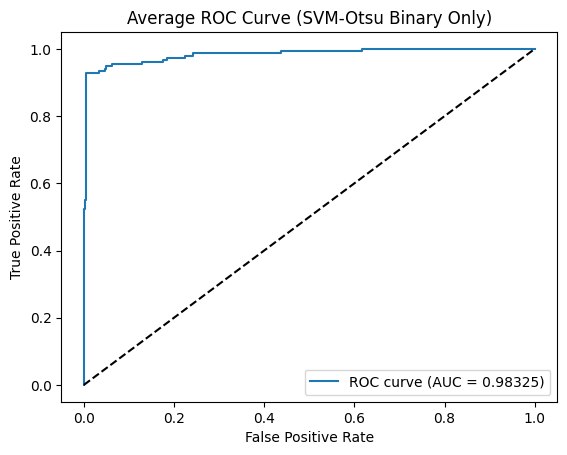

AUC (ROC): 0.98325


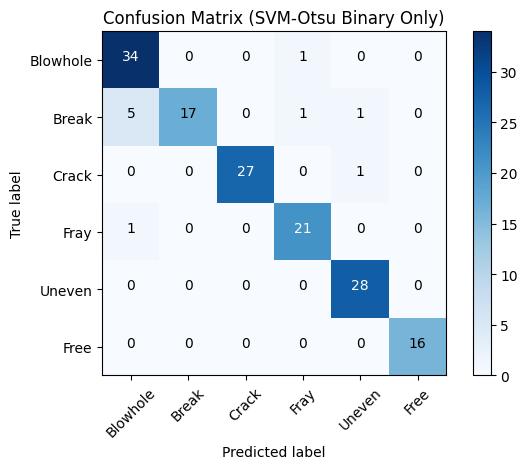

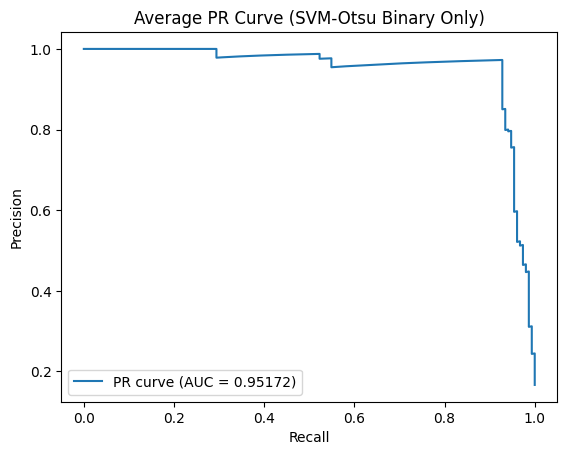

In [11]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (SVM-Otsu Binary Only)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (SVM-Otsu Binary Only)')
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (SVM-Otsu Binary Only)')
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.decision_function(X)  # Get decision scores for each class
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/otsu_dataset'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)  # Enable probability output for AUC calculation
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    svm_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/otsu/svm_model.pkl'  # Specify your desired path here
    
    # Save the trained model
    joblib.dump(svm_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(svm_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 4. CNN - Otsu Binary Only:

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.2375 - loss: 1.6962 - val_accuracy: 0.5817 - val_loss: 1.3077 - learning_rate: 3.5000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5558 - loss: 1.3206 - val_accuracy: 0.6732 - val_loss: 1.0569 - learning_rate: 3.5000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.7045 - loss: 0.8614 - val_accuracy: 0.7190 - val_loss: 0.6942 - learning_rate: 3.5000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8365 - loss: 0.5214 - val_accuracy: 0.8562 - val_loss: 0.4335 - learning_rate: 3.5000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9187 - loss: 0.2563 - val_accuracy: 0.8758 - val_loss: 0.4256 - learning_rate: 3.5000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9306 - loss: 0.2069 - val_accuracy: 0.8758 - val_loss: 0.4403 - learning_rate: 3.5000e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 

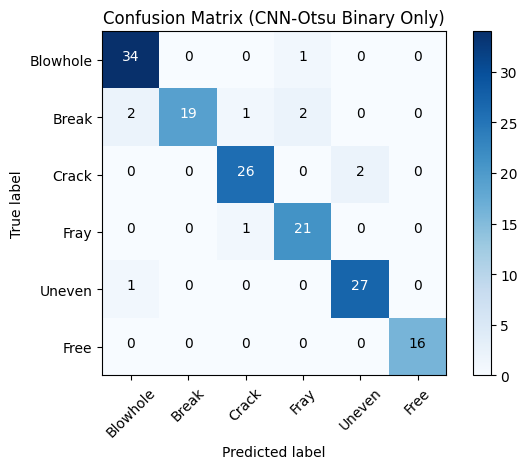

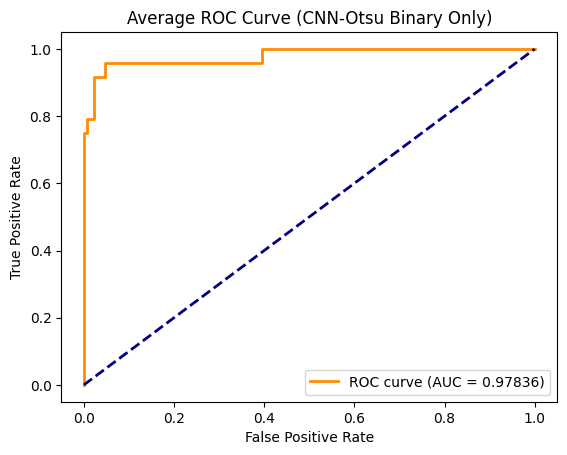

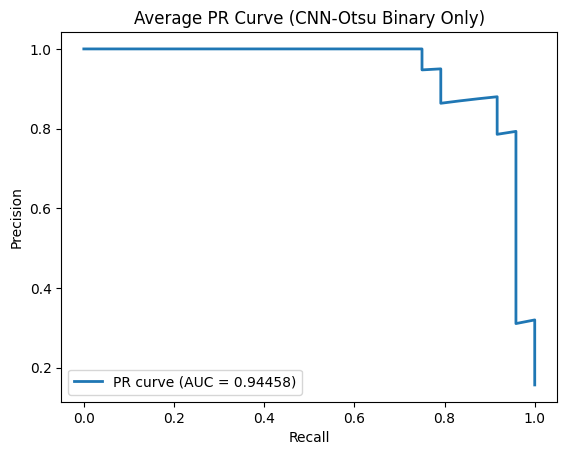


Model saved as /Users/surq/workspace/final_p/models/otsu/cnn_model.keras

Training time: 78.96620 seconds


In [12]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import itertools

# Function to load dataset
def load_dataset(main_folder_path):
    images_train, labels_train, images_test, labels_test = [], [], [], []
    
    # Define paths
    images_train_path = os.path.join(main_folder_path, 'images', 'train')
    labels_train_path = os.path.join(main_folder_path, 'labels', 'train')
    images_test_path = os.path.join(main_folder_path, 'images', 'test')
    labels_test_path = os.path.join(main_folder_path, 'labels', 'test')
    
    # Load training data
    for label_file in os.listdir(labels_train_path):
        label = int(open(os.path.join(labels_train_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(os.path.join(images_train_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_train_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_train.append(img.numpy())
        labels_train.append(label)
    
    # Load test data
    for label_file in os.listdir(labels_test_path):
        label = int(open(os.path.join(labels_test_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(os.path.join(images_test_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_test_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_test.append(img.numpy())
        labels_test.append(label)
    
    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)

# Define a CNN model
def create_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00035),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (CNN-Otsu Binary Only)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Main program
if __name__ == '__main__':
    main_folder_path = '/Users/surq/workspace/final_p/otsu_dataset'
    
    # Load dataset
    x_train, y_train, x_test, y_test = load_dataset(main_folder_path)
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # Create and train model
    model = create_cnn_model()
    start_time = time.time()
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[lr_scheduler])
    training_time = time.time() - start_time

    # Evaluate model
    y_pred_prob = model.predict(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Generate evaluation metrics
    overall_accuracy = accuracy_score(y_test, y_pred)
    overall_precision = precision_score(y_test, y_pred, average='weighted')
    overall_recall = recall_score(y_test, y_pred, average='weighted')
    overall_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\nOverall Accuracy: {overall_accuracy:.5f}")
    print(f"Overall Precision: {overall_precision:.5f}")
    print(f"Overall Recall: {overall_recall:.5f}")
    print(f"Overall F1 Score: {overall_f1:.5f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free'])

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (CNN-Otsu Binary Only)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label='PR curve (AUC = {:.5f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (CNN-Otsu Binary Only)')
    plt.legend(loc="lower left")
    plt.show()

    # Save model
    model_save_path = '/Users/surq/workspace/final_p/models/otsu/cnn_model.keras'  # Specify your desired path here
    model.save(model_save_path)
    print(f"\nModel saved as {model_save_path}")
    
    # Output training time
    print(f"\nTraining time: {training_time:.5f} seconds")

### 5. KNN - Otsu Binary Only:

Accuracy: 0.81699
Precision: 0.81132
Recall: 0.82953
F1 Score: 0.81014
Training Time: 0.00225 seconds


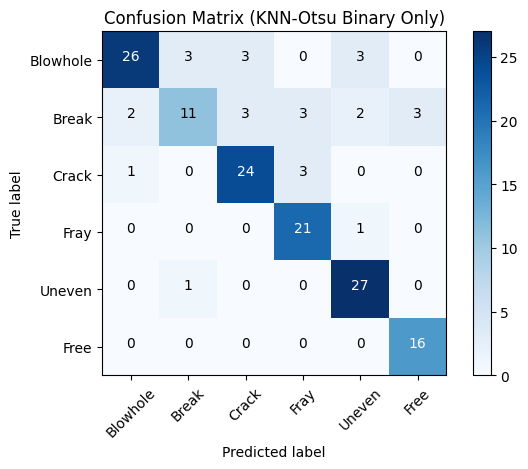

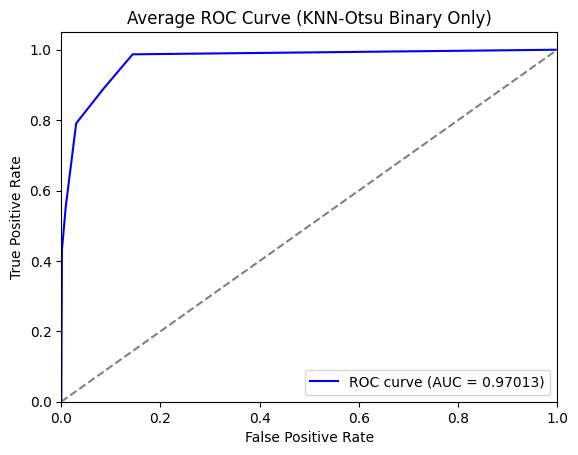

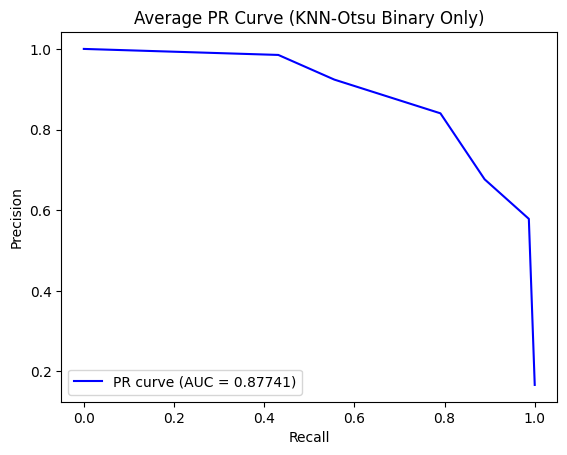

Model saved as /Users/surq/workspace/final_p/models/otsu/knn_model.pkl


In [13]:
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import time
import joblib  # For saving the model
import itertools

# Load dataset from the given main folder path
def load_dataset(main_folder):
    image_folder = os.path.join(main_folder, 'images')
    label_folder = os.path.join(main_folder, 'labels')

    images_train = []
    labels_train = []
    images_test = []
    labels_test = []

    # Load train images and labels
    train_image_folder = os.path.join(image_folder, 'train')
    train_label_folder = os.path.join(label_folder, 'train')
    for filename in os.listdir(train_image_folder):
        if filename.endswith(('.jpg', '.png')):
            base_name = os.path.splitext(filename)[0]
            label_path = os.path.join(train_label_folder, base_name + '.txt')
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as file:
                defect_type = int(file.readline().strip())

            img_path = os.path.join(train_image_folder, filename)
            img = np.array(Image.open(img_path).convert('L').resize((64, 64)))  # Load and resize image
            images_train.append(img.flatten())  # Flatten the image
            labels_train.append(defect_type)
    
    # Load test images and labels
    test_image_folder = os.path.join(image_folder, 'test')
    test_label_folder = os.path.join(label_folder, 'test')
    for filename in os.listdir(test_image_folder):
        if filename.endswith(('.jpg', '.png')):
            base_name = os.path.splitext(filename)[0]
            label_path = os.path.join(test_label_folder, base_name + '.txt')
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as file:
                defect_type = int(file.readline().strip())

            img_path = os.path.join(test_image_folder, filename)
            img = np.array(Image.open(img_path).convert('L').resize((64, 64)))  # Load and resize image
            images_test.append(img.flatten())  # Flatten the image
            labels_test.append(defect_type)

    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (KNN-Otsu Binary Only)')
    plt.colorbar()  # Display color bar
    tick_marks = np.arange(len(classes))  # Tick marks for the labels
    plt.xticks(tick_marks, classes, rotation=45)  # Label x axis with classes
    plt.yticks(tick_marks, classes)  # Label y axis with classes
    
    fmt = 'd'  # Format the numbers in the matrix
    thresh = cm.max() / 2  # Define a threshold for coloring text
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),  # Format as integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")  # Choose text color based on threshold

    plt.ylabel('True label')  # Label y-axis
    plt.xlabel('Predicted label')  # Label x-axis
    plt.tight_layout()  # Adjust layout to avoid overlapping
    plt.show()  # Display the plot

# Train and evaluate KNN model
def train_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    # Start measuring the training time
    start_time = time.time()

    knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=n_neighbors))
    knn.fit(X_train, y_train)

    # End measuring the training time
    end_time = time.time()
    training_time = end_time - start_time
    
    # Predict on the test set
    y_pred = knn.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"F1 Score: {f1:.5f}")
    print(f"Training Time: {training_time:.5f} seconds")  # Show time with 5 decimal places

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free'])

    # ROC curve and AUC
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])  # Binarize the labels
    y_pred_prob = knn.predict_proba(X_test)  # Get probabilities for each class
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (KNN-Otsu Binary Only)')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    pr_auc = average_precision_score(y_test_bin, y_pred_prob, average="macro")

    plt.figure()
    plt.plot(recall, precision, color='b', label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (KNN-Otsu Binary Only)')
    plt.legend(loc='lower left')
    plt.show()

    # Save the model
    model_save_path = '/Users/surq/workspace/final_p/models/otsu/knn_model.pkl'  # Modify this to the desired path
    joblib.dump(knn, model_save_path)  # Save the trained model
    print(f"Model saved as {model_save_path}")

# Main function
def main():
    main_folder = '/Users/surq/workspace/final_p/otsu_dataset'  # Modify this path if needed

    # Load dataset
    X_train, y_train, X_test, y_test = load_dataset(main_folder)

    # Train and evaluate KNN model
    train_knn(X_train, y_train, X_test, y_test)

if __name__ == "__main__":
    main()

### 6. Random Forest - Otsu Binary Only:

Training Time: 0.20499 seconds
Model saved as /Users/surq/workspace/final_p/models/otsu/rf_model.pkl
Accuracy: 0.86928
Precision: 0.88574
Recall: 0.87410
F1 Score: 0.87799


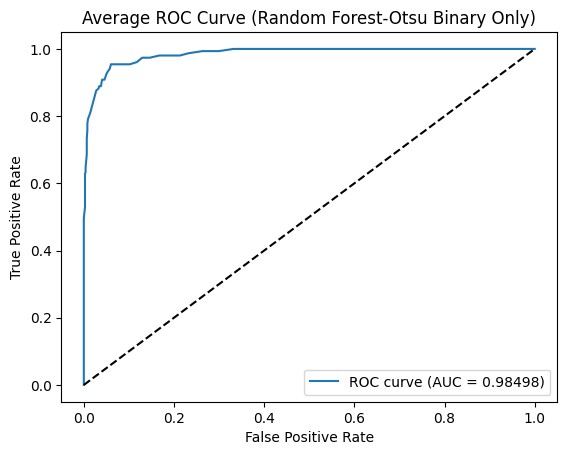

AUC (ROC): 0.98498


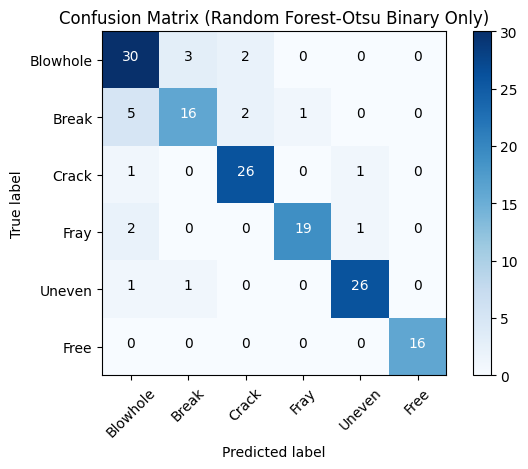

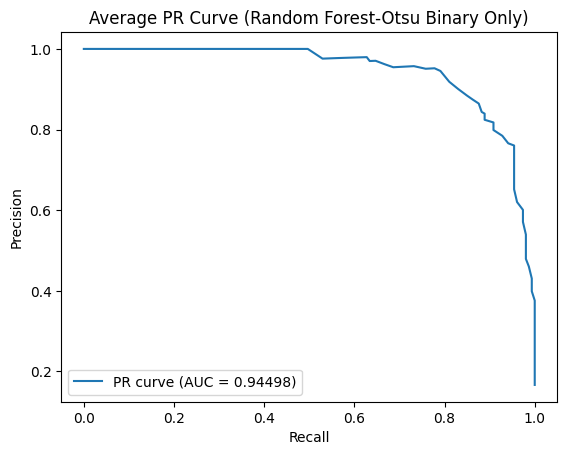

In [14]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Random Forest-Otsu Binary Only)')  
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (Random Forest-Otsu Binary Only)') 
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (Random Forest-Otsu Binary Only)') 
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)  # Use the predict_proba to get probabilities.
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/otsu_dataset'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    # Create a random forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/otsu/rf_model.pkl'
    
    # Save the trained model
    joblib.dump(rf_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(rf_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 7. Decision Tree - Otsu Binary Only:

Training Time: 0.13869 seconds
Model saved as /Users/surq/workspace/final_p/models/otsu/dt_model.pkl
Accuracy: 0.61438
Precision: 0.64259
Recall: 0.64058
F1 Score: 0.64048


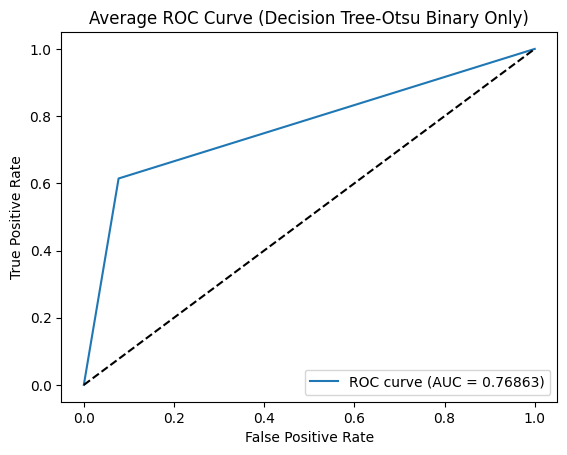

AUC (ROC): 0.76863


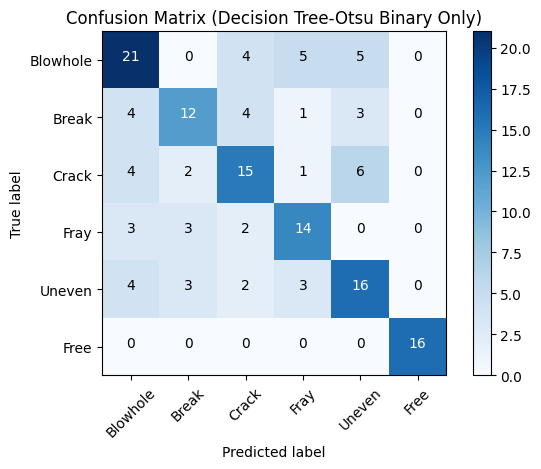

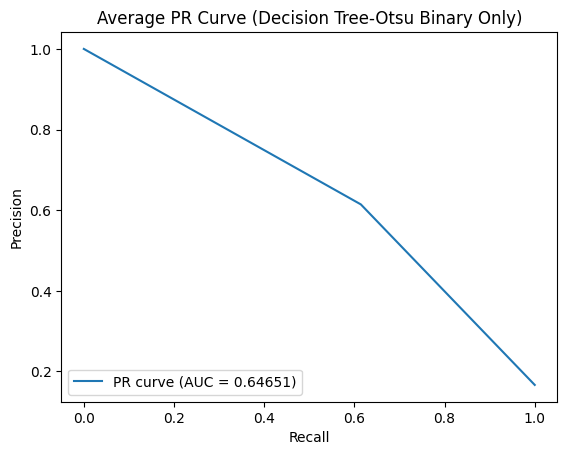

In [15]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Decision Tree-Otsu Binary Only)')  
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (Decision Tree-Otsu Binary Only)') 
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (Decision Tree-Otsu Binary Only)') 
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)  # Use the predict_proba to get probabilities.
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/otsu_dataset'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    # Create a decision tree model
    dt_model = DecisionTreeClassifier(random_state=42)  # Changed to DecisionTreeClassifier
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    dt_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/otsu/dt_model.pkl'  # Changed the model name to dt_model.pkl
    
    # Save the trained model
    joblib.dump(dt_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(dt_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 8. ROC Curve and P-R Curve of Otsu Binary Only Dataset:

#### The following code is used to generate the ROC curve and P-R curve of the above 5 models for comparison. The path of the dataset still needs to be filled in the path of the main dataset folder, and then the code will automatically find the images and labels of the test set. The above 5 training codes all save the trained models. In the following code, you need to fill in the path of each saved model.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


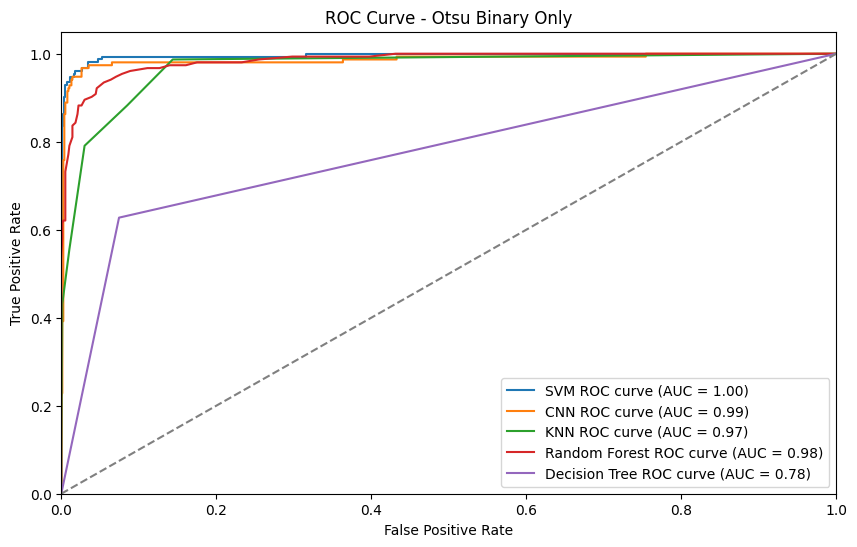

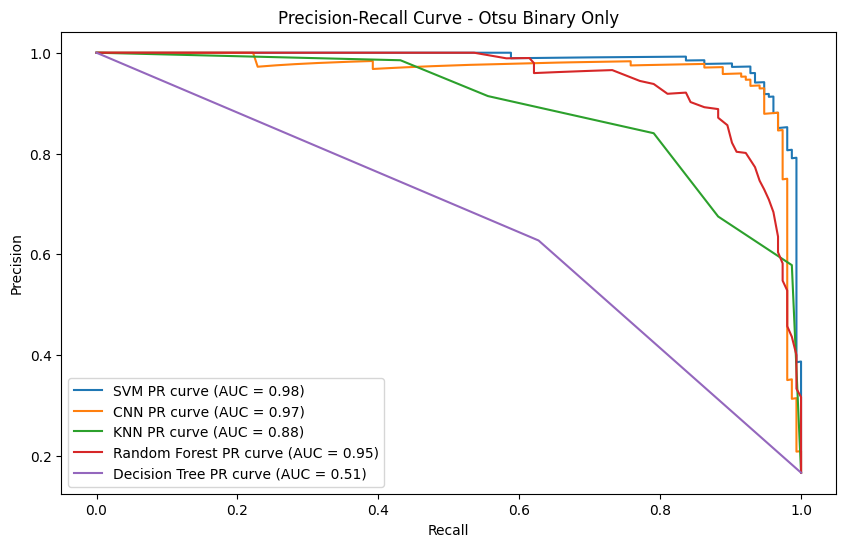

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import joblib
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import itertools


# Function to load dataset
def load_dataset(main_folder_path):
    images_train, labels_train, images_test, labels_test = [], [], [], []

    # Define paths
    images_train_path = os.path.join(main_folder_path, 'images', 'train')
    labels_train_path = os.path.join(main_folder_path, 'labels', 'train')
    images_test_path = os.path.join(main_folder_path, 'images', 'test')
    labels_test_path = os.path.join(main_folder_path, 'labels', 'test')

    # Load training data
    for label_file in os.listdir(labels_train_path):
        label = int(open(os.path.join(labels_train_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(
            os.path.join(images_train_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_train_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_train.append(img.numpy())
        labels_train.append(label)

    # Load test data
    for label_file in os.listdir(labels_test_path):
        label = int(open(os.path.join(labels_test_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(
            os.path.join(images_test_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_test_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_test.append(img.numpy())
        labels_test.append(label)

    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)


if __name__ == "__main__":
    main_folder_path = '/Users/surq/workspace/final_p/otsu_dataset'

    # Load dataset
    x_train, y_train, x_test, y_test = load_dataset(main_folder_path)
    x_test_cnn = x_test / 255.0  # Normalize for CNN
    x_test_svm_knn = x_test.reshape(x_test.shape[0], -1)  # Flatten for SVM and KNN

    # Load models
    # SVM model
    svm_model_path = '/Users/surq/workspace/final_p/models/otsu/svm_model.pkl'
    svm_model = joblib.load(svm_model_path)

    # CNN model
    cnn_model_path = '/Users/surq/workspace/final_p/models/otsu/cnn_model.keras'
    cnn_model = tf.keras.models.load_model(cnn_model_path)

    # KNN model
    knn_model_path = '/Users/surq/workspace/final_p/models/otsu/knn_model.pkl'
    knn_model = joblib.load(knn_model_path)

    # Random Forest model
    rf_model_path = '/Users/surq/workspace/final_p/models/otsu/rf_model.pkl'
    rf_model = joblib.load(rf_model_path)

    # Decision Tree model
    dt_model_path = '/Users/surq/workspace/final_p/models/otsu/dt_model.pkl'
    dt_model = joblib.load(dt_model_path)

    # Binarize labels
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

    # Generate predictions and probabilities for each model
    # SVM
    svm_y_pred_prob = svm_model.predict_proba(x_test_svm_knn)

    # CNN
    cnn_y_pred_prob = cnn_model.predict(x_test_cnn)

    # KNN
    knn_y_pred_prob = knn_model.predict_proba(x_test_svm_knn)

    # Random Forest
    rf_y_pred_prob = rf_model.predict_proba(x_test_svm_knn)

    # Decision Tree
    dt_y_pred_prob = dt_model.predict_proba(x_test_svm_knn)

    # Calculate and plot ROC curves
    plt.figure(figsize=(10, 6))
    # SVM ROC
    svm_fpr, svm_tpr, _ = roc_curve(y_test_bin.ravel(), svm_y_pred_prob.ravel())
    svm_roc_auc = auc(svm_fpr, svm_tpr)
    plt.plot(svm_fpr, svm_tpr, label=f'SVM ROC curve (AUC = {svm_roc_auc:.2f})')

    # CNN ROC
    cnn_fpr, cnn_tpr, _ = roc_curve(y_test_bin.ravel(), cnn_y_pred_prob.ravel())
    cnn_roc_auc = auc(cnn_fpr, cnn_tpr)
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN ROC curve (AUC = {cnn_roc_auc:.2f})')

    # KNN ROC
    knn_fpr, knn_tpr, _ = roc_curve(y_test_bin.ravel(), knn_y_pred_prob.ravel())
    knn_roc_auc = auc(knn_fpr, knn_tpr)
    plt.plot(knn_fpr, knn_tpr, label=f'KNN ROC curve (AUC = {knn_roc_auc:.2f})')

    # Random Forest ROC
    rf_fpr, rf_tpr, _ = roc_curve(y_test_bin.ravel(), rf_y_pred_prob.ravel())
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    plt.plot(rf_fpr, rf_tpr, label=f'Random Forest ROC curve (AUC = {rf_roc_auc:.2f})')

    # Decision Tree ROC
    dt_fpr, dt_tpr, _ = roc_curve(y_test_bin.ravel(), dt_y_pred_prob.ravel())
    dt_roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree ROC curve (AUC = {dt_roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Otsu Binary Only')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate and plot PR curves
    plt.figure(figsize=(10, 6))
    # SVM PR
    svm_precision, svm_recall, _ = precision_recall_curve(y_test_bin.ravel(), svm_y_pred_prob.ravel())
    svm_pr_auc = average_precision_score(y_test_bin, svm_y_pred_prob, average="macro")
    plt.plot(svm_recall, svm_precision, label=f'SVM PR curve (AUC = {svm_pr_auc:.2f})')

    # CNN PR
    cnn_precision, cnn_recall, _ = precision_recall_curve(y_test_bin.ravel(), cnn_y_pred_prob.ravel())
    cnn_pr_auc = average_precision_score(y_test_bin, cnn_y_pred_prob, average="macro")
    plt.plot(cnn_recall, cnn_precision, label=f'CNN PR curve (AUC = {cnn_pr_auc:.2f})')

    # KNN PR
    knn_precision, knn_recall, _ = precision_recall_curve(y_test_bin.ravel(), knn_y_pred_prob.ravel())
    knn_pr_auc = average_precision_score(y_test_bin, knn_y_pred_prob, average="macro")
    plt.plot(knn_recall, knn_precision, label=f'KNN PR curve (AUC = {knn_pr_auc:.2f})')

    # Random Forest PR
    rf_precision, rf_recall, _ = precision_recall_curve(y_test_bin.ravel(), rf_y_pred_prob.ravel())
    rf_pr_auc = average_precision_score(y_test_bin, rf_y_pred_prob, average="macro")
    plt.plot(rf_recall, rf_precision, label=f'Random Forest PR curve (AUC = {rf_pr_auc:.2f})')

    # Decision Tree PR
    dt_precision, dt_recall, _ = precision_recall_curve(y_test_bin.ravel(), dt_y_pred_prob.ravel())
    dt_pr_auc = average_precision_score(y_test_bin, dt_y_pred_prob, average="macro")
    plt.plot(dt_recall, dt_precision, label=f'Decision Tree PR curve (AUC = {dt_pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Otsu Binary Only')
    plt.legend(loc='lower left')
    plt.show()

## VI. Training on the Wavelet Only Dataset.

### 1. Introduction:

#### This section trains the original dataset after wavelet transform. First, use the code in 2. to do the transform and display the processing time. Then, each model is trained separately. When the performance values are entered into the table at the end, the wavelet transform processing time is added to the training time of each model as the final training time. Note that you need to change the input path to the path of the wavelet transformed dataset in the training code of each model.

### 2. Wavelet Transform:

#### This code uses a 2D Discrete Wavelet Transform (DWT) to enhance images, combining low-frequency and high-frequency components to improve details and contrast. It employs a biorthogonal wavelet ('bior3.5') with a decomposition level of 3, making it suitable for batch processing of image datasets. When running, you only need to fill in the main folder path of the input data and the main folder path of the output. After the code processes the image, it will also change the name of the image and label. For example, if the image in the original dataset is named "exp0_num_797.jpg", the name of the image after processing will be changed to "exp0_wto_797.jpg", and the same for the name of the label.

In [17]:
import os
import cv2
import pywt
import numpy as np
from tqdm import tqdm
import shutil
import time  # For time measurement

def apply_wavelet_transform(image, wavelet='bior3.5', level=3):
    """
    Apply 2D Discrete Wavelet Transform (DWT) with a combination of 
    low-frequency and high-frequency components, followed by contrast enhancement.

    Parameters:
        image (numpy.ndarray): The input grayscale image.
        wavelet (str): The wavelet function to use (default: 'bior3.5').
        level (int): Number of decomposition levels (default: 3).

    Returns:
        numpy.ndarray: The transformed image with enhanced details, 
                       maintaining the same size as the input.
    """
    # 1. Perform multi-level wavelet decomposition
    coeffs2 = pywt.wavedec2(image, wavelet, level=level)

    # 2. Extract the approximation (low-frequency) and detail (high-frequency) coefficients
    cA = coeffs2[0]  # Approximation (low-frequency)
    cH, cV, cD = coeffs2[1][0], coeffs2[1][1], coeffs2[1][2]  # High-frequency details

    # 3. Combine low-frequency and high-frequency information to enhance edges/textures
    combined = cA + 0.5 * (np.abs(cH) + np.abs(cV) + np.abs(cD))

    # 4. Replace the approximation coefficients with the combined result 
    #    and set all detail coefficients to zero before the inverse transform
    coeffs2[0] = combined
    coeffs2[1:] = [tuple(np.zeros_like(c) for c in level) for level in coeffs2[1:]]
    reconstructed_img = pywt.waverec2(coeffs2, wavelet)

    # 5. Normalize the image to the range 0-255
    reconstructed_img = cv2.normalize(reconstructed_img, None, 0, 255, cv2.NORM_MINMAX)
    transformed_img = reconstructed_img.astype(np.uint8)

    # 6. Apply histogram equalization for additional contrast enhancement
    transformed_img = cv2.equalizeHist(transformed_img)

    return transformed_img


def process_dataset(input_folder, output_folder, wavelet='bior3.5', level=3):
    """
    Process an entire dataset using the wavelet transform function and save
    the resulting images (and corresponding label files) into a new folder structure.

    Parameters:
        input_folder (str): Path to the input dataset folder.
        output_folder (str): Path where the processed dataset will be saved.
        wavelet (str): The wavelet function to use (default: 'bior3.5').
        level (int): Number of decomposition levels (default: 3).
    """
    # Start time measurement
    start_time = time.time()

    # 1. Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 2. Define the paths for images and labels inside the input folder
    input_images_path = os.path.join(input_folder, 'images')
    input_labels_path = os.path.join(input_folder, 'labels')
    output_images_path = os.path.join(output_folder, 'images')
    output_labels_path = os.path.join(output_folder, 'labels')

    # 3. Get all subfolder names (representing defect classes), ignoring hidden files
    defect_classes = [d for d in os.listdir(input_images_path) if not d.startswith('.')]

    # 4. Process each defect category folder
    for defect_name in defect_classes:
        # Paths for the current defect category in input and output
        input_image_class_path = os.path.join(input_images_path, defect_name)
        input_label_class_path = os.path.join(input_labels_path, defect_name)
        output_image_class_path = os.path.join(output_images_path, defect_name)
        output_label_class_path = os.path.join(output_labels_path, defect_name)

        # Create corresponding output folders for the current category
        os.makedirs(output_image_class_path, exist_ok=True)
        os.makedirs(output_label_class_path, exist_ok=True)

        # 5. Process each image in the current category
        for filename in tqdm(
            [f for f in os.listdir(input_image_class_path) if not f.startswith('.')],
            desc=f"Processing {defect_name}"
        ):
            if filename.endswith('.jpg'):
                # a) Read the image in grayscale
                img_path = os.path.join(input_image_class_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # b) Apply wavelet transform
                transformed_img = apply_wavelet_transform(img, wavelet=wavelet, level=level)

                # c) Save the transformed image (replace 'num' with 'wto' in the filename)
                new_filename = filename.replace('num', 'wto')
                new_img_path = os.path.join(output_image_class_path, new_filename)
                cv2.imwrite(new_img_path, transformed_img)

                # d) Process the corresponding label file (replace extension .jpg with .txt)
                label_filename = filename.replace('.jpg', '.txt')
                label_path = os.path.join(input_label_class_path, label_filename)

                if os.path.exists(label_path):
                    # Copy the label file to the new location, also replacing 'num' with 'wto'
                    new_label_filename = label_filename.replace('num', 'wto')
                    new_label_path = os.path.join(output_label_class_path, new_label_filename)
                    shutil.copy(label_path, new_label_path)

    # End time measurement
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Processing completed. Elapsed time: {elapsed_time:.2f} seconds")


if __name__ == "__main__":
    # Input dataset main folder path
    input_folder = "/Users/surq/workspace/final_p/train_data/sd_64"  # Example dataset path

    # Output folder path for saving processed dataset
    output_folder = "/Users/surq/workspace/final_p/wavelet_dataset"  # Example output path

    # Parameters
    wavelet = 'bior3.5'  # Biorthogonal wavelet
    level = 3            # Decomposition level

    # Execute the dataset processing
    process_dataset(input_folder, output_folder, wavelet=wavelet, level=level)

Processing test:   0%|                                  | 0/153 [00:00<?, ?it/s]/opt/anaconda3/envs/yolov7/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(
Processing train: 100%|█████████████████████| 459/459 [00:00<00:00, 1254.86it/s]

Processing completed. Elapsed time: 0.53 seconds


### 3. SVM - Wavelet Only:

Training Time: 0.21665 seconds
Model saved as /Users/surq/workspace/final_p/models/wavelet/svm_model.pkl
Accuracy: 0.88889
Precision: 0.89476
Recall: 0.85988
F1 Score: 0.86695


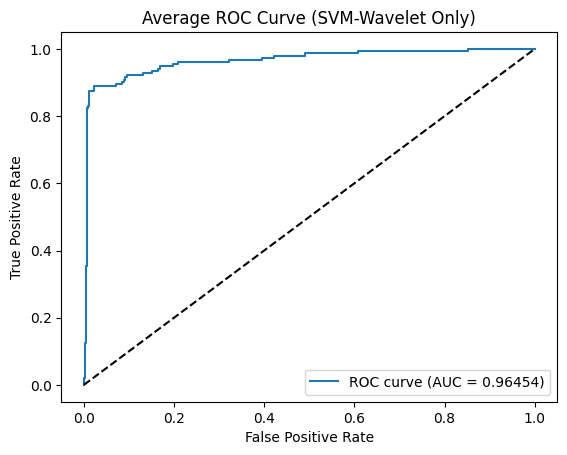

AUC (ROC): 0.96454


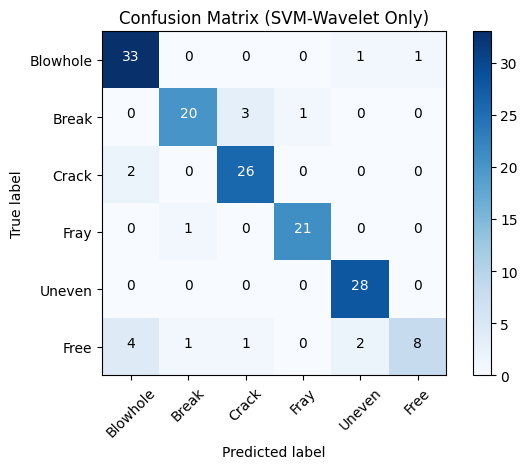

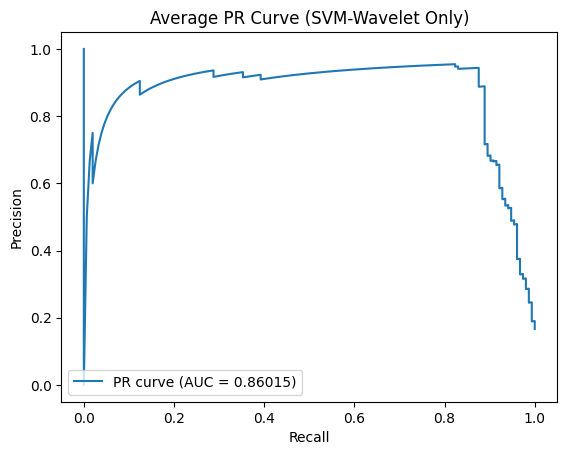

In [17]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (SVM-Wavelet Only)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (SVM-Wavelet Only)')
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (SVM-Wavelet Only)')
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.decision_function(X)  # Get decision scores for each class
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/wavelet_dataset'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)  # Enable probability output for AUC calculation
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    svm_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/wavelet/svm_model.pkl'  # Specify your desired path here
    
    # Save the trained model
    joblib.dump(svm_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(svm_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 4. CNN - Wavelet Only:

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.1735 - loss: 1.7964 - val_accuracy: 0.1503 - val_loss: 1.7719 - learning_rate: 3.5000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.2371 - loss: 1.7618 - val_accuracy: 0.3529 - val_loss: 1.7181 - learning_rate: 3.5000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.2151 - loss: 1.7188 - val_accuracy: 0.4444 - val_loss: 1.4474 - learning_rate: 3.5000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.4158 - loss: 1.5090 - val_accuracy: 0.4248 - val_loss: 1.4876 - learning_rate: 3.5000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.4525 - loss: 1.4317 - val_accuracy: 0.5490 - val_loss: 1.1944 - learning_rate: 3.5000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5344 - loss: 1.3396 - val_accuracy: 0.6863 - val_loss: 1.0494 - learning_rate: 3.5000e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 

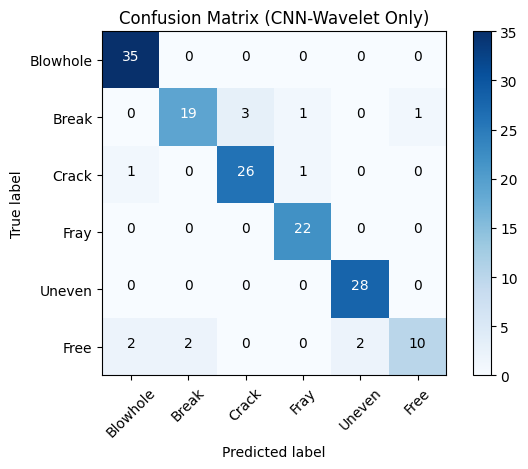

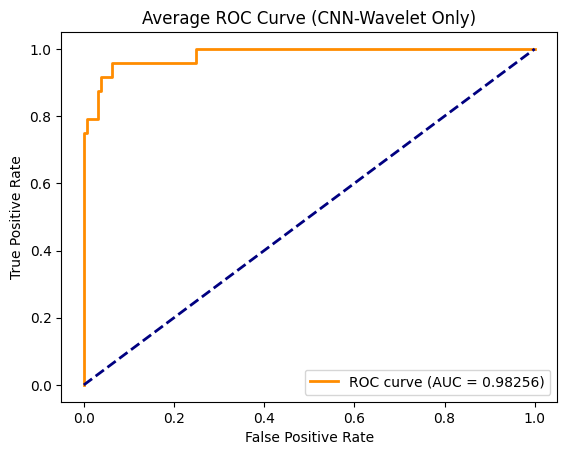

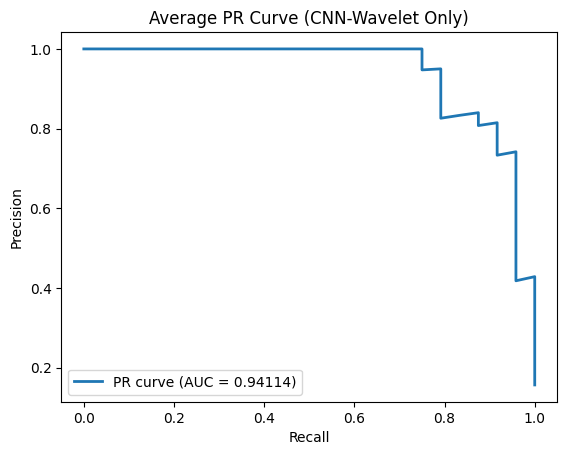


Model saved as /Users/surq/workspace/final_p/models/wavelet/cnn_model.keras

Training time: 79.58922 seconds


In [18]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import itertools

# Function to load dataset
def load_dataset(main_folder_path):
    images_train, labels_train, images_test, labels_test = [], [], [], []
    
    # Define paths
    images_train_path = os.path.join(main_folder_path, 'images', 'train')
    labels_train_path = os.path.join(main_folder_path, 'labels', 'train')
    images_test_path = os.path.join(main_folder_path, 'images', 'test')
    labels_test_path = os.path.join(main_folder_path, 'labels', 'test')
    
    # Load training data
    for label_file in os.listdir(labels_train_path):
        label = int(open(os.path.join(labels_train_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(os.path.join(images_train_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_train_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_train.append(img.numpy())
        labels_train.append(label)
    
    # Load test data
    for label_file in os.listdir(labels_test_path):
        label = int(open(os.path.join(labels_test_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(os.path.join(images_test_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_test_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_test.append(img.numpy())
        labels_test.append(label)
    
    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)

# Define a CNN model
def create_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00035),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (CNN-Wavelet Only)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Main program
if __name__ == '__main__':
    main_folder_path = '/Users/surq/workspace/final_p/wavelet_dataset'
    
    # Load dataset
    x_train, y_train, x_test, y_test = load_dataset(main_folder_path)
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # Create and train model
    model = create_cnn_model()
    start_time = time.time()
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[lr_scheduler])
    training_time = time.time() - start_time

    # Evaluate model
    y_pred_prob = model.predict(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Generate evaluation metrics
    overall_accuracy = accuracy_score(y_test, y_pred)
    overall_precision = precision_score(y_test, y_pred, average='weighted')
    overall_recall = recall_score(y_test, y_pred, average='weighted')
    overall_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\nOverall Accuracy: {overall_accuracy:.5f}")
    print(f"Overall Precision: {overall_precision:.5f}")
    print(f"Overall Recall: {overall_recall:.5f}")
    print(f"Overall F1 Score: {overall_f1:.5f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free'])

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (CNN-Wavelet Only)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label='PR curve (AUC = {:.5f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (CNN-Wavelet Only)')
    plt.legend(loc="lower left")
    plt.show()

    # Save model
    model_save_path = '/Users/surq/workspace/final_p/models/wavelet/cnn_model.keras'  # Specify your desired path here
    model.save(model_save_path)
    print(f"\nModel saved as {model_save_path}")
    
    # Output training time
    print(f"\nTraining time: {training_time:.5f} seconds")

### 5. KNN - Wavelet Only:

Accuracy: 0.77778
Precision: 0.73702
Recall: 0.74404
F1 Score: 0.73686
Training Time: 0.00233 seconds


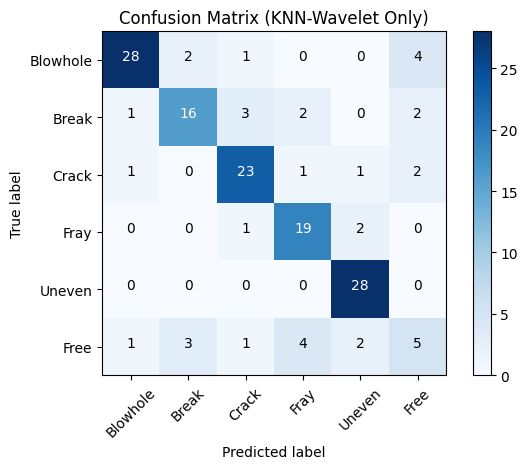

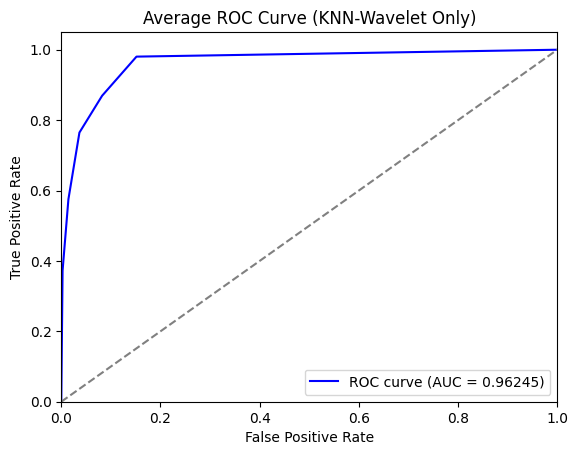

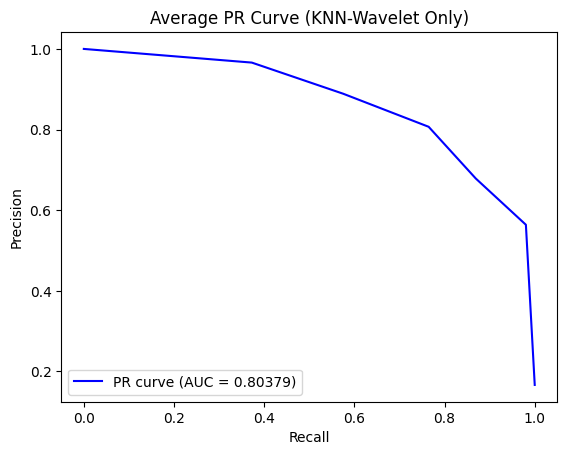

Model saved as /Users/surq/workspace/final_p/models/wavelet/knn_model.pkl


In [19]:
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import time
import joblib  # For saving the model
import itertools

# Load dataset from the given main folder path
def load_dataset(main_folder):
    image_folder = os.path.join(main_folder, 'images')
    label_folder = os.path.join(main_folder, 'labels')

    images_train = []
    labels_train = []
    images_test = []
    labels_test = []

    # Load train images and labels
    train_image_folder = os.path.join(image_folder, 'train')
    train_label_folder = os.path.join(label_folder, 'train')
    for filename in os.listdir(train_image_folder):
        if filename.endswith(('.jpg', '.png')):
            base_name = os.path.splitext(filename)[0]
            label_path = os.path.join(train_label_folder, base_name + '.txt')
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as file:
                defect_type = int(file.readline().strip())

            img_path = os.path.join(train_image_folder, filename)
            img = np.array(Image.open(img_path).convert('L').resize((64, 64)))  # Load and resize image
            images_train.append(img.flatten())  # Flatten the image
            labels_train.append(defect_type)
    
    # Load test images and labels
    test_image_folder = os.path.join(image_folder, 'test')
    test_label_folder = os.path.join(label_folder, 'test')
    for filename in os.listdir(test_image_folder):
        if filename.endswith(('.jpg', '.png')):
            base_name = os.path.splitext(filename)[0]
            label_path = os.path.join(test_label_folder, base_name + '.txt')
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as file:
                defect_type = int(file.readline().strip())

            img_path = os.path.join(test_image_folder, filename)
            img = np.array(Image.open(img_path).convert('L').resize((64, 64)))  # Load and resize image
            images_test.append(img.flatten())  # Flatten the image
            labels_test.append(defect_type)

    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (KNN-Wavelet Only)')
    plt.colorbar()  # Display color bar
    tick_marks = np.arange(len(classes))  # Tick marks for the labels
    plt.xticks(tick_marks, classes, rotation=45)  # Label x axis with classes
    plt.yticks(tick_marks, classes)  # Label y axis with classes
    
    fmt = 'd'  # Format the numbers in the matrix
    thresh = cm.max() / 2  # Define a threshold for coloring text
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),  # Format as integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")  # Choose text color based on threshold

    plt.ylabel('True label')  # Label y-axis
    plt.xlabel('Predicted label')  # Label x-axis
    plt.tight_layout()  # Adjust layout to avoid overlapping
    plt.show()  # Display the plot

# Train and evaluate KNN model
def train_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    # Start measuring the training time
    start_time = time.time()

    knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=n_neighbors))
    knn.fit(X_train, y_train)

    # End measuring the training time
    end_time = time.time()
    training_time = end_time - start_time
    
    # Predict on the test set
    y_pred = knn.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"F1 Score: {f1:.5f}")
    print(f"Training Time: {training_time:.5f} seconds")  # Show time with 5 decimal places

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free'])

    # ROC curve and AUC
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])  # Binarize the labels
    y_pred_prob = knn.predict_proba(X_test)  # Get probabilities for each class
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (KNN-Wavelet Only)')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    pr_auc = average_precision_score(y_test_bin, y_pred_prob, average="macro")

    plt.figure()
    plt.plot(recall, precision, color='b', label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (KNN-Wavelet Only)')
    plt.legend(loc='lower left')
    plt.show()

    # Save the model
    model_save_path = '/Users/surq/workspace/final_p/models/wavelet/knn_model.pkl'  # Modify this to the desired path
    joblib.dump(knn, model_save_path)  # Save the trained model
    print(f"Model saved as {model_save_path}")

# Main function
def main():
    main_folder = '/Users/surq/workspace/final_p/wavelet_dataset'  # Modify this path if needed

    # Load dataset
    X_train, y_train, X_test, y_test = load_dataset(main_folder)

    # Train and evaluate KNN model
    train_knn(X_train, y_train, X_test, y_test)

if __name__ == "__main__":
    main()

### 6. Random Forest - Wavelet Only:

Training Time: 0.75000 seconds
Model saved as /Users/surq/workspace/final_p/models/wavelet/rf_model.pkl
Accuracy: 0.93464
Precision: 0.93975
Recall: 0.90972
F1 Score: 0.91617


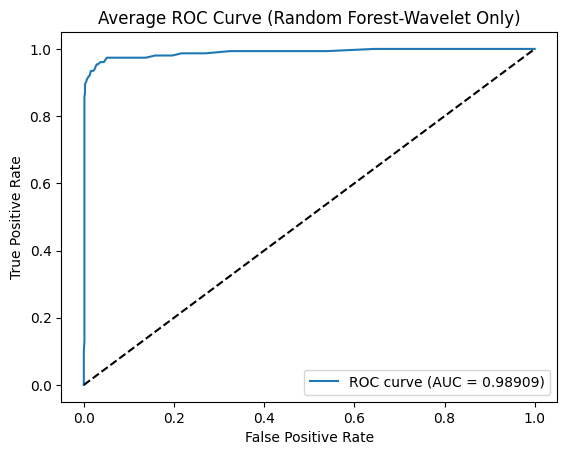

AUC (ROC): 0.98909


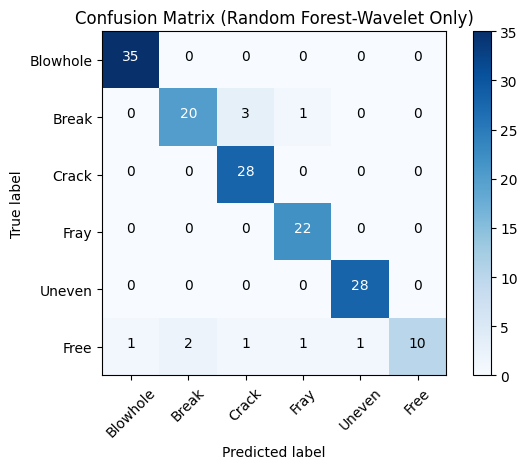

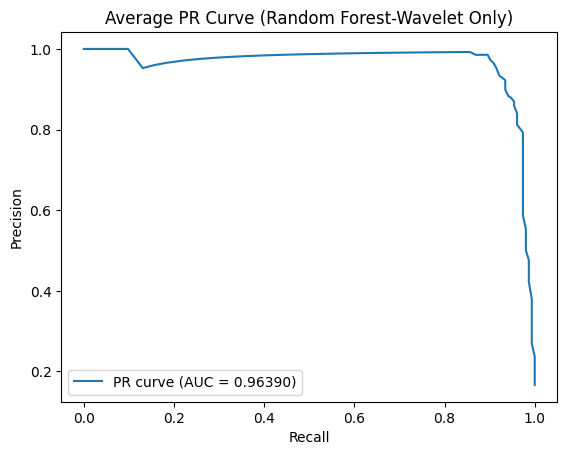

In [20]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Random Forest-Wavelet Only)')  
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (Random Forest-Wavelet Only)') 
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (Random Forest-Wavelet Only)') 
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)  # Use the predict_proba to get probabilities.
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/wavelet_dataset'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    # Create a random forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/wavelet/rf_model.pkl'
    
    # Save the trained model
    joblib.dump(rf_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(rf_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 7. Decision Tree - Wavelet Only:

Training Time: 0.65200 seconds
Model saved as /Users/surq/workspace/final_p/models/wavelet/dt_model.pkl
Accuracy: 0.81699
Precision: 0.79032
Recall: 0.79198
F1 Score: 0.78889


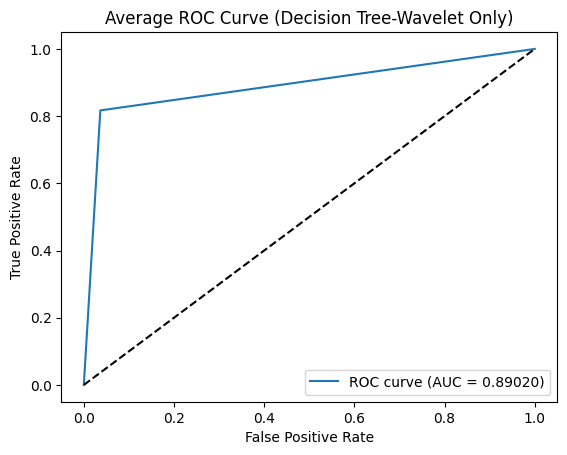

AUC (ROC): 0.89020


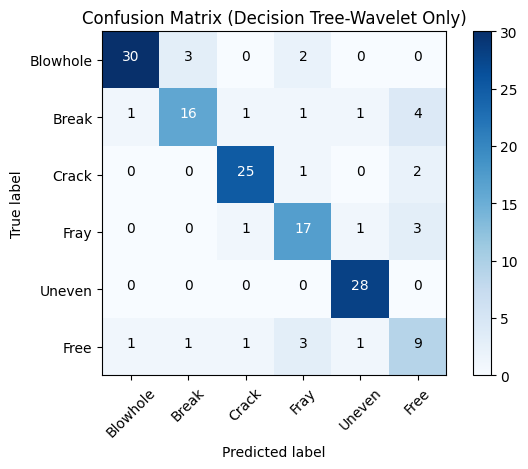

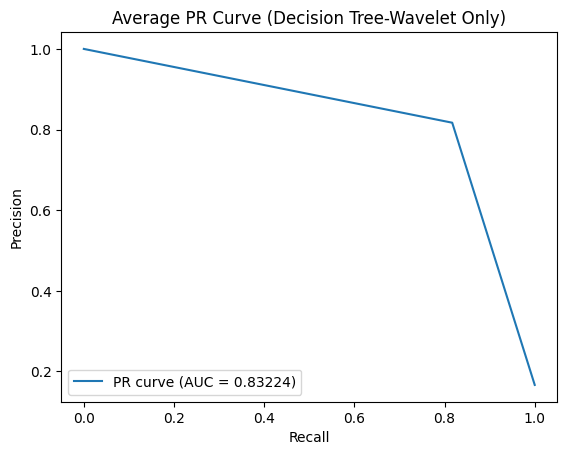

In [21]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Decision Tree-Wavelet Only)')  
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (Decision Tree-Wavelet Only)') 
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (Decision Tree-Wavelet Only)') 
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)  # Use the predict_proba to get probabilities.
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/wavelet_dataset'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    # Create a decision tree model
    dt_model = DecisionTreeClassifier(random_state=42)  # Changed to DecisionTreeClassifier
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    dt_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/wavelet/dt_model.pkl'  # Changed the model name to dt_model.pkl
    
    # Save the trained model
    joblib.dump(dt_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(dt_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 8. ROC Curve and P-R Curve of Wavelet Only Dataset:

#### The following code is used to generate the ROC curve and P-R curve of the above 5 models for comparison. The path of the dataset still needs to be filled in the path of the main dataset folder, and then the code will automatically find the images and labels of the test set. The above 5 training codes all save the trained models. In the following code, you need to fill in the path of each saved model.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


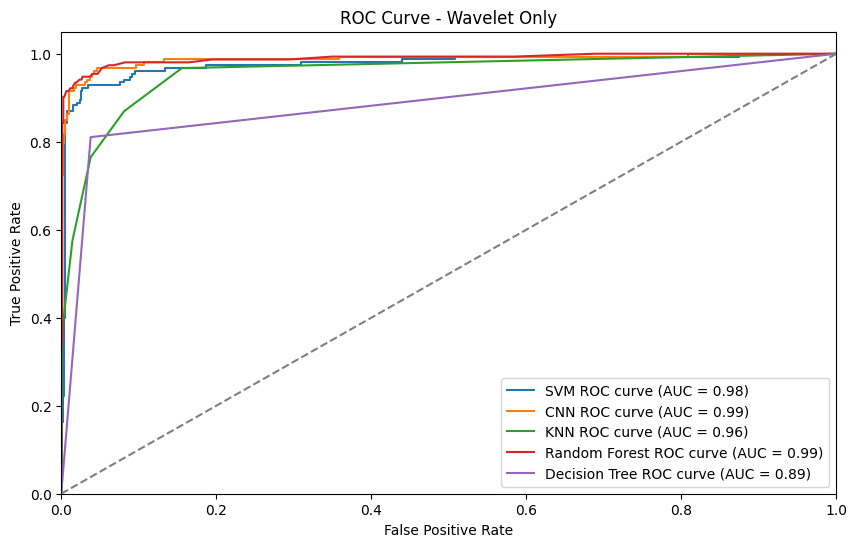

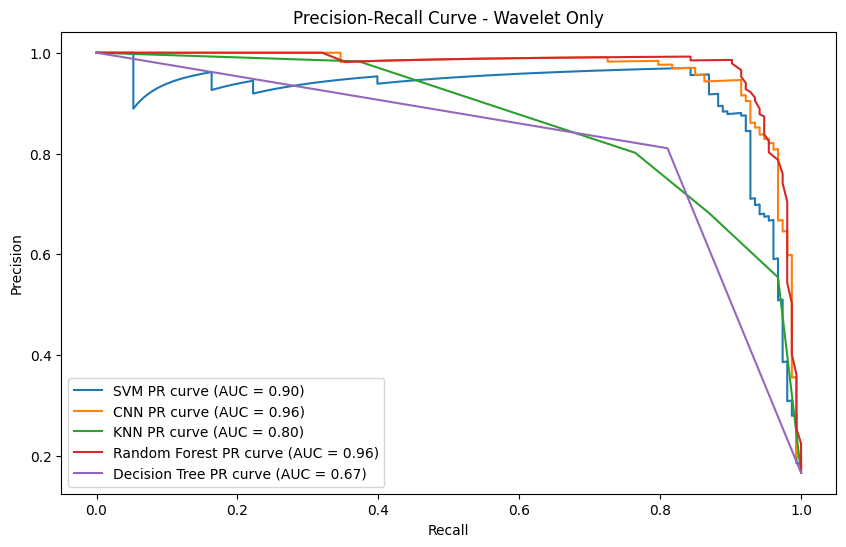

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import joblib
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import itertools


# Function to load dataset
def load_dataset(main_folder_path):
    images_train, labels_train, images_test, labels_test = [], [], [], []

    # Define paths
    images_train_path = os.path.join(main_folder_path, 'images', 'train')
    labels_train_path = os.path.join(main_folder_path, 'labels', 'train')
    images_test_path = os.path.join(main_folder_path, 'images', 'test')
    labels_test_path = os.path.join(main_folder_path, 'labels', 'test')

    # Load training data
    for label_file in os.listdir(labels_train_path):
        label = int(open(os.path.join(labels_train_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(
            os.path.join(images_train_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_train_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_train.append(img.numpy())
        labels_train.append(label)

    # Load test data
    for label_file in os.listdir(labels_test_path):
        label = int(open(os.path.join(labels_test_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(
            os.path.join(images_test_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_test_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_test.append(img.numpy())
        labels_test.append(label)

    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)


if __name__ == "__main__":
    main_folder_path = '/Users/surq/workspace/final_p/wavelet_dataset'

    # Load dataset
    x_train, y_train, x_test, y_test = load_dataset(main_folder_path)
    x_test_cnn = x_test / 255.0  # Normalize for CNN
    x_test_svm_knn = x_test.reshape(x_test.shape[0], -1)  # Flatten for SVM and KNN

    # Load models
    # SVM model
    svm_model_path = '/Users/surq/workspace/final_p/models/wavelet/svm_model.pkl'
    svm_model = joblib.load(svm_model_path)

    # CNN model
    cnn_model_path = '/Users/surq/workspace/final_p/models/wavelet/cnn_model.keras'
    cnn_model = tf.keras.models.load_model(cnn_model_path)

    # KNN model
    knn_model_path = '/Users/surq/workspace/final_p/models/wavelet/knn_model.pkl'
    knn_model = joblib.load(knn_model_path)

    # Random Forest model
    rf_model_path = '/Users/surq/workspace/final_p/models/wavelet/rf_model.pkl'
    rf_model = joblib.load(rf_model_path)

    # Decision Tree model
    dt_model_path = '/Users/surq/workspace/final_p/models/wavelet/dt_model.pkl'
    dt_model = joblib.load(dt_model_path)

    # Binarize labels
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

    # Generate predictions and probabilities for each model
    # SVM
    svm_y_pred_prob = svm_model.predict_proba(x_test_svm_knn)

    # CNN
    cnn_y_pred_prob = cnn_model.predict(x_test_cnn)

    # KNN
    knn_y_pred_prob = knn_model.predict_proba(x_test_svm_knn)

    # Random Forest
    rf_y_pred_prob = rf_model.predict_proba(x_test_svm_knn)

    # Decision Tree
    dt_y_pred_prob = dt_model.predict_proba(x_test_svm_knn)

    # Calculate and plot ROC curves
    plt.figure(figsize=(10, 6))
    # SVM ROC
    svm_fpr, svm_tpr, _ = roc_curve(y_test_bin.ravel(), svm_y_pred_prob.ravel())
    svm_roc_auc = auc(svm_fpr, svm_tpr)
    plt.plot(svm_fpr, svm_tpr, label=f'SVM ROC curve (AUC = {svm_roc_auc:.2f})')

    # CNN ROC
    cnn_fpr, cnn_tpr, _ = roc_curve(y_test_bin.ravel(), cnn_y_pred_prob.ravel())
    cnn_roc_auc = auc(cnn_fpr, cnn_tpr)
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN ROC curve (AUC = {cnn_roc_auc:.2f})')

    # KNN ROC
    knn_fpr, knn_tpr, _ = roc_curve(y_test_bin.ravel(), knn_y_pred_prob.ravel())
    knn_roc_auc = auc(knn_fpr, knn_tpr)
    plt.plot(knn_fpr, knn_tpr, label=f'KNN ROC curve (AUC = {knn_roc_auc:.2f})')

    # Random Forest ROC
    rf_fpr, rf_tpr, _ = roc_curve(y_test_bin.ravel(), rf_y_pred_prob.ravel())
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    plt.plot(rf_fpr, rf_tpr, label=f'Random Forest ROC curve (AUC = {rf_roc_auc:.2f})')

    # Decision Tree ROC
    dt_fpr, dt_tpr, _ = roc_curve(y_test_bin.ravel(), dt_y_pred_prob.ravel())
    dt_roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree ROC curve (AUC = {dt_roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Wavelet Only')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate and plot PR curves
    plt.figure(figsize=(10, 6))
    # SVM PR
    svm_precision, svm_recall, _ = precision_recall_curve(y_test_bin.ravel(), svm_y_pred_prob.ravel())
    svm_pr_auc = average_precision_score(y_test_bin, svm_y_pred_prob, average="macro")
    plt.plot(svm_recall, svm_precision, label=f'SVM PR curve (AUC = {svm_pr_auc:.2f})')

    # CNN PR
    cnn_precision, cnn_recall, _ = precision_recall_curve(y_test_bin.ravel(), cnn_y_pred_prob.ravel())
    cnn_pr_auc = average_precision_score(y_test_bin, cnn_y_pred_prob, average="macro")
    plt.plot(cnn_recall, cnn_precision, label=f'CNN PR curve (AUC = {cnn_pr_auc:.2f})')

    # KNN PR
    knn_precision, knn_recall, _ = precision_recall_curve(y_test_bin.ravel(), knn_y_pred_prob.ravel())
    knn_pr_auc = average_precision_score(y_test_bin, knn_y_pred_prob, average="macro")
    plt.plot(knn_recall, knn_precision, label=f'KNN PR curve (AUC = {knn_pr_auc:.2f})')

    # Random Forest PR
    rf_precision, rf_recall, _ = precision_recall_curve(y_test_bin.ravel(), rf_y_pred_prob.ravel())
    rf_pr_auc = average_precision_score(y_test_bin, rf_y_pred_prob, average="macro")
    plt.plot(rf_recall, rf_precision, label=f'Random Forest PR curve (AUC = {rf_pr_auc:.2f})')

    # Decision Tree PR
    dt_precision, dt_recall, _ = precision_recall_curve(y_test_bin.ravel(), dt_y_pred_prob.ravel())
    dt_pr_auc = average_precision_score(y_test_bin, dt_y_pred_prob, average="macro")
    plt.plot(dt_recall, dt_precision, label=f'Decision Tree PR curve (AUC = {dt_pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Wavelet Only')
    plt.legend(loc='lower left')
    plt.show()

## VII. Training on the Wavelet & Otsu Dataset.

### 1. Introduction:

#### The dataset trained in this section is the original dataset after wavelet transform and then Otsu binarization. The final training time of the model becomes the processing time of wavelet transform + the processing time of binarization + the training time of the model. Note that in the training code of each model, the input path needs to be changed to the path of the dataset that is first wavelet transformed and then binarized.

### 2. Binarization after Wavelet Transform:

#### The following code performs Otsu binarization based on VI. 2. Wavelet Transform，the wavelet transform dataset is input into the following binarization process. The names of the images and labels in the dataset are also changed accordingly. For example, the name of a image in the wavelet dataset is "exp0_wto_797.jpg". After binarization, the name is changed to "exp0_wtb_797.jpg". The final training time is VI. 2. Wavelet Transform time + VII. 2. Binarization after wavelet transform time + model training time.

In [23]:
import cv2
import os
import numpy as np
import time

# Convert the entire image to binary using Otsu's thresholding
def convert_image_to_binary(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was successfully loaded
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return None

    # Apply Otsu's thresholding directly
    _, binary_image = cv2.threshold(
        image, 0, 255, 
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    return binary_image

# Traverse the directory, convert images to binary using Otsu's thresholding, and save them
# Also rename files by replacing 'num' with 'bin'
def process_images(image_dir, label_dir, output_image_dir, output_label_dir):
    # Record start time
    start_time = time.time()
    
    # Walk through all files in the image directory, including subdirectories
    for root, _, files in os.walk(image_dir):
        for file in files:
            # Process only common image formats
            if file.endswith(('.jpg', '.png', '.jpeg')):  
                # Build the full path to the input image file
                image_path = os.path.join(root, file)
                
                # Build the corresponding label file path based on the relative directory structure
                relative_path = os.path.relpath(root, image_dir)
                base_name = os.path.splitext(file)[0]
                label_path = os.path.join(label_dir, relative_path, base_name + '.txt')
                
                # Build output folder paths for images and labels (keeping the original directory structure)
                output_image_folder_path = os.path.join(output_image_dir, relative_path)
                output_label_folder_path = os.path.join(output_label_dir, relative_path)
                
                # Create output folders if they do not exist
                os.makedirs(output_image_folder_path, exist_ok=True)
                os.makedirs(output_label_folder_path, exist_ok=True)
                
                # Modify the file name by replacing 'wto' with 'wtb'
                modified_file_name = file.replace('wto', 'wtb')
                modified_base_name = base_name.replace('wto', 'wtb')

                # Build the full path for the output image and label files
                output_image_file_path = os.path.join(output_image_folder_path, modified_file_name)
                output_label_file_path = os.path.join(output_label_folder_path, modified_base_name + '.txt')
                
                # Check if the label file exists
                if os.path.exists(label_path):
                    # Read the label file to determine if this image is defect-free (class '5')
                    with open(label_path, 'r') as label_file:
                        label_content = label_file.read().strip()
                        
                        # Read the original image in grayscale to get its dimensions
                        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                        if image is None:
                            print(f"Skipping {image_path} due to read error.")
                            continue
                        
                        # If the label is '5', create an all-black image with the same dimensions
                        if label_content == '5':
                            height, width = image.shape
                            binary_image = np.zeros((height, width), dtype=np.uint8)
                        else:
                            # Convert the entire image to binary
                            binary_image = convert_image_to_binary(image_path)
                            if binary_image is None:  # Check if conversion was successful
                                print(f"Skipping {image_path} due to read error.")
                                continue
                else:
                    print(f"Skipping {image_path} due to missing label file.")
                    continue
                
                # Save the binary image
                cv2.imwrite(output_image_file_path, binary_image)
                print(f'Saved binary image: {output_image_file_path}')
                
                # Copy the original label file to the output label folder with the modified name
                with open(label_path, 'r') as label_file, open(output_label_file_path, 'w') as output_label_file:
                    output_label_file.write(label_file.read())
                    print(f'Saved label file: {output_label_file_path}')
    
    # Record end time and print the elapsed time
    end_time = time.time()
    print(f"Processing completed, total time: {end_time - start_time:.2f} seconds")

# Specify the input and output directory paths
image_directory = '/Users/surq/workspace/final_p/wavelet_dataset/images'
label_directory = '/Users/surq/workspace/final_p/wavelet_dataset/labels'
output_image_directory = '/Users/surq/workspace/final_p/wavelet_otsu/images'
output_label_directory = '/Users/surq/workspace/final_p/wavelet_otsu/labels'

# Call the function to process images using Otsu's thresholding
process_images(image_directory, label_directory, output_image_directory, output_label_directory)

Saved binary image: /Users/surq/workspace/final_p/wavelet_otsu/images/test/exp3_wtb_356756.jpg
Saved label file: /Users/surq/workspace/final_p/wavelet_otsu/labels/test/exp3_wtb_356756.txt
Saved binary image: /Users/surq/workspace/final_p/wavelet_otsu/images/test/exp4_wtb_352527.jpg
Saved label file: /Users/surq/workspace/final_p/wavelet_otsu/labels/test/exp4_wtb_352527.txt
Saved binary image: /Users/surq/workspace/final_p/wavelet_otsu/images/test/exp4_wtb_246354.jpg
Saved label file: /Users/surq/workspace/final_p/wavelet_otsu/labels/test/exp4_wtb_246354.txt
Saved binary image: /Users/surq/workspace/final_p/wavelet_otsu/images/test/exp6_wtb_4841.jpg
Saved label file: /Users/surq/workspace/final_p/wavelet_otsu/labels/test/exp6_wtb_4841.txt
Saved binary image: /Users/surq/workspace/final_p/wavelet_otsu/images/test/exp6_wtb_172365.jpg
Saved label file: /Users/surq/workspace/final_p/wavelet_otsu/labels/test/exp6_wtb_172365.txt
Saved binary image: /Users/surq/workspace/final_p/wavelet_otsu/i

### 3. SVM - Wavelet & Otsu:

Training Time: 0.22681 seconds
Model saved as /Users/surq/workspace/final_p/models/wavelet_otsu/svm_model.pkl
Accuracy: 0.96732
Precision: 0.97184
Recall: 0.96726
F1 Score: 0.96865


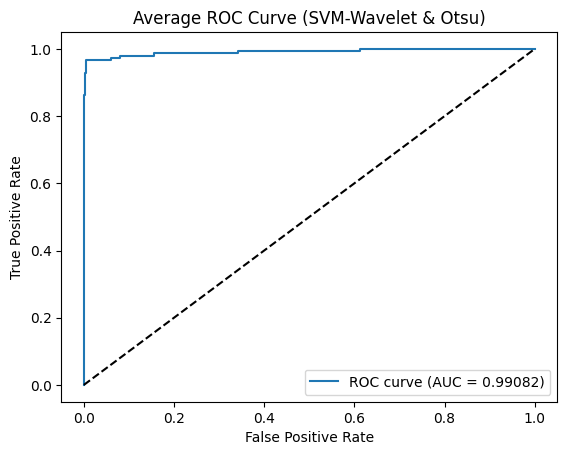

AUC (ROC): 0.99082


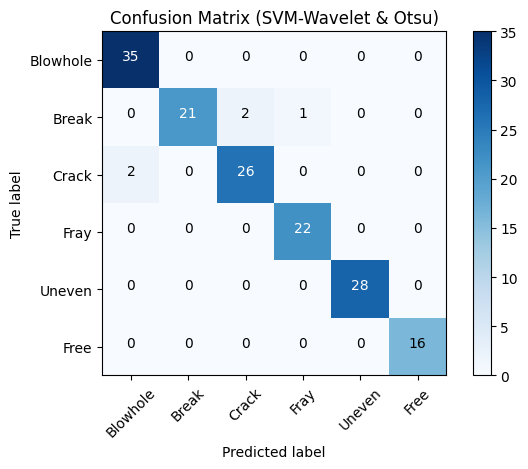

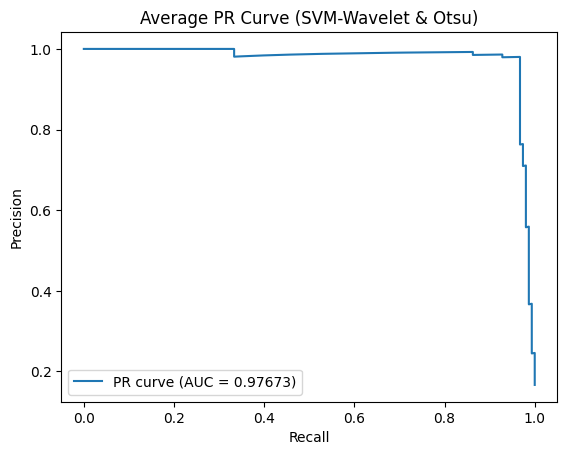

In [23]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (SVM-Wavelet & Otsu)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (SVM-Wavelet & Otsu)')
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (SVM-Wavelet & Otsu)')
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.decision_function(X)  # Get decision scores for each class
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/wavelet_otsu'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)  # Enable probability output for AUC calculation
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    svm_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/wavelet_otsu/svm_model.pkl'  # Specify your desired path here
    
    # Save the trained model
    joblib.dump(svm_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(svm_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 4. CNN - Wavelet & Otsu:

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.2898 - loss: 1.6783 - val_accuracy: 0.4967 - val_loss: 1.4214 - learning_rate: 3.5000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6175 - loss: 1.2893 - val_accuracy: 0.7582 - val_loss: 0.8841 - learning_rate: 3.5000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8140 - loss: 0.7173 - val_accuracy: 0.8170 - val_loss: 0.5282 - learning_rate: 3.5000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.8823 - loss: 0.3412 - val_accuracy: 0.8889 - val_loss: 0.4118 - learning_rate: 3.5000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9041 - loss: 0.2859 - val_accuracy: 0.9346 - val_loss: 0.3155 - learning_rate: 3.5000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9449 - loss: 0.1482 - val_accuracy: 0.9281 - val_loss: 0.2757 - learning_rate: 3.5000e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 

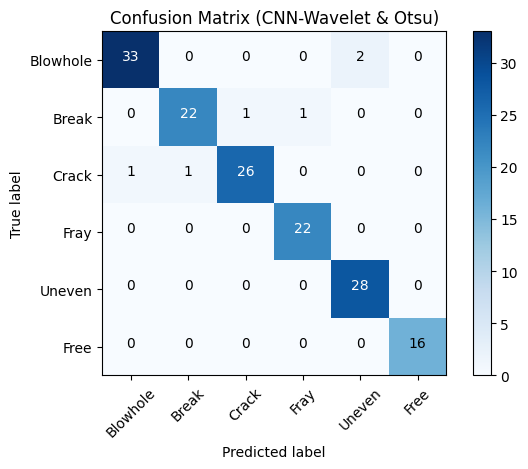

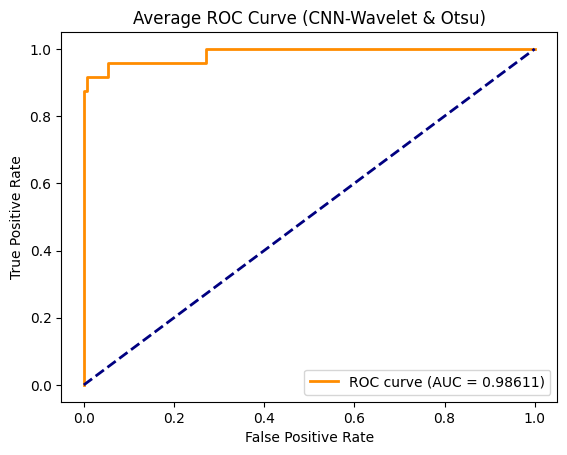

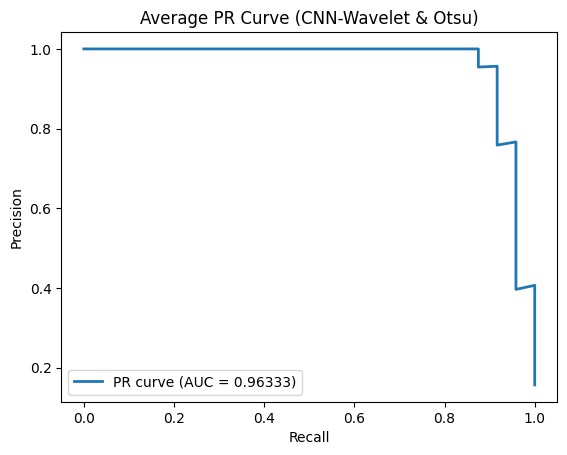


Model saved as /Users/surq/workspace/final_p/models/wavelet_otsu/cnn_model.keras

Training time: 80.06088 seconds


In [24]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import itertools

# Function to load dataset
def load_dataset(main_folder_path):
    images_train, labels_train, images_test, labels_test = [], [], [], []
    
    # Define paths
    images_train_path = os.path.join(main_folder_path, 'images', 'train')
    labels_train_path = os.path.join(main_folder_path, 'labels', 'train')
    images_test_path = os.path.join(main_folder_path, 'images', 'test')
    labels_test_path = os.path.join(main_folder_path, 'labels', 'test')
    
    # Load training data
    for label_file in os.listdir(labels_train_path):
        label = int(open(os.path.join(labels_train_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(os.path.join(images_train_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_train_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_train.append(img.numpy())
        labels_train.append(label)
    
    # Load test data
    for label_file in os.listdir(labels_test_path):
        label = int(open(os.path.join(labels_test_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(os.path.join(images_test_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_test_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_test.append(img.numpy())
        labels_test.append(label)
    
    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)

# Define a CNN model
def create_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00035),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (CNN-Wavelet & Otsu)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Main program
if __name__ == '__main__':
    main_folder_path = '/Users/surq/workspace/final_p/wavelet_otsu'
    
    # Load dataset
    x_train, y_train, x_test, y_test = load_dataset(main_folder_path)
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # Create and train model
    model = create_cnn_model()
    start_time = time.time()
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[lr_scheduler])
    training_time = time.time() - start_time

    # Evaluate model
    y_pred_prob = model.predict(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Generate evaluation metrics
    overall_accuracy = accuracy_score(y_test, y_pred)
    overall_precision = precision_score(y_test, y_pred, average='weighted')
    overall_recall = recall_score(y_test, y_pred, average='weighted')
    overall_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\nOverall Accuracy: {overall_accuracy:.5f}")
    print(f"Overall Precision: {overall_precision:.5f}")
    print(f"Overall Recall: {overall_recall:.5f}")
    print(f"Overall F1 Score: {overall_f1:.5f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free'])

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (CNN-Wavelet & Otsu)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label='PR curve (AUC = {:.5f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (CNN-Wavelet & Otsu)')
    plt.legend(loc="lower left")
    plt.show()

    # Save model
    model_save_path = '/Users/surq/workspace/final_p/models/wavelet_otsu/cnn_model.keras'  # Specify your desired path here
    model.save(model_save_path)
    print(f"\nModel saved as {model_save_path}")
    
    # Output training time
    print(f"\nTraining time: {training_time:.5f} seconds")

### 5. KNN - Wavelet & Otsu:

Accuracy: 0.90196
Precision: 0.90801
Recall: 0.90763
F1 Score: 0.90681
Training Time: 0.00248 seconds


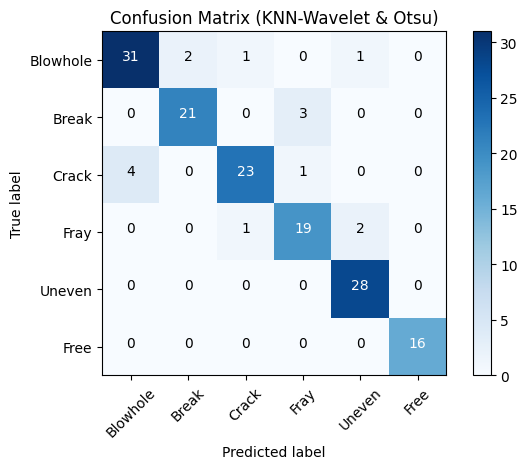

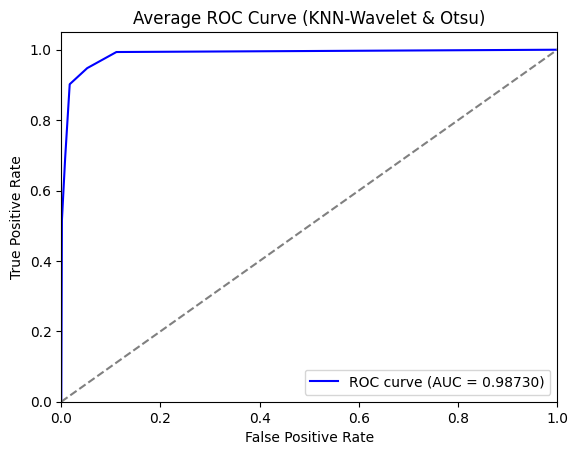

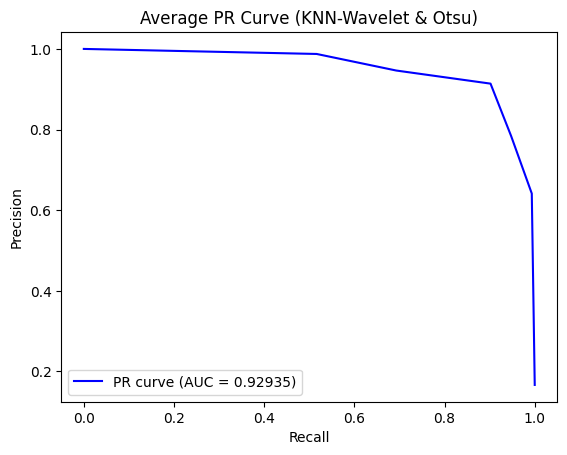

Model saved as /Users/surq/workspace/final_p/models/wavelet_otsu/knn_model.pkl


In [25]:
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import time
import joblib  # For saving the model
import itertools

# Load dataset from the given main folder path
def load_dataset(main_folder):
    image_folder = os.path.join(main_folder, 'images')
    label_folder = os.path.join(main_folder, 'labels')

    images_train = []
    labels_train = []
    images_test = []
    labels_test = []

    # Load train images and labels
    train_image_folder = os.path.join(image_folder, 'train')
    train_label_folder = os.path.join(label_folder, 'train')
    for filename in os.listdir(train_image_folder):
        if filename.endswith(('.jpg', '.png')):
            base_name = os.path.splitext(filename)[0]
            label_path = os.path.join(train_label_folder, base_name + '.txt')
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as file:
                defect_type = int(file.readline().strip())

            img_path = os.path.join(train_image_folder, filename)
            img = np.array(Image.open(img_path).convert('L').resize((64, 64)))  # Load and resize image
            images_train.append(img.flatten())  # Flatten the image
            labels_train.append(defect_type)
    
    # Load test images and labels
    test_image_folder = os.path.join(image_folder, 'test')
    test_label_folder = os.path.join(label_folder, 'test')
    for filename in os.listdir(test_image_folder):
        if filename.endswith(('.jpg', '.png')):
            base_name = os.path.splitext(filename)[0]
            label_path = os.path.join(test_label_folder, base_name + '.txt')
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as file:
                defect_type = int(file.readline().strip())

            img_path = os.path.join(test_image_folder, filename)
            img = np.array(Image.open(img_path).convert('L').resize((64, 64)))  # Load and resize image
            images_test.append(img.flatten())  # Flatten the image
            labels_test.append(defect_type)

    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (KNN-Wavelet & Otsu)')
    plt.colorbar()  # Display color bar
    tick_marks = np.arange(len(classes))  # Tick marks for the labels
    plt.xticks(tick_marks, classes, rotation=45)  # Label x axis with classes
    plt.yticks(tick_marks, classes)  # Label y axis with classes
    
    fmt = 'd'  # Format the numbers in the matrix
    thresh = cm.max() / 2  # Define a threshold for coloring text
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),  # Format as integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")  # Choose text color based on threshold

    plt.ylabel('True label')  # Label y-axis
    plt.xlabel('Predicted label')  # Label x-axis
    plt.tight_layout()  # Adjust layout to avoid overlapping
    plt.show()  # Display the plot

# Train and evaluate KNN model
def train_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    # Start measuring the training time
    start_time = time.time()

    knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=n_neighbors))
    knn.fit(X_train, y_train)

    # End measuring the training time
    end_time = time.time()
    training_time = end_time - start_time
    
    # Predict on the test set
    y_pred = knn.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"F1 Score: {f1:.5f}")
    print(f"Training Time: {training_time:.5f} seconds")  # Show time with 5 decimal places

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free'])

    # ROC curve and AUC
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])  # Binarize the labels
    y_pred_prob = knn.predict_proba(X_test)  # Get probabilities for each class
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (KNN-Wavelet & Otsu)')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    pr_auc = average_precision_score(y_test_bin, y_pred_prob, average="macro")

    plt.figure()
    plt.plot(recall, precision, color='b', label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (KNN-Wavelet & Otsu)')
    plt.legend(loc='lower left')
    plt.show()

    # Save the model
    model_save_path = '/Users/surq/workspace/final_p/models/wavelet_otsu/knn_model.pkl'  # Modify this to the desired path
    joblib.dump(knn, model_save_path)  # Save the trained model
    print(f"Model saved as {model_save_path}")

# Main function
def main():
    main_folder = '/Users/surq/workspace/final_p/wavelet_otsu'  # Modify this path if needed

    # Load dataset
    X_train, y_train, X_test, y_test = load_dataset(main_folder)

    # Train and evaluate KNN model
    train_knn(X_train, y_train, X_test, y_test)

if __name__ == "__main__":
    main()

### 6. Random Forest - Wavelet & Otsu:

Training Time: 0.19749 seconds
Model saved as /Users/surq/workspace/final_p/models/wavelet_otsu/rf_model.pkl
Accuracy: 0.92810
Precision: 0.93510
Recall: 0.92850
F1 Score: 0.93108


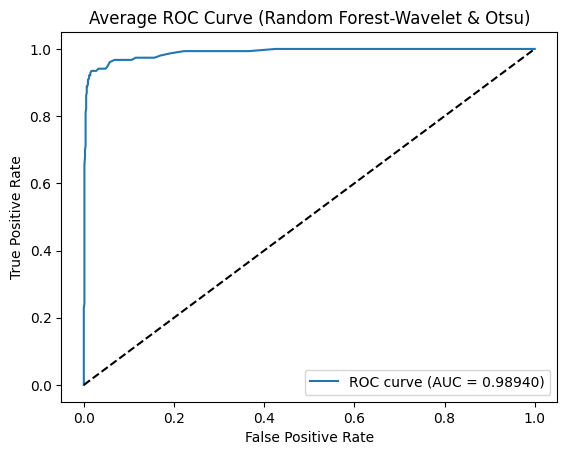

AUC (ROC): 0.98940


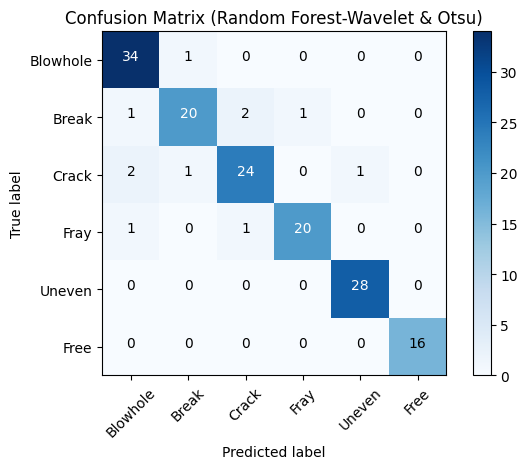

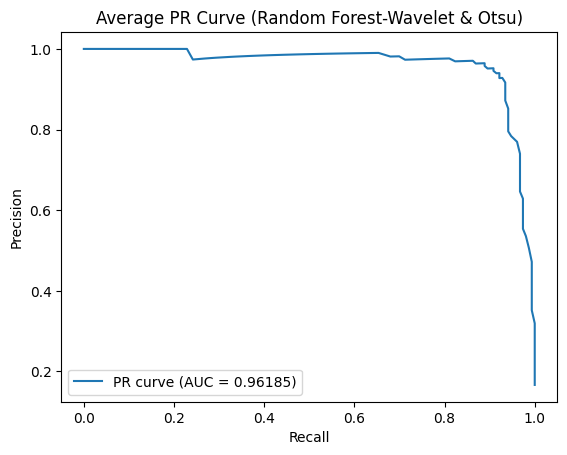

In [26]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Random Forest-Wavelet & Otsu)')  
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (Random Forest-Wavelet & Otsu)') 
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (Random Forest-Wavelet & Otsu)') 
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)  # Use the predict_proba to get probabilities.
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/wavelet_otsu'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    # Create a random forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/wavelet_otsu/rf_model.pkl'
    
    # Save the trained model
    joblib.dump(rf_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(rf_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 7. Decision Tree - Wavelet & Otsu:

Training Time: 0.13180 seconds
Model saved as /Users/surq/workspace/final_p/models/wavelet_otsu/dt_model.pkl
Accuracy: 0.72549
Precision: 0.75200
Recall: 0.74423
F1 Score: 0.74695


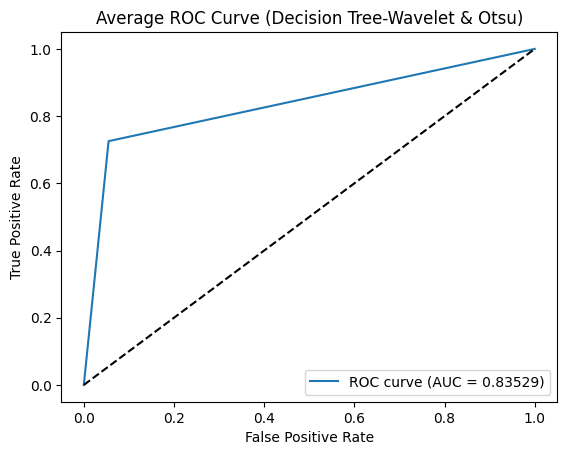

AUC (ROC): 0.83529


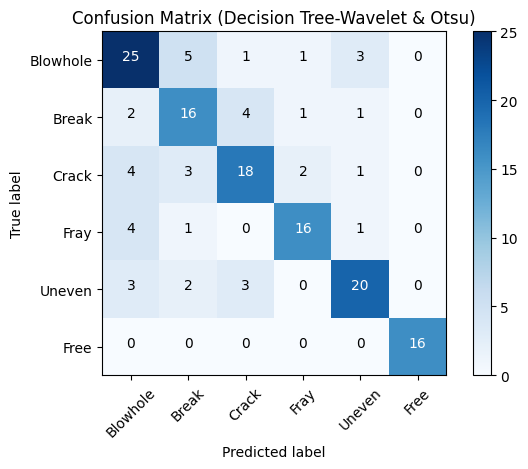

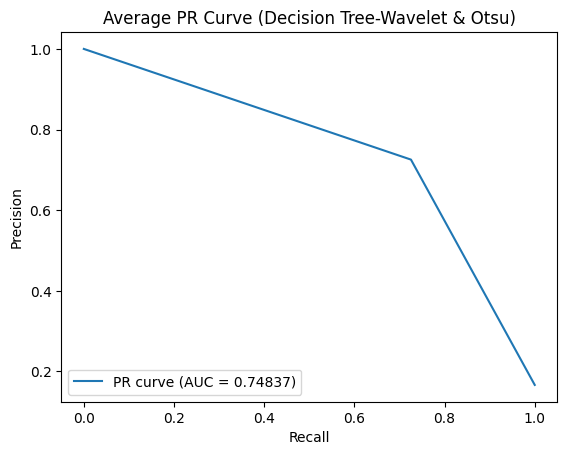

In [27]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Decision Tree-Wavelet & Otsu)')  
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (Decision Tree-Wavelet & Otsu)') 
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (Decision Tree-Wavelet & Otsu)') 
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)  # Use the predict_proba to get probabilities.
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/wavelet_otsu'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    # Create a decision tree model
    dt_model = DecisionTreeClassifier(random_state=42)  # Changed to DecisionTreeClassifier
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    dt_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/wavelet_otsu/dt_model.pkl'  # Changed the model name to dt_model.pkl
    
    # Save the trained model
    joblib.dump(dt_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(dt_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 8. ROC Curve and P-R Curve of Wavelet & Otsu Dataset:

#### The following code is used to generate the ROC curve and P-R curve of the above 5 models for comparison. The path of the dataset still needs to be filled in the path of the main dataset folder, and then the code will automatically find the images and labels of the test set. The above 5 training codes all save the trained models. In the following code, you need to fill in the path of each saved model.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


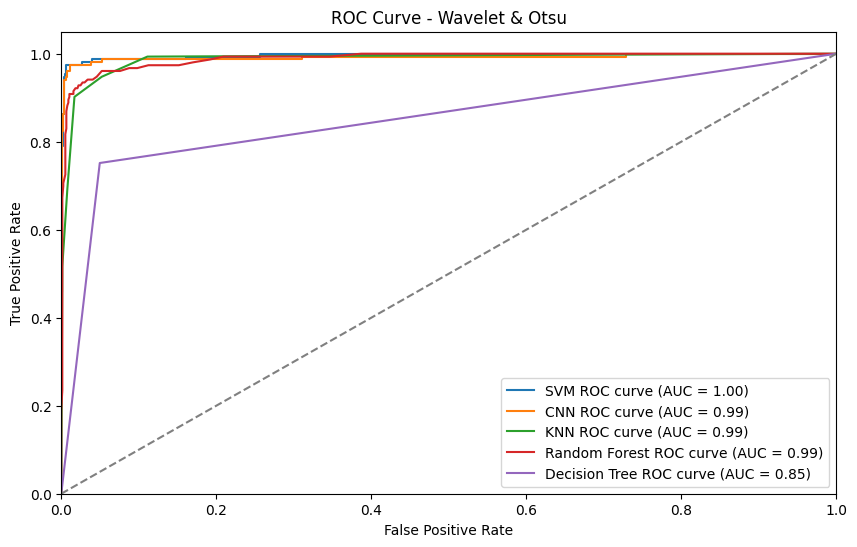

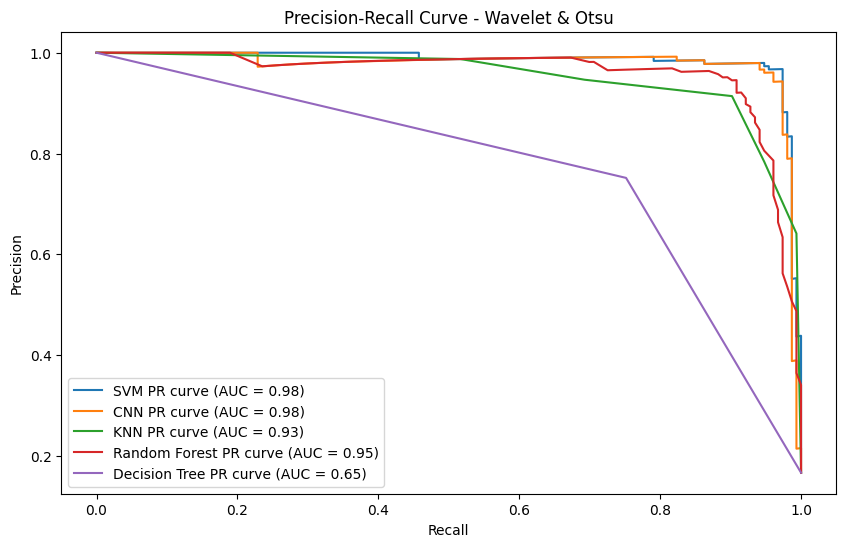

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import joblib
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import itertools


# Function to load dataset
def load_dataset(main_folder_path):
    images_train, labels_train, images_test, labels_test = [], [], [], []

    # Define paths
    images_train_path = os.path.join(main_folder_path, 'images', 'train')
    labels_train_path = os.path.join(main_folder_path, 'labels', 'train')
    images_test_path = os.path.join(main_folder_path, 'images', 'test')
    labels_test_path = os.path.join(main_folder_path, 'labels', 'test')

    # Load training data
    for label_file in os.listdir(labels_train_path):
        label = int(open(os.path.join(labels_train_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(
            os.path.join(images_train_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_train_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_train.append(img.numpy())
        labels_train.append(label)

    # Load test data
    for label_file in os.listdir(labels_test_path):
        label = int(open(os.path.join(labels_test_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(
            os.path.join(images_test_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_test_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_test.append(img.numpy())
        labels_test.append(label)

    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)


if __name__ == "__main__":
    main_folder_path = '/Users/surq/workspace/final_p/wavelet_otsu'

    # Load dataset
    x_train, y_train, x_test, y_test = load_dataset(main_folder_path)
    x_test_cnn = x_test / 255.0  # Normalize for CNN
    x_test_svm_knn = x_test.reshape(x_test.shape[0], -1)  # Flatten for SVM and KNN

    # Load models
    # SVM model
    svm_model_path = '/Users/surq/workspace/final_p/models/wavelet_otsu/svm_model.pkl'
    svm_model = joblib.load(svm_model_path)

    # CNN model
    cnn_model_path = '/Users/surq/workspace/final_p/models/wavelet_otsu/cnn_model.keras'
    cnn_model = tf.keras.models.load_model(cnn_model_path)

    # KNN model
    knn_model_path = '/Users/surq/workspace/final_p/models/wavelet_otsu/knn_model.pkl'
    knn_model = joblib.load(knn_model_path)

    # Random Forest model
    rf_model_path = '/Users/surq/workspace/final_p/models/wavelet_otsu/rf_model.pkl'
    rf_model = joblib.load(rf_model_path)

    # Decision Tree model
    dt_model_path = '/Users/surq/workspace/final_p/models/wavelet_otsu/dt_model.pkl'
    dt_model = joblib.load(dt_model_path)

    # Binarize labels
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

    # Generate predictions and probabilities for each model
    # SVM
    svm_y_pred_prob = svm_model.predict_proba(x_test_svm_knn)

    # CNN
    cnn_y_pred_prob = cnn_model.predict(x_test_cnn)

    # KNN
    knn_y_pred_prob = knn_model.predict_proba(x_test_svm_knn)

    # Random Forest
    rf_y_pred_prob = rf_model.predict_proba(x_test_svm_knn)

    # Decision Tree
    dt_y_pred_prob = dt_model.predict_proba(x_test_svm_knn)

    # Calculate and plot ROC curves
    plt.figure(figsize=(10, 6))
    # SVM ROC
    svm_fpr, svm_tpr, _ = roc_curve(y_test_bin.ravel(), svm_y_pred_prob.ravel())
    svm_roc_auc = auc(svm_fpr, svm_tpr)
    plt.plot(svm_fpr, svm_tpr, label=f'SVM ROC curve (AUC = {svm_roc_auc:.2f})')

    # CNN ROC
    cnn_fpr, cnn_tpr, _ = roc_curve(y_test_bin.ravel(), cnn_y_pred_prob.ravel())
    cnn_roc_auc = auc(cnn_fpr, cnn_tpr)
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN ROC curve (AUC = {cnn_roc_auc:.2f})')

    # KNN ROC
    knn_fpr, knn_tpr, _ = roc_curve(y_test_bin.ravel(), knn_y_pred_prob.ravel())
    knn_roc_auc = auc(knn_fpr, knn_tpr)
    plt.plot(knn_fpr, knn_tpr, label=f'KNN ROC curve (AUC = {knn_roc_auc:.2f})')

    # Random Forest ROC
    rf_fpr, rf_tpr, _ = roc_curve(y_test_bin.ravel(), rf_y_pred_prob.ravel())
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    plt.plot(rf_fpr, rf_tpr, label=f'Random Forest ROC curve (AUC = {rf_roc_auc:.2f})')

    # Decision Tree ROC
    dt_fpr, dt_tpr, _ = roc_curve(y_test_bin.ravel(), dt_y_pred_prob.ravel())
    dt_roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree ROC curve (AUC = {dt_roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Wavelet & Otsu')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate and plot PR curves
    plt.figure(figsize=(10, 6))
    # SVM PR
    svm_precision, svm_recall, _ = precision_recall_curve(y_test_bin.ravel(), svm_y_pred_prob.ravel())
    svm_pr_auc = average_precision_score(y_test_bin, svm_y_pred_prob, average="macro")
    plt.plot(svm_recall, svm_precision, label=f'SVM PR curve (AUC = {svm_pr_auc:.2f})')

    # CNN PR
    cnn_precision, cnn_recall, _ = precision_recall_curve(y_test_bin.ravel(), cnn_y_pred_prob.ravel())
    cnn_pr_auc = average_precision_score(y_test_bin, cnn_y_pred_prob, average="macro")
    plt.plot(cnn_recall, cnn_precision, label=f'CNN PR curve (AUC = {cnn_pr_auc:.2f})')

    # KNN PR
    knn_precision, knn_recall, _ = precision_recall_curve(y_test_bin.ravel(), knn_y_pred_prob.ravel())
    knn_pr_auc = average_precision_score(y_test_bin, knn_y_pred_prob, average="macro")
    plt.plot(knn_recall, knn_precision, label=f'KNN PR curve (AUC = {knn_pr_auc:.2f})')

    # Random Forest PR
    rf_precision, rf_recall, _ = precision_recall_curve(y_test_bin.ravel(), rf_y_pred_prob.ravel())
    rf_pr_auc = average_precision_score(y_test_bin, rf_y_pred_prob, average="macro")
    plt.plot(rf_recall, rf_precision, label=f'Random Forest PR curve (AUC = {rf_pr_auc:.2f})')

    # Decision Tree PR
    dt_precision, dt_recall, _ = precision_recall_curve(y_test_bin.ravel(), dt_y_pred_prob.ravel())
    dt_pr_auc = average_precision_score(y_test_bin, dt_y_pred_prob, average="macro")
    plt.plot(dt_recall, dt_precision, label=f'Decision Tree PR curve (AUC = {dt_pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Wavelet & Otsu')
    plt.legend(loc='lower left')
    plt.show()

## VIII. Training on the Otsu & Wavelet Dataset.

### 1. Introduction:

#### The dataset trained in this section is the original dataset after Otsu binarization and then wavelet transform. The final training time of the model becomes the processing time of the binarization + wavelet transform + the training time of the model. Note that in the training code of each model, the input path needs to be changed to the path of the dataset that is first binarized and then wavelet transformed.

### 2. Wavelet Transform After Otsu Binarization:

#### The following code performs wavelet transform based on V. 2. Otsu Binary，the Otsu Binarization dataset is input into the following wavelet transform process. The names of the images and labels in the dataset are also changed accordingly. For example, the name of a image in the Otsu Binary dataset is "exp0_bin_797.jpg". After wavelet transform, the name is changed to "exp0_bwt_797.jpg". The final training time is V. 2. Otsu Binary time + VIII. 2. wavelet transform after Otsu Binarization time + model training time.

In [27]:
import os
import cv2
import pywt
import numpy as np
from tqdm import tqdm
import shutil
import time  # For time measurement

def apply_wavelet_transform(image, wavelet='bior3.5', level=3):
    """
    Apply 2D Discrete Wavelet Transform (DWT) with a combination of 
    low-frequency and high-frequency components, followed by contrast enhancement.

    Parameters:
        image (numpy.ndarray): The input grayscale image.
        wavelet (str): The wavelet function to use (default: 'bior3.5').
        level (int): Number of decomposition levels (default: 3).

    Returns:
        numpy.ndarray: The transformed image with enhanced details, 
                       maintaining the same size as the input.
    """
    # 1. Perform multi-level wavelet decomposition
    coeffs2 = pywt.wavedec2(image, wavelet, level=level)

    # 2. Extract the approximation (low-frequency) and detail (high-frequency) coefficients
    cA = coeffs2[0]  # Approximation (low-frequency)
    cH, cV, cD = coeffs2[1][0], coeffs2[1][1], coeffs2[1][2]  # High-frequency details

    # 3. Combine low-frequency and high-frequency information to enhance edges/textures
    combined = cA + 0.5 * (np.abs(cH) + np.abs(cV) + np.abs(cD))

    # 4. Replace the approximation coefficients with the combined result 
    #    and set all detail coefficients to zero before the inverse transform
    coeffs2[0] = combined
    coeffs2[1:] = [tuple(np.zeros_like(c) for c in level) for level in coeffs2[1:]]
    reconstructed_img = pywt.waverec2(coeffs2, wavelet)

    # 5. Normalize the image to the range 0-255
    reconstructed_img = cv2.normalize(reconstructed_img, None, 0, 255, cv2.NORM_MINMAX)
    transformed_img = reconstructed_img.astype(np.uint8)

    # 6. Apply histogram equalization for additional contrast enhancement
    transformed_img = cv2.equalizeHist(transformed_img)

    return transformed_img


def process_dataset(input_folder, output_folder, wavelet='bior3.5', level=3):
    """
    Process an entire dataset using the wavelet transform function and save
    the resulting images (and corresponding label files) into a new folder structure.

    Parameters:
        input_folder (str): Path to the input dataset folder.
        output_folder (str): Path where the processed dataset will be saved.
        wavelet (str): The wavelet function to use (default: 'bior3.5').
        level (int): Number of decomposition levels (default: 3).
    """
    # Start time measurement
    start_time = time.time()

    # 1. Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 2. Define the paths for images and labels inside the input folder
    input_images_path = os.path.join(input_folder, 'images')
    input_labels_path = os.path.join(input_folder, 'labels')
    output_images_path = os.path.join(output_folder, 'images')
    output_labels_path = os.path.join(output_folder, 'labels')

    # 3. Get all subfolder names (representing defect classes), ignoring hidden files
    defect_classes = [d for d in os.listdir(input_images_path) if not d.startswith('.')]

    # 4. Process each defect category folder
    for defect_name in defect_classes:
        # Paths for the current defect category in input and output
        input_image_class_path = os.path.join(input_images_path, defect_name)
        input_label_class_path = os.path.join(input_labels_path, defect_name)
        output_image_class_path = os.path.join(output_images_path, defect_name)
        output_label_class_path = os.path.join(output_labels_path, defect_name)

        # Create corresponding output folders for the current category
        os.makedirs(output_image_class_path, exist_ok=True)
        os.makedirs(output_label_class_path, exist_ok=True)

        # 5. Process each image in the current category
        for filename in tqdm(
            [f for f in os.listdir(input_image_class_path) if not f.startswith('.')],
            desc=f"Processing {defect_name}"
        ):
            if filename.endswith('.jpg'):
                # a) Read the image in grayscale
                img_path = os.path.join(input_image_class_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # b) Apply wavelet transform
                transformed_img = apply_wavelet_transform(img, wavelet=wavelet, level=level)

                # c) Save the transformed image (replace 'num' with 'wto' in the filename)
                new_filename = filename.replace('bin', 'bwt')
                new_img_path = os.path.join(output_image_class_path, new_filename)
                cv2.imwrite(new_img_path, transformed_img)

                # d) Process the corresponding label file (replace extension .jpg with .txt)
                label_filename = filename.replace('.jpg', '.txt')
                label_path = os.path.join(input_label_class_path, label_filename)

                if os.path.exists(label_path):
                    # Copy the label file to the new location, also replacing 'num' with 'wto'
                    new_label_filename = label_filename.replace('bin', 'bwt')
                    new_label_path = os.path.join(output_label_class_path, new_label_filename)
                    shutil.copy(label_path, new_label_path)

    # End time measurement
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Processing completed. Elapsed time: {elapsed_time:.2f} seconds")


if __name__ == "__main__":
    # Input dataset main folder path
    input_folder = "/Users/surq/workspace/final_p/otsu_dataset"  # Example dataset path

    # Output folder path for saving processed dataset
    output_folder = "/Users/surq/workspace/final_p/otsu_wavelet"  # Example output path

    # Parameters
    wavelet = 'bior3.5'  # Biorthogonal wavelet
    level = 3            # Decomposition level

    # Execute the dataset processing
    process_dataset(input_folder, output_folder, wavelet=wavelet, level=level)

Processing test:   0%|                                  | 0/153 [00:00<?, ?it/s]/opt/anaconda3/envs/yolov7/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(
Processing train: 100%|█████████████████████| 459/459 [00:00<00:00, 1060.51it/s]

Processing completed. Elapsed time: 0.58 seconds


### 3. SVM - Otsu & Wavelet:

Training Time: 0.15719 seconds
Model saved as /Users/surq/workspace/final_p/models/otsu_wavelet/svm_model.pkl
Accuracy: 0.88889
Precision: 0.89485
Recall: 0.89493
F1 Score: 0.89432


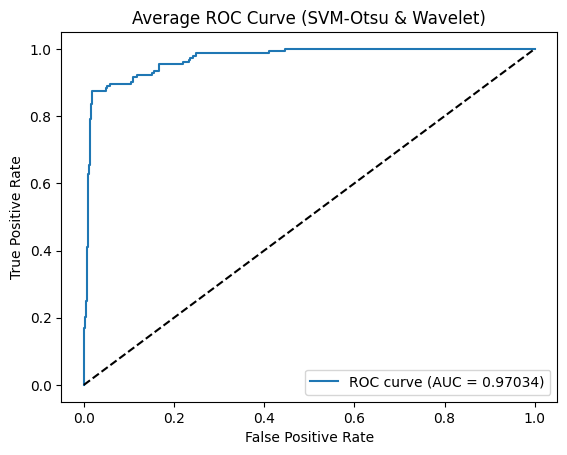

AUC (ROC): 0.97034


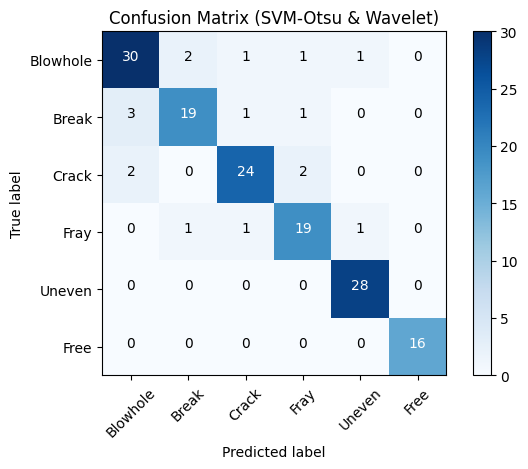

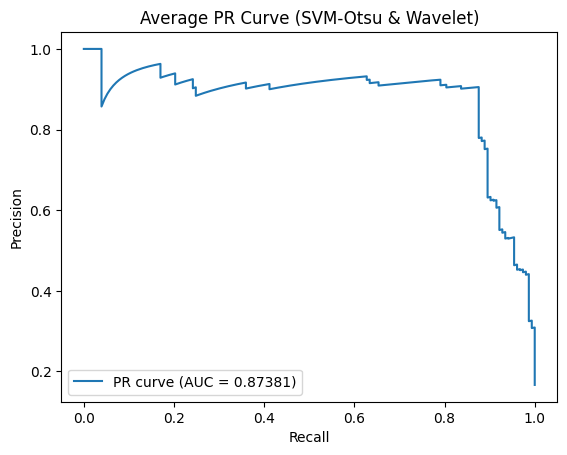

In [29]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (SVM-Otsu & Wavelet)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (SVM-Otsu & Wavelet)')
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (SVM-Otsu & Wavelet)')
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.decision_function(X)  # Get decision scores for each class
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/otsu_wavelet'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)  # Enable probability output for AUC calculation
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    svm_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/otsu_wavelet/svm_model.pkl'  # Specify your desired path here
    
    # Save the trained model
    joblib.dump(svm_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(svm_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 4. CNN - Otsu & Wavelet:

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.2255 - loss: 1.7148 - val_accuracy: 0.3399 - val_loss: 1.6020 - learning_rate: 3.5000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.4223 - loss: 1.5237 - val_accuracy: 0.5229 - val_loss: 1.2144 - learning_rate: 3.5000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5329 - loss: 1.1370 - val_accuracy: 0.6078 - val_loss: 1.0521 - learning_rate: 3.5000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5775 - loss: 1.0246 - val_accuracy: 0.7059 - val_loss: 0.8956 - learning_rate: 3.5000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7029 - loss: 0.7883 - val_accuracy: 0.7059 - val_loss: 0.8113 - learning_rate: 3.5000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7877 - loss: 0.6065 - val_accuracy: 0.7843 - val_loss: 0.5760 - learning_rate: 3.5000e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 

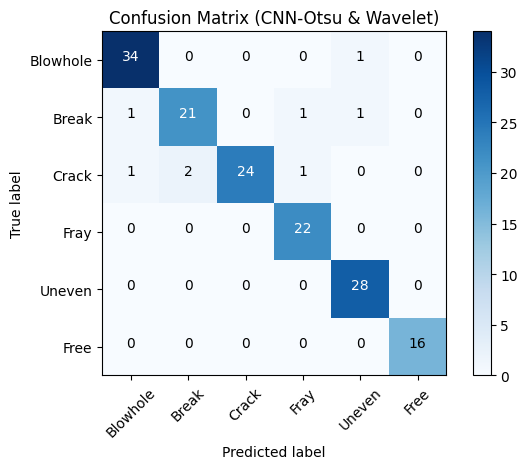

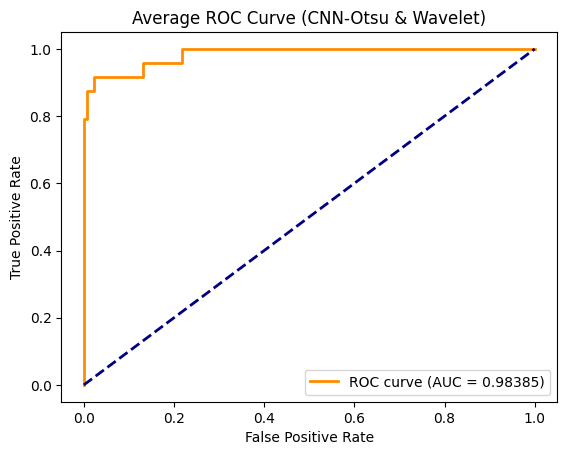

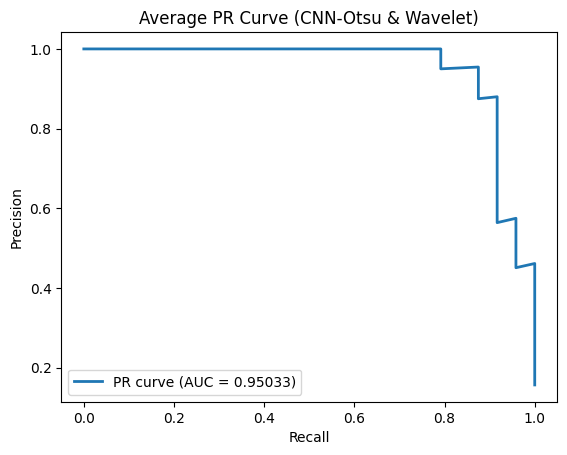


Model saved as /Users/surq/workspace/final_p/models/otsu_wavelet/cnn_model.keras

Training time: 79.59128 seconds


In [30]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import itertools

# Function to load dataset
def load_dataset(main_folder_path):
    images_train, labels_train, images_test, labels_test = [], [], [], []
    
    # Define paths
    images_train_path = os.path.join(main_folder_path, 'images', 'train')
    labels_train_path = os.path.join(main_folder_path, 'labels', 'train')
    images_test_path = os.path.join(main_folder_path, 'images', 'test')
    labels_test_path = os.path.join(main_folder_path, 'labels', 'test')
    
    # Load training data
    for label_file in os.listdir(labels_train_path):
        label = int(open(os.path.join(labels_train_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(os.path.join(images_train_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_train_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_train.append(img.numpy())
        labels_train.append(label)
    
    # Load test data
    for label_file in os.listdir(labels_test_path):
        label = int(open(os.path.join(labels_test_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(os.path.join(images_test_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_test_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_test.append(img.numpy())
        labels_test.append(label)
    
    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)

# Define a CNN model
def create_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00035),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (CNN-Otsu & Wavelet)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Main program
if __name__ == '__main__':
    main_folder_path = '/Users/surq/workspace/final_p/otsu_wavelet'
    
    # Load dataset
    x_train, y_train, x_test, y_test = load_dataset(main_folder_path)
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # Create and train model
    model = create_cnn_model()
    start_time = time.time()
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[lr_scheduler])
    training_time = time.time() - start_time

    # Evaluate model
    y_pred_prob = model.predict(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Generate evaluation metrics
    overall_accuracy = accuracy_score(y_test, y_pred)
    overall_precision = precision_score(y_test, y_pred, average='weighted')
    overall_recall = recall_score(y_test, y_pred, average='weighted')
    overall_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\nOverall Accuracy: {overall_accuracy:.5f}")
    print(f"Overall Precision: {overall_precision:.5f}")
    print(f"Overall Recall: {overall_recall:.5f}")
    print(f"Overall F1 Score: {overall_f1:.5f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free'])

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (CNN-Otsu & Wavelet)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label='PR curve (AUC = {:.5f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (CNN-Otsu & Wavelet)')
    plt.legend(loc="lower left")
    plt.show()

    # Save model
    model_save_path = '/Users/surq/workspace/final_p/models/otsu_wavelet/cnn_model.keras'  # Specify your desired path here
    model.save(model_save_path)
    print(f"\nModel saved as {model_save_path}")
    
    # Output training time
    print(f"\nTraining time: {training_time:.5f} seconds")

### 5. KNN - Otsu & Wavelet:

Accuracy: 0.82353
Precision: 0.83169
Recall: 0.83564
F1 Score: 0.83188
Training Time: 0.00230 seconds


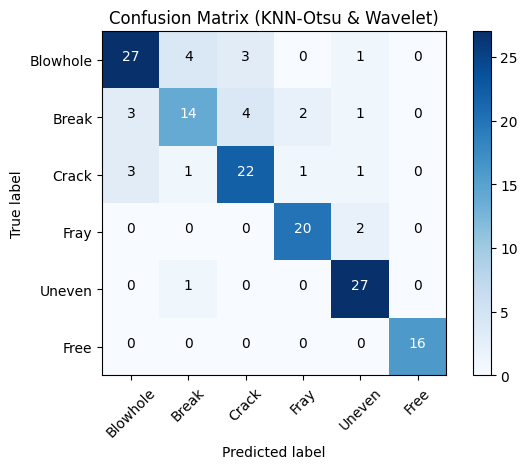

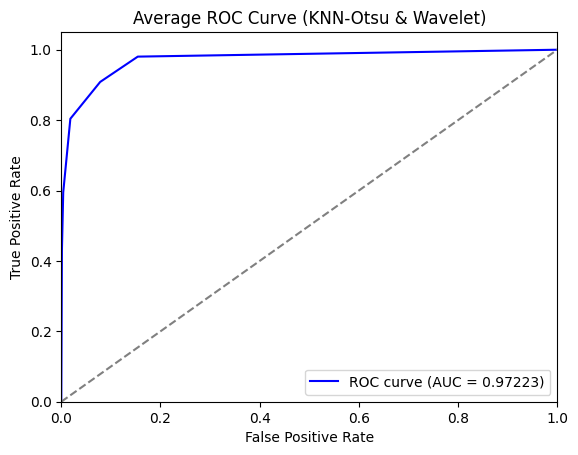

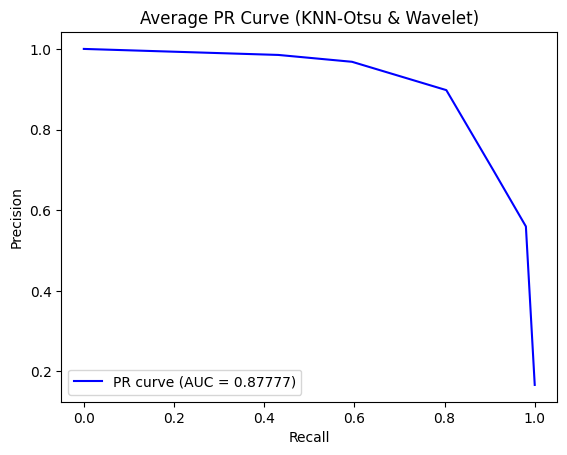

Model saved as /Users/surq/workspace/final_p/models/otsu_wavelet/knn_model.pkl


In [31]:
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import time
import joblib  # For saving the model
import itertools

# Load dataset from the given main folder path
def load_dataset(main_folder):
    image_folder = os.path.join(main_folder, 'images')
    label_folder = os.path.join(main_folder, 'labels')

    images_train = []
    labels_train = []
    images_test = []
    labels_test = []

    # Load train images and labels
    train_image_folder = os.path.join(image_folder, 'train')
    train_label_folder = os.path.join(label_folder, 'train')
    for filename in os.listdir(train_image_folder):
        if filename.endswith(('.jpg', '.png')):
            base_name = os.path.splitext(filename)[0]
            label_path = os.path.join(train_label_folder, base_name + '.txt')
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as file:
                defect_type = int(file.readline().strip())

            img_path = os.path.join(train_image_folder, filename)
            img = np.array(Image.open(img_path).convert('L').resize((64, 64)))  # Load and resize image
            images_train.append(img.flatten())  # Flatten the image
            labels_train.append(defect_type)
    
    # Load test images and labels
    test_image_folder = os.path.join(image_folder, 'test')
    test_label_folder = os.path.join(label_folder, 'test')
    for filename in os.listdir(test_image_folder):
        if filename.endswith(('.jpg', '.png')):
            base_name = os.path.splitext(filename)[0]
            label_path = os.path.join(test_label_folder, base_name + '.txt')
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as file:
                defect_type = int(file.readline().strip())

            img_path = os.path.join(test_image_folder, filename)
            img = np.array(Image.open(img_path).convert('L').resize((64, 64)))  # Load and resize image
            images_test.append(img.flatten())  # Flatten the image
            labels_test.append(defect_type)

    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (KNN-Otsu & Wavelet)')
    plt.colorbar()  # Display color bar
    tick_marks = np.arange(len(classes))  # Tick marks for the labels
    plt.xticks(tick_marks, classes, rotation=45)  # Label x axis with classes
    plt.yticks(tick_marks, classes)  # Label y axis with classes
    
    fmt = 'd'  # Format the numbers in the matrix
    thresh = cm.max() / 2  # Define a threshold for coloring text
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),  # Format as integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")  # Choose text color based on threshold

    plt.ylabel('True label')  # Label y-axis
    plt.xlabel('Predicted label')  # Label x-axis
    plt.tight_layout()  # Adjust layout to avoid overlapping
    plt.show()  # Display the plot

# Train and evaluate KNN model
def train_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    # Start measuring the training time
    start_time = time.time()

    knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=n_neighbors))
    knn.fit(X_train, y_train)

    # End measuring the training time
    end_time = time.time()
    training_time = end_time - start_time
    
    # Predict on the test set
    y_pred = knn.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"F1 Score: {f1:.5f}")
    print(f"Training Time: {training_time:.5f} seconds")  # Show time with 5 decimal places

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free'])

    # ROC curve and AUC
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])  # Binarize the labels
    y_pred_prob = knn.predict_proba(X_test)  # Get probabilities for each class
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (KNN-Otsu & Wavelet)')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    pr_auc = average_precision_score(y_test_bin, y_pred_prob, average="macro")

    plt.figure()
    plt.plot(recall, precision, color='b', label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (KNN-Otsu & Wavelet)')
    plt.legend(loc='lower left')
    plt.show()

    # Save the model
    model_save_path = '/Users/surq/workspace/final_p/models/otsu_wavelet/knn_model.pkl'  # Modify this to the desired path
    joblib.dump(knn, model_save_path)  # Save the trained model
    print(f"Model saved as {model_save_path}")

# Main function
def main():
    main_folder = '/Users/surq/workspace/final_p/otsu_wavelet'  # Modify this path if needed

    # Load dataset
    X_train, y_train, X_test, y_test = load_dataset(main_folder)

    # Train and evaluate KNN model
    train_knn(X_train, y_train, X_test, y_test)

if __name__ == "__main__":
    main()

### 6. Random Forest - Otsu & Wavelet:

Training Time: 0.68469 seconds
Model saved as /Users/surq/workspace/final_p/models/otsu_wavelet/rf_model.pkl
Accuracy: 0.91503
Precision: 0.92207
Recall: 0.91981
F1 Score: 0.91924


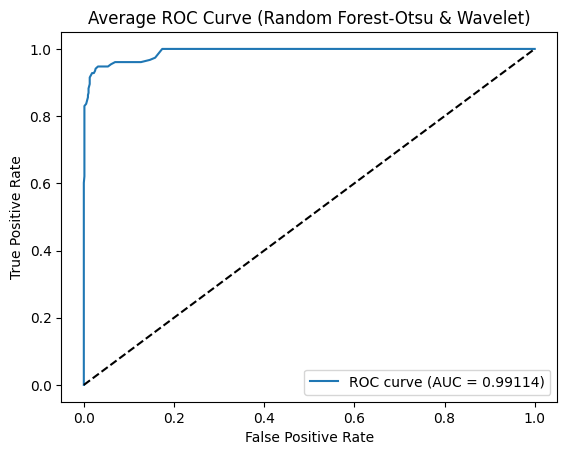

AUC (ROC): 0.99114


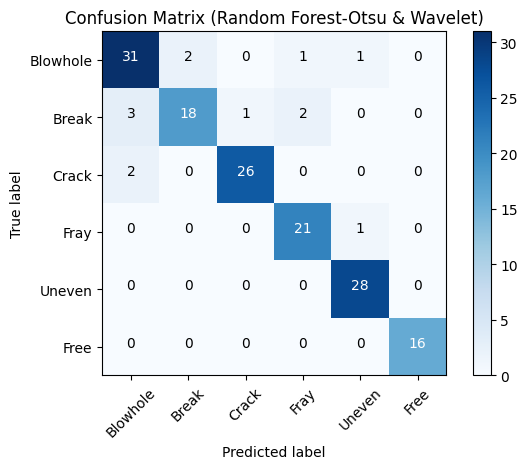

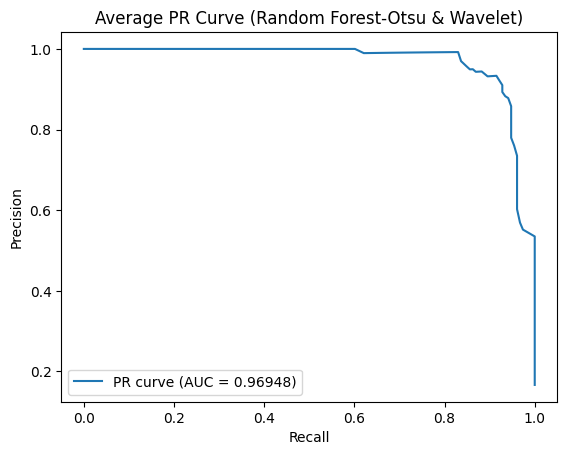

In [32]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Random Forest-Otsu & Wavelet)')  
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (Random Forest-Otsu & Wavelet)') 
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (Random Forest-Otsu & Wavelet)') 
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)  # Use the predict_proba to get probabilities.
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/otsu_wavelet'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    # Create a random forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/otsu_wavelet/rf_model.pkl'
    
    # Save the trained model
    joblib.dump(rf_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(rf_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 7. Decision Tree - Otsu & Wavelet:

Training Time: 0.61510 seconds
Model saved as /Users/surq/workspace/final_p/models/otsu_wavelet/dt_model.pkl
Accuracy: 0.72549
Precision: 0.74779
Recall: 0.74509
F1 Score: 0.74127


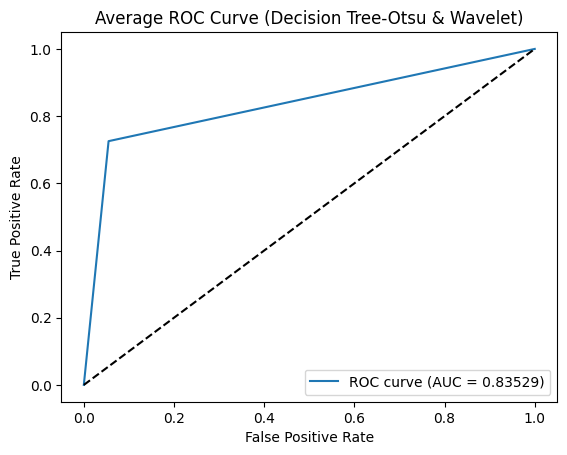

AUC (ROC): 0.83529


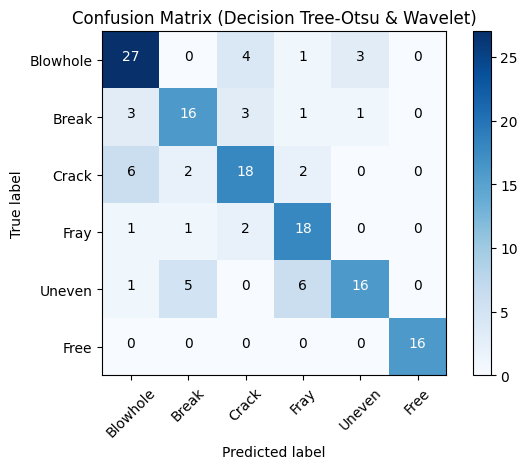

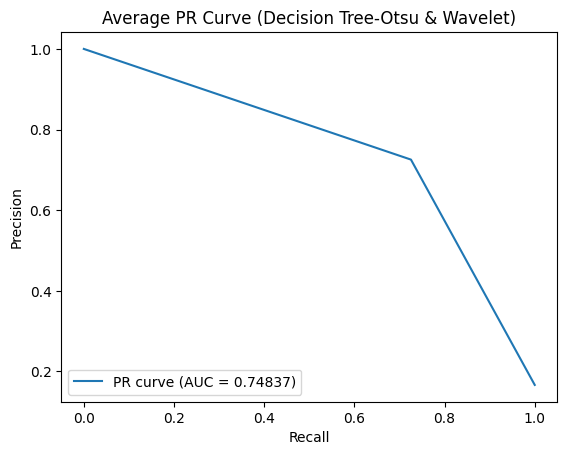

In [33]:
import os
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib  # For saving and loading models
import itertools  # For iterating through confusion matrix indices

def load_dataset(image_folder, label_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png')):  # Support both .jpg and .png formats
            base_name = filename.rsplit('.', 1)[0]  # Remove the file extension
            label_path = os.path.join(label_folder, base_name + '.txt')
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as file:
                    defect_type = int(file.readline().strip())
            else:
                raise ValueError(f"Label file for {base_name} is missing or empty.")
            
            img_path = os.path.join(image_folder, filename)
            
            # Check if image size is 64x64
            img = Image.open(img_path)
            if img.size != (64, 64):
                raise ValueError(f"Image {filename} is not 64x64 pixels.")
            
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(defect_type)
    
    return np.array(images), np.array(labels)

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Decision Tree-Otsu & Wavelet)')  
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_score):
    # Compute average ROC curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve (Decision Tree-Otsu & Wavelet)') 
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc  # Return AUC to ensure consistency in reporting

def plot_pr_curve(y_true, y_score):
    # Compute average PR curve
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    
    # Calculate AUC for PR curve
    pr_auc = auc(recall, precision)
    
    # Plot PR curve with AUC
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.5f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average PR Curve (Decision Tree-Otsu & Wavelet)') 
    plt.legend(loc='lower left')
    plt.show()

def evaluate_model(model, X, y, classes):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)  # Use the predict_proba to get probabilities.
    n_classes = len(classes)
    
    # Binarize labels for ROC and PR curve calculations
    y_bin = label_binarize(y, classes=range(n_classes))
    
    # Calculate evaluation metrics
    cm = confusion_matrix(y, y_pred)
    print("Accuracy: {:.5f}".format(accuracy_score(y, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y, y_pred, average='macro', zero_division=0)))
    print("Recall: {:.5f}".format(recall_score(y, y_pred, average='macro', zero_division=0)))
    print("F1 Score: {:.5f}".format(f1_score(y, y_pred, average='macro', zero_division=0)))
    
    # Calculate and display AUC for ROC curve
    roc_auc = plot_roc_curve(y_bin, y_pred_proba)
    print("AUC (ROC): {:.5f}".format(roc_auc))  # Display the same AUC as in the ROC curve plot
    
    plot_confusion_matrix(cm, classes)
    plot_pr_curve(y_bin, y_pred_proba)

def main():
    main_folder = '/Users/surq/workspace/final_p/otsu_wavelet'  # Specify the main folder path

    # Automatically locate the subfolders for images and labels
    train_image_folder = os.path.join(main_folder, 'images/train')
    train_label_folder = os.path.join(main_folder, 'labels/train')
    val_image_folder = os.path.join(main_folder, 'images/test')
    val_label_folder = os.path.join(main_folder, 'labels/test')

    X_train, y_train = load_dataset(train_image_folder, train_label_folder)
    X_val, y_val = load_dataset(val_image_folder, val_label_folder)
    
    # Create a decision tree model
    dt_model = DecisionTreeClassifier(random_state=42)  # Changed to DecisionTreeClassifier
    
    # Record the start time
    start_time = time.time()
    
    # Train the model
    dt_model.fit(X_train, y_train)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.5f} seconds")
    
    # Define the model save path
    model_save_path = '/Users/surq/workspace/final_p/models/otsu_wavelet/dt_model.pkl'  # Changed the model name to dt_model.pkl
    
    # Save the trained model
    joblib.dump(dt_model, model_save_path)
    print(f"Model saved as {model_save_path}")
    
    classes = ['Blowhole', 'Break', 'Crack', 'Fray', 'Uneven', 'Free']
    evaluate_model(dt_model, X_val, y_val, classes)

if __name__ == "__main__":
    main()

### 6. ROC Curve and P-R Curve of Otsu & Wavelet Dataset:

#### The following code is used to generate the ROC curve and P-R curve of the above 5 models for comparison. The path of the dataset still needs to be filled in the path of the main dataset folder, and then the code will automatically find the images and labels of the test set. The above 5 training codes all save the trained models. In the following code, you need to fill in the path of each saved model.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


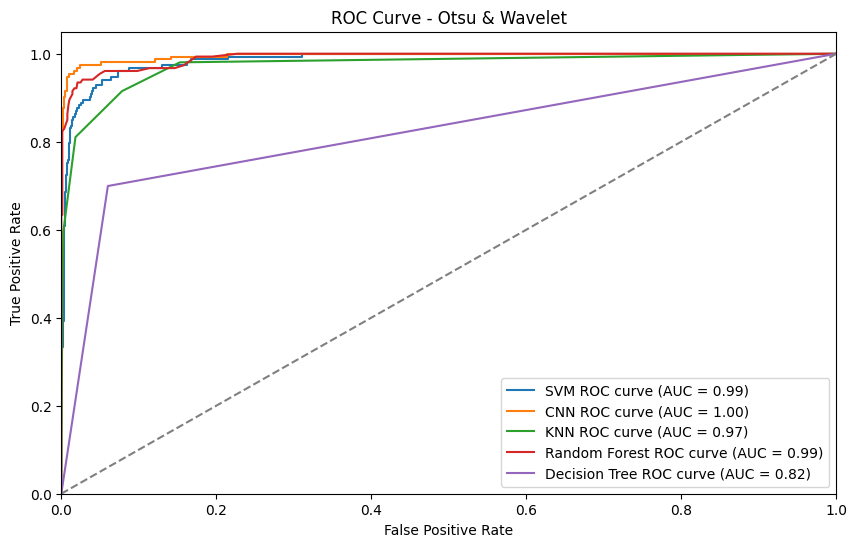

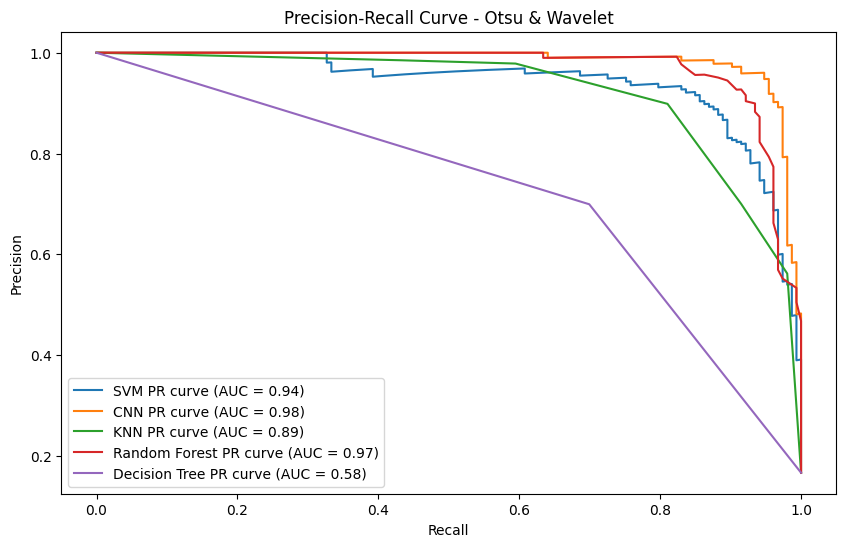

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import joblib
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import itertools


# Function to load dataset
def load_dataset(main_folder_path):
    images_train, labels_train, images_test, labels_test = [], [], [], []

    # Define paths
    images_train_path = os.path.join(main_folder_path, 'images', 'train')
    labels_train_path = os.path.join(main_folder_path, 'labels', 'train')
    images_test_path = os.path.join(main_folder_path, 'images', 'test')
    labels_test_path = os.path.join(main_folder_path, 'labels', 'test')

    # Load training data
    for label_file in os.listdir(labels_train_path):
        label = int(open(os.path.join(labels_train_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(
            os.path.join(images_train_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_train_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_train.append(img.numpy())
        labels_train.append(label)

    # Load test data
    for label_file in os.listdir(labels_test_path):
        label = int(open(os.path.join(labels_test_path, label_file)).read().strip())
        img_file = label_file.replace('.txt', '.jpg') if os.path.exists(
            os.path.join(images_test_path, label_file.replace('.txt', '.jpg'))) else label_file.replace('.txt', '.png')
        img = tf.io.read_file(os.path.join(images_test_path, img_file))
        img = tf.image.decode_image(img, channels=1)
        images_test.append(img.numpy())
        labels_test.append(label)

    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)


if __name__ == "__main__":
    main_folder_path = '/Users/surq/workspace/final_p/otsu_wavelet'

    # Load dataset
    x_train, y_train, x_test, y_test = load_dataset(main_folder_path)
    x_test_cnn = x_test / 255.0  # Normalize for CNN
    x_test_svm_knn = x_test.reshape(x_test.shape[0], -1)  # Flatten for SVM and KNN

    # Load models
    # SVM model
    svm_model_path = '/Users/surq/workspace/final_p/models/otsu_wavelet/svm_model.pkl'
    svm_model = joblib.load(svm_model_path)

    # CNN model
    cnn_model_path = '/Users/surq/workspace/final_p/models/otsu_wavelet/cnn_model.keras'
    cnn_model = tf.keras.models.load_model(cnn_model_path)

    # KNN model
    knn_model_path = '/Users/surq/workspace/final_p/models/otsu_wavelet/knn_model.pkl'
    knn_model = joblib.load(knn_model_path)

    # Random Forest model
    rf_model_path = '/Users/surq/workspace/final_p/models/otsu_wavelet/rf_model.pkl'
    rf_model = joblib.load(rf_model_path)

    # Decision Tree model
    dt_model_path = '/Users/surq/workspace/final_p/models/otsu_wavelet/dt_model.pkl'
    dt_model = joblib.load(dt_model_path)

    # Binarize labels
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

    # Generate predictions and probabilities for each model
    # SVM
    svm_y_pred_prob = svm_model.predict_proba(x_test_svm_knn)

    # CNN
    cnn_y_pred_prob = cnn_model.predict(x_test_cnn)

    # KNN
    knn_y_pred_prob = knn_model.predict_proba(x_test_svm_knn)

    # Random Forest
    rf_y_pred_prob = rf_model.predict_proba(x_test_svm_knn)

    # Decision Tree
    dt_y_pred_prob = dt_model.predict_proba(x_test_svm_knn)

    # Calculate and plot ROC curves
    plt.figure(figsize=(10, 6))
    # SVM ROC
    svm_fpr, svm_tpr, _ = roc_curve(y_test_bin.ravel(), svm_y_pred_prob.ravel())
    svm_roc_auc = auc(svm_fpr, svm_tpr)
    plt.plot(svm_fpr, svm_tpr, label=f'SVM ROC curve (AUC = {svm_roc_auc:.2f})')

    # CNN ROC
    cnn_fpr, cnn_tpr, _ = roc_curve(y_test_bin.ravel(), cnn_y_pred_prob.ravel())
    cnn_roc_auc = auc(cnn_fpr, cnn_tpr)
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN ROC curve (AUC = {cnn_roc_auc:.2f})')

    # KNN ROC
    knn_fpr, knn_tpr, _ = roc_curve(y_test_bin.ravel(), knn_y_pred_prob.ravel())
    knn_roc_auc = auc(knn_fpr, knn_tpr)
    plt.plot(knn_fpr, knn_tpr, label=f'KNN ROC curve (AUC = {knn_roc_auc:.2f})')

    # Random Forest ROC
    rf_fpr, rf_tpr, _ = roc_curve(y_test_bin.ravel(), rf_y_pred_prob.ravel())
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    plt.plot(rf_fpr, rf_tpr, label=f'Random Forest ROC curve (AUC = {rf_roc_auc:.2f})')

    # Decision Tree ROC
    dt_fpr, dt_tpr, _ = roc_curve(y_test_bin.ravel(), dt_y_pred_prob.ravel())
    dt_roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree ROC curve (AUC = {dt_roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Otsu & Wavelet')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate and plot PR curves
    plt.figure(figsize=(10, 6))
    # SVM PR
    svm_precision, svm_recall, _ = precision_recall_curve(y_test_bin.ravel(), svm_y_pred_prob.ravel())
    svm_pr_auc = average_precision_score(y_test_bin, svm_y_pred_prob, average="macro")
    plt.plot(svm_recall, svm_precision, label=f'SVM PR curve (AUC = {svm_pr_auc:.2f})')

    # CNN PR
    cnn_precision, cnn_recall, _ = precision_recall_curve(y_test_bin.ravel(), cnn_y_pred_prob.ravel())
    cnn_pr_auc = average_precision_score(y_test_bin, cnn_y_pred_prob, average="macro")
    plt.plot(cnn_recall, cnn_precision, label=f'CNN PR curve (AUC = {cnn_pr_auc:.2f})')

    # KNN PR
    knn_precision, knn_recall, _ = precision_recall_curve(y_test_bin.ravel(), knn_y_pred_prob.ravel())
    knn_pr_auc = average_precision_score(y_test_bin, knn_y_pred_prob, average="macro")
    plt.plot(knn_recall, knn_precision, label=f'KNN PR curve (AUC = {knn_pr_auc:.2f})')

    # Random Forest PR
    rf_precision, rf_recall, _ = precision_recall_curve(y_test_bin.ravel(), rf_y_pred_prob.ravel())
    rf_pr_auc = average_precision_score(y_test_bin, rf_y_pred_prob, average="macro")
    plt.plot(rf_recall, rf_precision, label=f'Random Forest PR curve (AUC = {rf_pr_auc:.2f})')

    # Decision Tree PR
    dt_precision, dt_recall, _ = precision_recall_curve(y_test_bin.ravel(), dt_y_pred_prob.ravel())
    dt_pr_auc = average_precision_score(y_test_bin, dt_y_pred_prob, average="macro")
    plt.plot(dt_recall, dt_precision, label=f'Decision Tree PR curve (AUC = {dt_pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Otsu & Wavelet')
    plt.legend(loc='lower left')
    plt.show()

## IX. Grouped Bar Charts.

### 1. Accuracy Grouped Bar Chart:

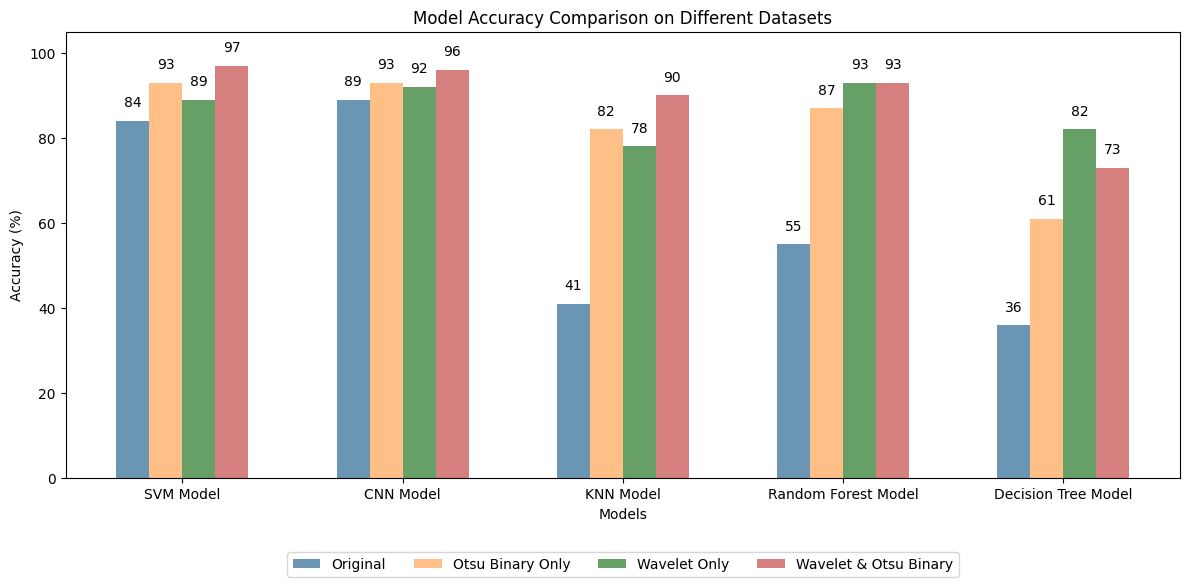

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb, rgb_to_hsv, hsv_to_rgb

# Model names
models = ['SVM Model', 'CNN Model', 'KNN Model', 'Random Forest Model', 'Decision Tree Model']

# Dataset names (remove the last one)
datasets = ['Original', 'Otsu Binary Only', 'Wavelet Only', 'Wavelet & Otsu Binary']

# Accuracy (percentage) of each model on each dataset (remove the last column)
accuracies = [
    [84, 93, 89, 97],  # SVM Model
    [89, 93, 92, 96],  # CNN Model
    [41, 82, 78, 90],  # KNN Model
    [55, 87, 93, 93],  # Random Forest Model
    [36, 61, 82, 73]   # Decision Tree Model
]

# Set the width of the bars
bar_width = 0.15

# Calculate positions for each model
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Original academic color list (remove the last one)
original_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Function to desaturate colors
def desaturate_color(color, saturation_factor=0.5):
    rgb = to_rgb(color)
    hsv = rgb_to_hsv(rgb)
    hsv[1] *= saturation_factor
    new_rgb = hsv_to_rgb(hsv)
    return new_rgb

# Apply desaturation to colors
colors = [desaturate_color(c) for c in original_colors]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Draw bars for each dataset
bars = []
for i in range(len(datasets)):
    positions = [r + i * bar_width for r in range(len(models))]
    bar = ax.bar(positions, [acc[i] for acc in accuracies], width=bar_width, color=colors[i], label=datasets[i])
    bars.append(bar)

    # Display values on top of the bars
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 8),  # Increased offset to prevent overlap
                    textcoords="offset points",
                    ha='center', va='bottom', clip_on=False)  # Prevent text clipping

# Set title and labels
ax.set_title('Model Accuracy Comparison on Different Datasets')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')

# Set x-axis ticks and labels
ax.set_xticks([r + 1.5 * bar_width for r in range(len(models))])
ax.set_xticklabels(models)

# Adjust the y-axis range to provide space for text
ax.set_ylim(0, 105)

# Set y-axis ticks (remove 100+ values)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])

# Display legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# Optimize layout
plt.tight_layout()
plt.show()

### 2. Training Time Grouped Bar Chart:

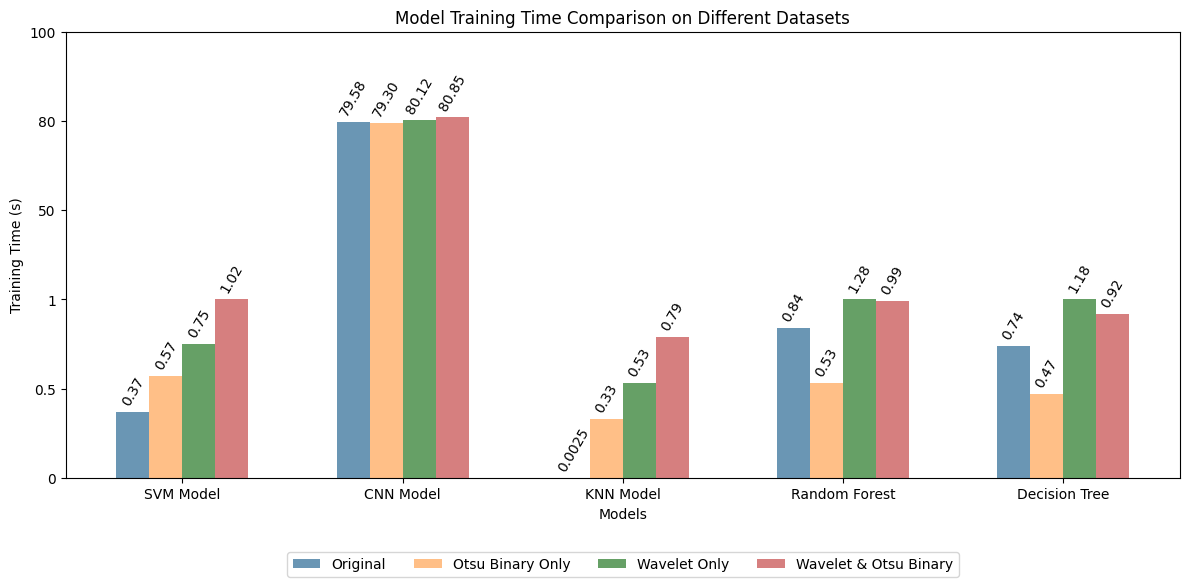

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb, rgb_to_hsv, hsv_to_rgb
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.scale import FuncScale

# Model names
models = ['SVM Model', 'CNN Model', 'KNN Model', 'Random Forest', 'Decision Tree']

# Dataset names
datasets = ['Original', 'Otsu Binary Only', 'Wavelet Only', 'Wavelet & Otsu Binary']

# Training Times
new_training_times = [
    [0.37, 0.57, 0.75, 1.02],  # SVM Model
    [79.58, 79.30, 80.12, 80.85],  # CNN Model
    [0.00246, 0.33, 0.53, 0.79],  # KNN Model
    [0.84, 0.53, 1.28, 0.99],  # Random Forest
    [0.74, 0.47, 1.18, 0.92]  # Decision Tree
]

# Set the width of the bars
bar_width = 0.15

# Calculate positions for each model
r = np.arange(len(models))
positions = [
    [x + i * bar_width for x in r] for i in range(len(datasets))
]

# Original academic color palette
original_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Function to desaturate colors
def desaturate_color(color, saturation_factor=0.5):
    """
    Desaturate a given color by the specified saturation factor.

    Args:
        color: The input color in a format convertible to RGB.
        saturation_factor: The factor by which to reduce the saturation.

    Returns:
        The desaturated color in RGB format.
    """
    rgb = to_rgb(color)
    hsv = rgb_to_hsv(rgb)
    hsv[1] *= saturation_factor
    new_rgb = hsv_to_rgb(hsv)
    return new_rgb

# Apply desaturation to colors
colors = [desaturate_color(c) for c in original_colors]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Custom tick values
custom_ticks = [0, 0.5, 1, 50, 80, 100]

# Custom y-axis scaling functions
def forward(x):
    """
    Map the original data values to a uniform scale space.

    Args:
        x: The original data values.

    Returns:
        The mapped values in the uniform scale space.
    """
    result = np.zeros_like(x)
    for i in range(len(custom_ticks) - 1):
        mask = (custom_ticks[i] <= x) & (x < custom_ticks[i + 1])
        result[mask] = i + (x[mask] - custom_ticks[i]) / (custom_ticks[i + 1] - custom_ticks[i])
    result[x >= custom_ticks[-1]] = len(custom_ticks) - 1
    return result

def inverse(x):
    """
    Map the values in the uniform scale space back to the original data values.

    Args:
        x: The values in the uniform scale space.

    Returns:
        The mapped original data values.
    """
    result = np.zeros_like(x)
    for i in range(len(custom_ticks) - 1):
        mask = (i <= x) & (x < i + 1)
        result[mask] = custom_ticks[i] + (x[mask] - i) * (custom_ticks[i + 1] - custom_ticks[i])
    result[x >= len(custom_ticks) - 1] = custom_ticks[-1]
    return result

custom_scale = FuncScale(ax, functions=(forward, inverse))
ax.set_yscale(custom_scale)

# Draw bars for each dataset
bars = []
for i in range(len(datasets)):
    bar = ax.bar(positions[i], [time[i] for time in new_training_times], width=bar_width, color=colors[i], label=datasets[i])
    bars.append(bar)

    # Display the original value on each bar with appropriate decimal places and set rotation
    for model_idx, (rect, orig_time) in enumerate(zip(bar, [time[i] for time in new_training_times])):
        height = rect.get_height()

        if model_idx == 2 and i == 0:
            annotation = f'{orig_time:.4f}'
        else:
            annotation = f'{orig_time:.2f}'
        ax.annotate(annotation,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset vertically by 3 points
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation=60)  # Set the rotation angle of the labels

# Set the title and axis labels
ax.set_title('Model Training Time Comparison on Different Datasets')
ax.set_xlabel('Models')
ax.set_ylabel('Training Time (s)')

# Set x-axis ticks and labels
ax.set_xticks([r + 1.5 * bar_width for r in range(len(models))])
ax.set_xticklabels(models)

# Set custom y-axis ticks
ax.yaxis.set_major_locator(FixedLocator(custom_ticks))
ax.yaxis.set_major_formatter(FixedFormatter([str(tick) for tick in custom_ticks]))

# Adjust y-axis range to ensure the highest value is properly shown
ax.set_ylim(0, 100)

# Display the legend at a better position
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# Optimize layout and display the graph
plt.tight_layout()
plt.show()